# Gesture Phase Segmentation Dataset: Random Forest and Neural Network

In [1]:
#library importing
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import timeit

from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics           import accuracy_score, confusion_matrix, classification_report
from sklearn                   import preprocessing

#Random Forest
from sklearn.ensemble          import RandomForestClassifier

#Neural Network
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
#loading datasets
data1=pd.read_csv('a1_va3.csv', header=0)
data2=pd.read_csv('a2_va3.csv', header=0)
data3=pd.read_csv('a3_va3.csv', header=0)
data_all = pd.concat([data1, data2, data3])

# Part1: Preprocess Data

Missing Value, Encode Categorical Data, Narrowing down Attributes accroding to Correlation, Data Balance, Data Split

In [3]:
#1.1 checking dataset for missing values
data_all.isnull().values.any()

False

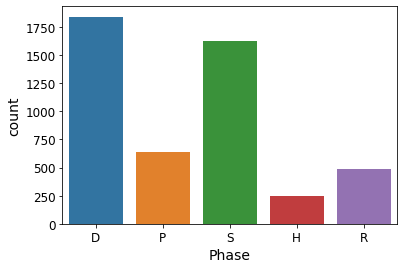

In [4]:
#Visualisation: Look at class distribution
sns.countplot(data_all['Phase'])

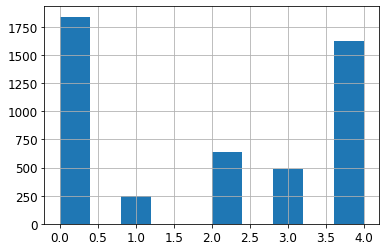

In [5]:
#1.2 Encode categorical data
le = preprocessing.LabelEncoder()
le.fit(data_all['Phase'])
data_all['classenc'] = le.transform(data_all['Phase'])
data_all['classenc'].hist()

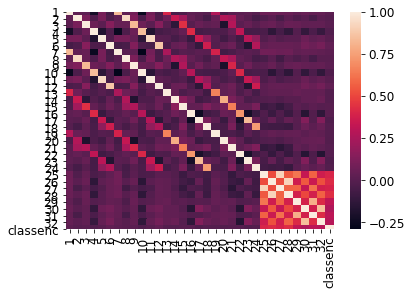

In [6]:
#1.3 Correlation calculation and visualization
td_corr = data_all.corr()
sns.heatmap(td_corr, xticklabels=td_corr.columns, yticklabels=td_corr.columns)

Accroding to the heatmap, there are high correlations between the last 8 attributes and between hands and wrists(such as 1 vs 7).

So the number of attributes is narrowed down to 12.

In [7]:
#Attributes Selection
attributes = ['1', '2', '3', '4', '5', '6', '13', '14', '15', '16', '17', '18']
data= data_all[attributes+['classenc']]

After narrowing down the number of attributes to 12, a scatter plot is used to show the correlation between attributes.

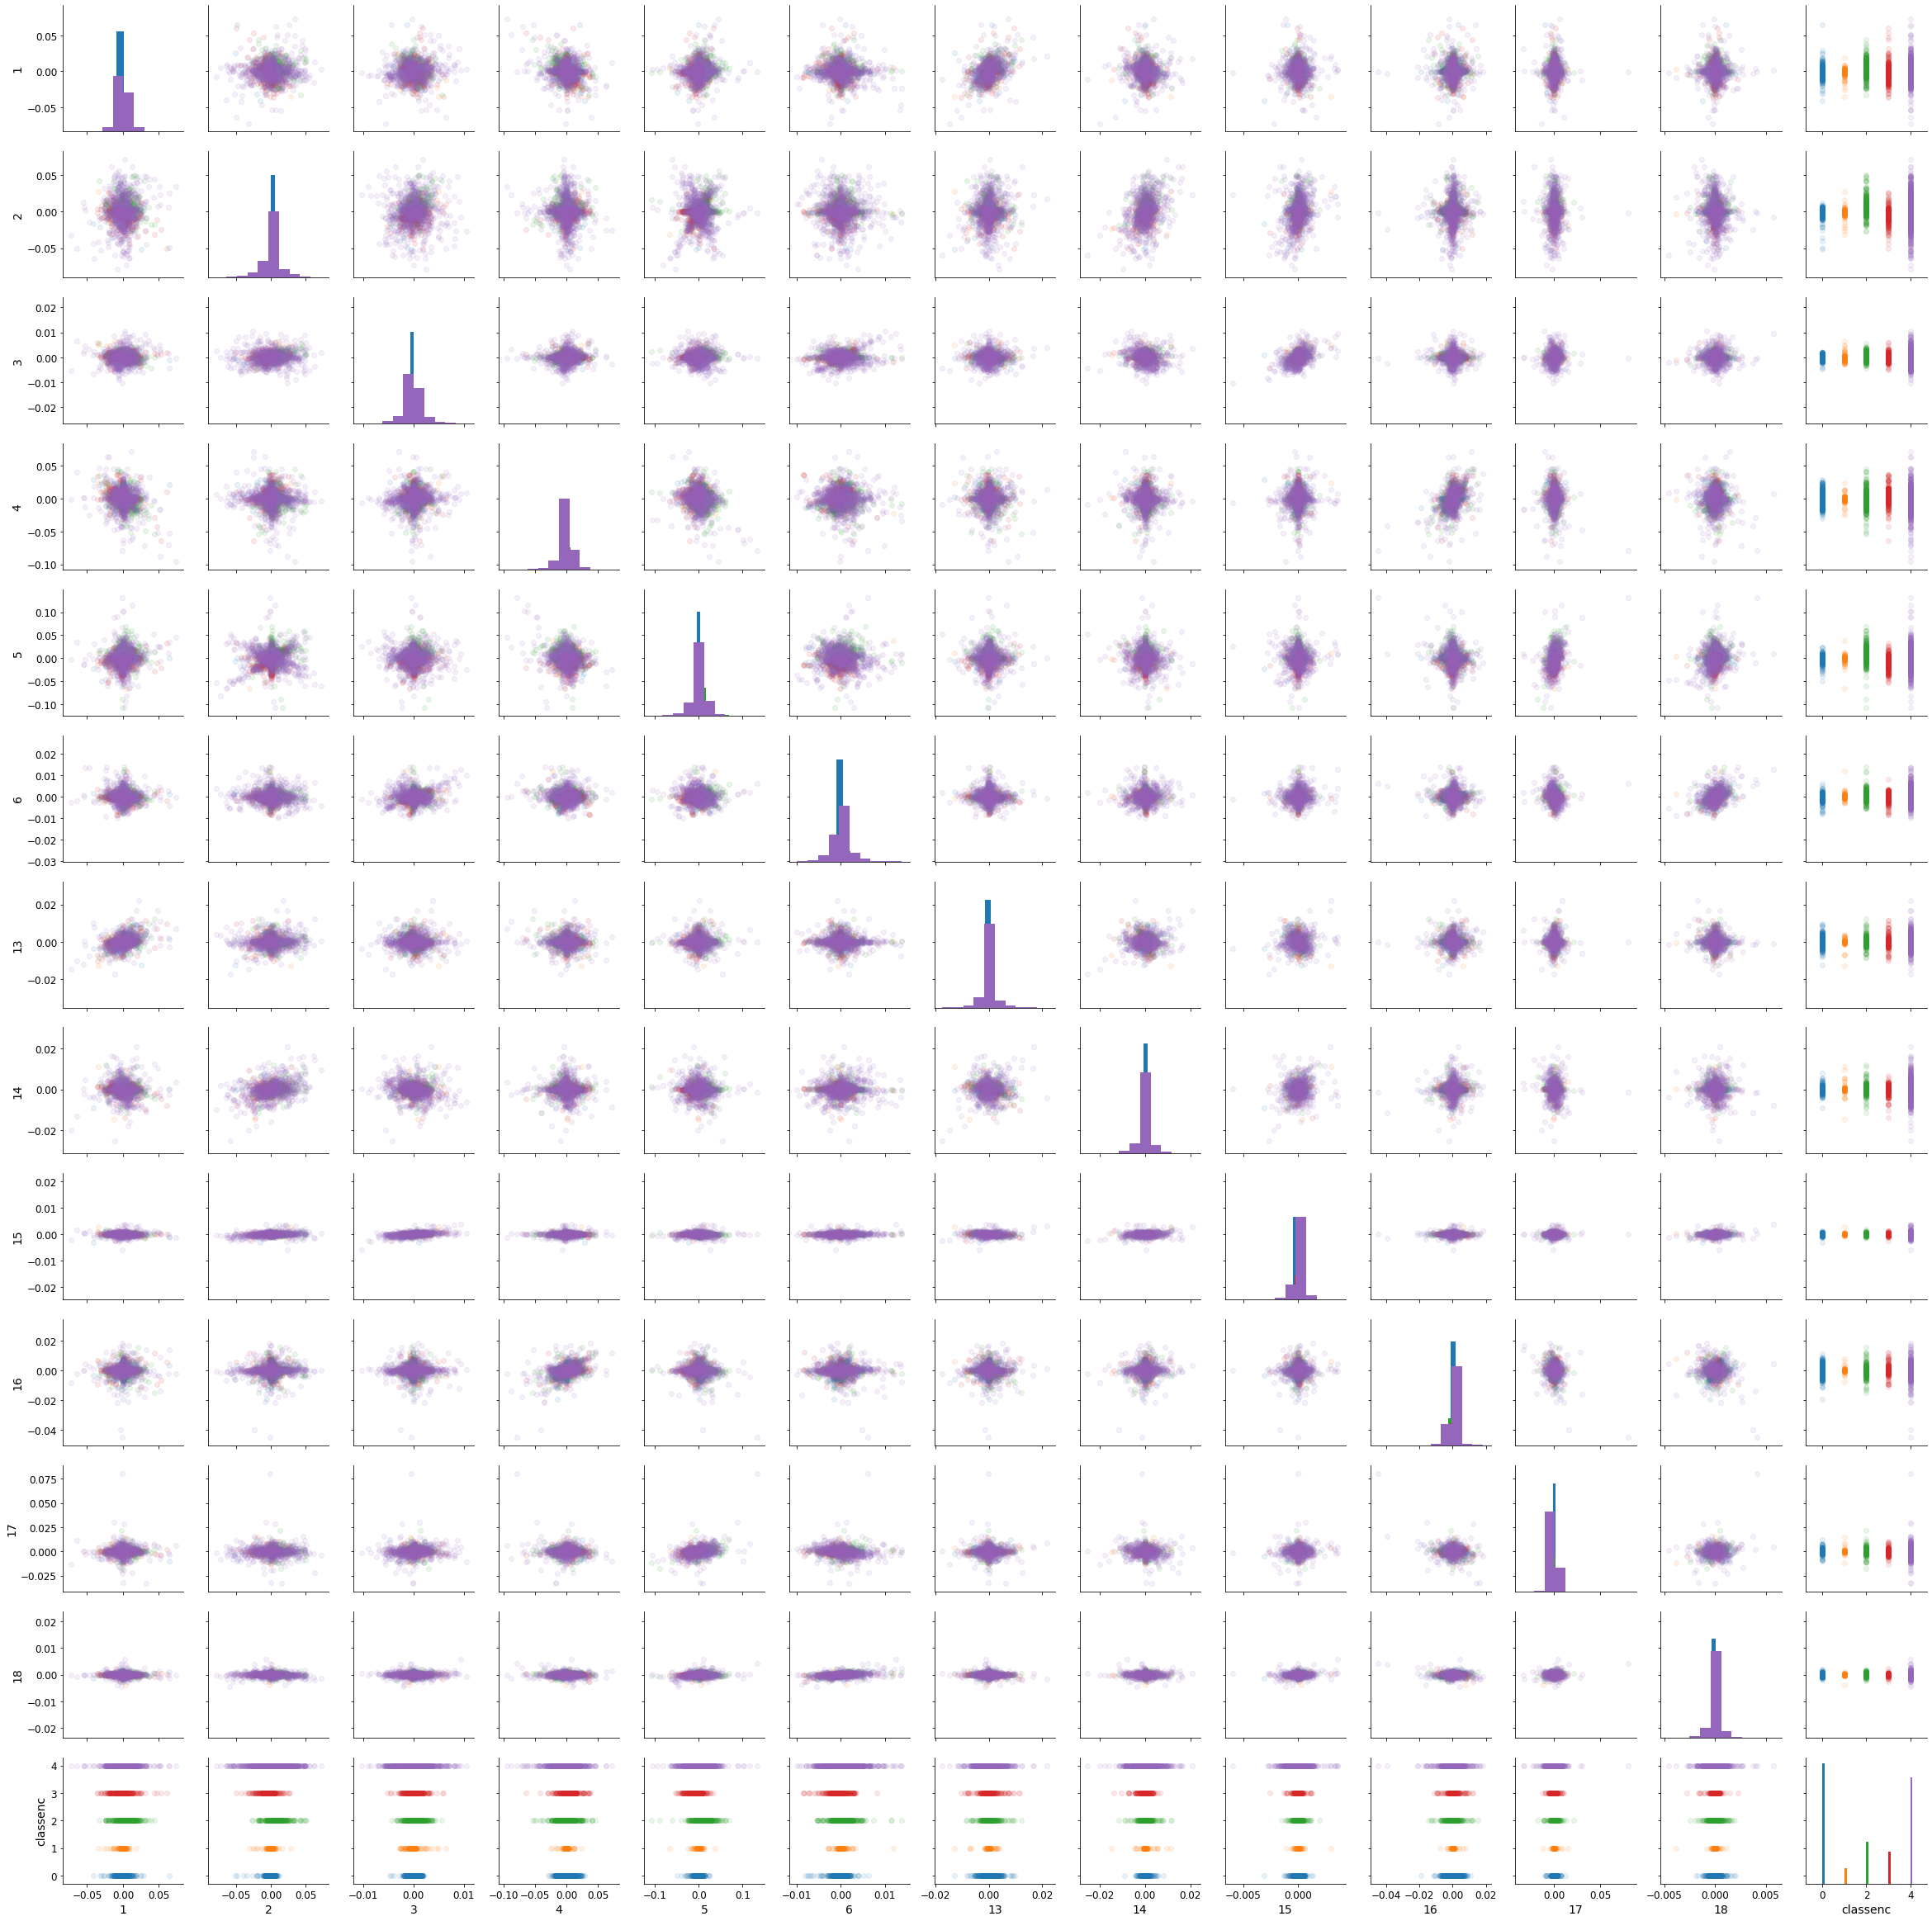

In [8]:
#visualizing by scatter plot
g = sns.PairGrid(data, hue = "classenc")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, alpha = 0.1)

1.4 Data Balance:

In [9]:
#counting the number of each category
data.iloc[:, -1].value_counts()

0    1841
4    1622
2     642
3     485
1     243
Name: classenc, dtype: int64

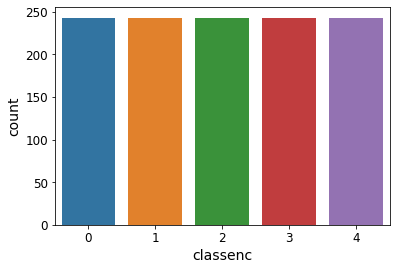

In [10]:
#making them equally distributed
dat_0 = data[data['classenc'] == 0]
dat_1 = data[data['classenc'] == 1]
dat_2 = data[data['classenc'] == 2]
dat_3 = data[data['classenc'] == 3]
dat_4 = data[data['classenc'] == 4]

dat_banlanced=dat_0.sample(n=243, random_state=0)
dat_banlanced=dat_banlanced.append(dat_1.sample(n=243, random_state=0))
dat_banlanced=dat_banlanced.append(dat_2.sample(n=243, random_state=0))
dat_banlanced=dat_banlanced.append(dat_3.sample(n=243, random_state=0))
dat_banlanced=dat_banlanced.append(dat_4.sample(n=243, random_state=0))
sns.countplot(dat_banlanced['classenc'])

In [11]:
train1, test1 = train_test_split(data, test_size=0.33, random_state = 42)
X_train1=train1.iloc[:, 0:12].values
y_train1=train1.iloc[:,-1]
X_test1=test1.iloc[:, 0:12].values
y_test1=test1.iloc[:,-1]

train2, test2 = train_test_split(dat_banlanced, test_size=0.33, random_state = 42)
X_train2=train2.iloc[:, 0:12].values
y_train2=train2.iloc[:,-1]
X_test2=test2.iloc[:, 0:12].values
y_test2=test2.iloc[:,-1]


The difference between Cross Validation and Accuracy with unbalanced and balanced data will be explored.

# Part2: Random Forest

**2.1 Unbalanced Dataset**

In [12]:
#Using GridSearch to find the best parameters and cross_validation_score
#Using %%timeit function to get model training time
rf = RandomForestClassifier(random_state=1)
param = {
        'n_estimators': np.arange(80, 200, 20),
        'max_depth': np.arange(10, 100, 10),
        'min_samples_leaf':[1, 2, 4]
        }
grid1 = GridSearchCV(estimator = rf, param_grid = param, cv=5, scoring='accuracy')
grid1.fit(X_train1,y_train1)

print('gridsearch_best_score:',grid1.best_score_)
print('gridsearch_best_params:',grid1.best_params_)

gridsearch_best_score: 0.7063001852995676
gridsearch_best_params: {'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 180}


Unbalanced test Accuracy Score : 0.7021943573667712
              precision    recall  f1-score   support

           0       0.74      0.86      0.79       606
           1       1.00      0.37      0.54        83
           2       0.74      0.33      0.45       211
           3       0.69      0.35      0.46       160
           4       0.65      0.83      0.73       535

    accuracy                           0.70      1595
   macro avg       0.76      0.55      0.60      1595
weighted avg       0.72      0.70      0.68      1595



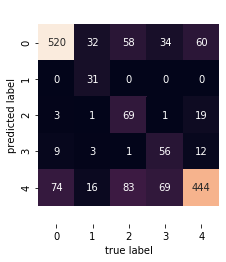

In [17]:
#Classification Report and F1 score
print('Unbalanced test Accuracy Score : {}'.format(accuracy_score(y_test1, grid1.predict(X_test1))))
print(classification_report(y_test1, grid1.predict(X_test1)))
con1 = confusion_matrix(y_test1, grid1.predict(X_test1))

ax = sns.heatmap(con1.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=grid1.classes_, yticklabels=grid1.classes_)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

Rest(0) and Stroke(4) perform a high score, but recall and F1 scores of Hold(1), Preparation(2) and Retraction(3) are quite low, which means these three phases have plenty of False Negative points. The confusion matrix also shows that a lot of Hold(1), Preparation(2) and Retraction(3) are recognized as Rest(0) and Stroke(4).
Although the model gets 0.70 accuracy score, it cannot recognize Hold(1), Preparation(2) and Retraction(3) well.

**2.2 Balanced Dataset**

In [25]:
#Using GridSearch to find the best parameters and cross_validation_score
rf = RandomForestClassifier(random_state=1)
param = {
        'n_estimators': np.arange(80, 200, 20),
        'max_depth': np.arange(10, 100, 10),
        'min_samples_leaf':[1, 2, 4]
        }
grid2 = GridSearchCV(estimator = rf, param_grid = param, cv=5, scoring='accuracy')
grid2.fit(X_train2,y_train2)

print('gridsearch_best_score:',grid2.best_score_)
print('gridsearch_best_params:',grid2.best_params_)

D:\python\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


gridsearch_best_score: 0.5823095823095823
gridsearch_best_params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 140}


Balanced test Accuracy Score : 0.6309226932668329
              precision    recall  f1-score   support

           0       0.56      0.77      0.65        79
           1       0.74      0.63      0.68        92
           2       0.67      0.54      0.60        87
           3       0.61      0.71      0.66        73
           4       0.58      0.50      0.54        70

    accuracy                           0.63       401
   macro avg       0.63      0.63      0.63       401
weighted avg       0.64      0.63      0.63       401



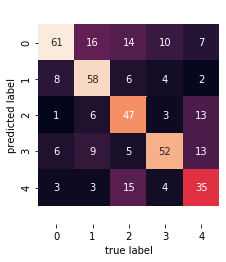

In [26]:
#Classification Report and F1 score
print('Balanced test Accuracy Score : {}'.format(accuracy_score(y_test2, grid2.predict(X_test2))))
print(classification_report(y_test2, grid2.predict(X_test2)))
con2 = confusion_matrix(y_test2, grid2.predict(X_test2))

ax = sns.heatmap(con2.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=grid2.classes_, yticklabels=grid2.classes_)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

On balanced test, all the five categories are equally distributed, the accuracy score is about 0.63. This time, recall and F1 scores of Hold(1), Preparation(2) and Retraction(3) are much higher than unbalanced dataset, which means the model can recognize them better.


Random Forest model training time:

In [32]:
%%timeit
rf = RandomForestClassifier(random_state=1, n_estimators= 140, max_depth= 20, min_samples_leaf= 1)
rf.fit(X_train2,y_train2)

472 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Part3: Neural Network

In [12]:
#Use one-hot encoding
y = keras.utils.to_categorical(train2['classenc'])
X = train2.iloc[:, 0:12].values
X.shape

(814, 12)

Use training data to build model; use GridSearch to find best parameters

In [23]:
def creat_model(optimizer='rmsprop'):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(100, activation='relu', input_dim=12))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(25, activation='relu'))
    model.add(keras.layers.Dense(5, activation="softmax"))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=creat_model, verbose=1)

#set parameters
batch_size = [15, 30, 45]
epochs = [200, 400, 600]
optimizers = ['rmsprop', 'adam']
param_grid = dict(optimizer=optimizers, batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X, y)
print('Best parameters: ',grid.best_params_)
print('Best score',grid.best_score_)

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 3ms/sample - loss: 1.6082 - accuracy: 0.2212
Epoch 2/200
651/651 [==============================] - 0s 270us/sample - loss: 1.6044 - accuracy: 0.2366
Epoch 3/200
651/651 [==============================] - 0s 301us/sample - loss: 1.6009 - accuracy: 0.2581
Epoch 4/200
651/651 [==============================] - 0s 246us/sample - loss: 1.5949 - accuracy: 0.2734
Epoch 5/200
651/651 [==============================] - 0s 215us/sample - loss: 1.5861 - accuracy: 0.2642
Epoch 6/200
651/651 [==============================] - 0s 221us/sample - loss: 1.5750 - accuracy: 0.2596
Epoch 7/200
651/651 [==============================] - 0s 233us/sample - loss: 1.5640 - accuracy: 0.2826
Epoch 8/200
651/651 [==============================] - 0s 221us/sample - loss: 1.5515 - accuracy: 0.2857
Epoch 9/200
651/651 [==============================] - 0s 227us/sample - loss: 1.5359 - accuracy: 0.2919
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 135us/sample - loss: 1.2079 - accuracy: 0.4916
Epoch 154/200
651/651 [==============================] - 0s 141us/sample - loss: 1.2024 - accuracy: 0.4854
Epoch 155/200
651/651 [==============================] - 0s 147us/sample - loss: 1.2032 - accuracy: 0.5008
Epoch 156/200
651/651 [==============================] - 0s 141us/sample - loss: 1.2087 - accuracy: 0.4916
Epoch 157/200
651/651 [==============================] - 0s 141us/sample - loss: 1.1962 - accuracy: 0.5115
Epoch 158/200
651/651 [==============================] - 0s 135us/sample - loss: 1.1967 - accuracy: 0.5115
Epoch 159/200
651/651 [==============================] - 0s 141us/sample - loss: 1.2093 - accuracy: 0.5146
Epoch 160/200
651/651 [==============================] - 0s 135us/sample - loss: 1.1979 - accuracy: 0.5084
Epoch 161/200
651/651 [==============================] - 0s 147us/sample - loss: 1.1944 - accuracy: 0.5023
Epoch 162/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2212
Epoch 2/200
651/651 [==============================] - 0s 276us/sample - loss: 1.6063 - accuracy: 0.2243
Epoch 3/200
651/651 [==============================] - 0s 264us/sample - loss: 1.6042 - accuracy: 0.2273
Epoch 4/200
651/651 [==============================] - 0s 258us/sample - loss: 1.6004 - accuracy: 0.2396
Epoch 5/200
651/651 [==============================] - 0s 246us/sample - loss: 1.5937 - accuracy: 0.2550
Epoch 6/200
651/651 [==============================] - 0s 246us/sample - loss: 1.5855 - accuracy: 0.2504
Epoch 7/200
651/651 [==============================] - 0s 240us/sample - loss: 1.5745 - accuracy: 0.2750
Epoch 8/200
651/651 [==============================] - 0s 233us/sample - loss: 1.5658 - accuracy: 0.2949
Epoch 9/200
651/651 [==============================] - 0s 221us/sample - loss: 1.5488 - accuracy: 0.2919
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 135us/sample - loss: 1.1982 - accuracy: 0.4793
Epoch 155/200
651/651 [==============================] - 0s 135us/sample - loss: 1.1940 - accuracy: 0.4854
Epoch 156/200
651/651 [==============================] - 0s 136us/sample - loss: 1.2042 - accuracy: 0.4654
Epoch 157/200
651/651 [==============================] - 0s 128us/sample - loss: 1.1855 - accuracy: 0.4823
Epoch 158/200
651/651 [==============================] - 0s 144us/sample - loss: 1.1918 - accuracy: 0.4992
Epoch 159/200
651/651 [==============================] - 0s 120us/sample - loss: 1.1884 - accuracy: 0.4869
Epoch 160/200
651/651 [==============================] - 0s 144us/sample - loss: 1.1882 - accuracy: 0.4885
Epoch 161/200
651/651 [==============================] - 0s 144us/sample - loss: 1.1851 - accuracy: 0.4992
Epoch 162/200
651/651 [==============================] - 0s 120us/sample - loss: 1.1921 - accuracy: 0.4885
Epoch 163/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6081 - accuracy: 0.2197
Epoch 2/200
651/651 [==============================] - 0s 144us/sample - loss: 1.6053 - accuracy: 0.2304
Epoch 3/200
651/651 [==============================] - 0s 145us/sample - loss: 1.6019 - accuracy: 0.2688
Epoch 4/200
651/651 [==============================] - 0s 129us/sample - loss: 1.5966 - accuracy: 0.2734
Epoch 5/200
651/651 [==============================] - 0s 135us/sample - loss: 1.5888 - accuracy: 0.2765
Epoch 6/200
651/651 [==============================] - 0s 129us/sample - loss: 1.5793 - accuracy: 0.2734
Epoch 7/200
651/651 [==============================] - 0s 135us/sample - loss: 1.5688 - accuracy: 0.2826
Epoch 8/200
651/651 [==============================] - 0s 135us/sample - loss: 1.5560 - accuracy: 0.2873
Epoch 9/200
651/651 [==============================] - 0s 135us/sample - loss: 1.5406 - accuracy: 0.2980
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 166us/sample - loss: 1.1589 - accuracy: 0.5269
Epoch 155/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1607 - accuracy: 0.5131
Epoch 156/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1686 - accuracy: 0.5146
Epoch 157/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1607 - accuracy: 0.4900
Epoch 158/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1616 - accuracy: 0.5069
Epoch 159/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1570 - accuracy: 0.5084
Epoch 160/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1506 - accuracy: 0.5223
Epoch 161/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1570 - accuracy: 0.4962
Epoch 162/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1526 - accuracy: 0.5207
Epoch 163/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 3ms/sample - loss: 1.6078 - accuracy: 0.2197
Epoch 2/200
651/651 [==============================] - 0s 166us/sample - loss: 1.6049 - accuracy: 0.2335
Epoch 3/200
651/651 [==============================] - 0s 160us/sample - loss: 1.6010 - accuracy: 0.2396
Epoch 4/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5947 - accuracy: 0.2673
Epoch 5/200
651/651 [==============================] - 0s 172us/sample - loss: 1.5866 - accuracy: 0.2750
Epoch 6/200
651/651 [==============================] - 0s 166us/sample - loss: 1.5760 - accuracy: 0.2826
Epoch 7/200
651/651 [==============================] - 0s 166us/sample - loss: 1.5645 - accuracy: 0.3041
Epoch 8/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5496 - accuracy: 0.3072
Epoch 9/200
651/651 [==============================] - 0s 172us/sample - loss: 1.5371 - accuracy: 0.3272
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 190us/sample - loss: 1.1966 - accuracy: 0.4962
Epoch 155/200
651/651 [==============================] - 0s 172us/sample - loss: 1.1906 - accuracy: 0.4854
Epoch 156/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1924 - accuracy: 0.5008
Epoch 157/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1846 - accuracy: 0.4992
Epoch 158/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1935 - accuracy: 0.4946
Epoch 159/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1802 - accuracy: 0.5069
Epoch 160/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1896 - accuracy: 0.5023
Epoch 161/200
651/651 [==============================] - 0s 172us/sample - loss: 1.1922 - accuracy: 0.4808
Epoch 162/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1928 - accuracy: 0.4992
Epoch 163/200
651/651 [============================

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2255
Epoch 2/200
652/652 [==============================] - 0s 166us/sample - loss: 1.6048 - accuracy: 0.2485
Epoch 3/200
652/652 [==============================] - 0s 227us/sample - loss: 1.5990 - accuracy: 0.2669
Epoch 4/200
652/652 [==============================] - 0s 233us/sample - loss: 1.5907 - accuracy: 0.2730
Epoch 5/200
652/652 [==============================] - 0s 233us/sample - loss: 1.5797 - accuracy: 0.2776
Epoch 6/200
652/652 [==============================] - 0s 227us/sample - loss: 1.5668 - accuracy: 0.2991
Epoch 7/200
652/652 [==============================] - 0s 233us/sample - loss: 1.5474 - accuracy: 0.2975
Epoch 8/200
652/652 [==============================] - 0s 227us/sample - loss: 1.5386 - accuracy: 0.2899
Epoch 9/200
652/652 [==============================] - 0s 221us/sample - loss: 1.5122 - accuracy: 0.2960
Epoch 10/200
652/652 [==============

652/652 [==============================] - 0s 166us/sample - loss: 1.1525 - accuracy: 0.4939
Epoch 155/200
652/652 [==============================] - 0s 147us/sample - loss: 1.1560 - accuracy: 0.5077
Epoch 156/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1524 - accuracy: 0.5153
Epoch 157/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1581 - accuracy: 0.5092
Epoch 158/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1586 - accuracy: 0.5215
Epoch 159/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1496 - accuracy: 0.4939
Epoch 160/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1481 - accuracy: 0.5307
Epoch 161/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1517 - accuracy: 0.5153
Epoch 162/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1419 - accuracy: 0.5138
Epoch 163/200
652/652 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6081 - accuracy: 0.2135
Epoch 2/200
651/651 [==============================] - 0s 246us/sample - loss: 1.6051 - accuracy: 0.2212
Epoch 3/200
651/651 [==============================] - 0s 233us/sample - loss: 1.6025 - accuracy: 0.2550
Epoch 4/200
651/651 [==============================] - 0s 240us/sample - loss: 1.5942 - accuracy: 0.2627
Epoch 5/200
651/651 [==============================] - 0s 264us/sample - loss: 1.5792 - accuracy: 0.2780
Epoch 6/200
651/651 [==============================] - 0s 307us/sample - loss: 1.5615 - accuracy: 0.3041
Epoch 7/200
651/651 [==============================] - 0s 289us/sample - loss: 1.5459 - accuracy: 0.2949
Epoch 8/200
651/651 [==============================] - 0s 276us/sample - loss: 1.5199 - accuracy: 0.3011
Epoch 9/200
651/651 [==============================] - 0s 240us/sample - loss: 1.5217 - accuracy: 0.2873
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 197us/sample - loss: 1.1490 - accuracy: 0.5315
Epoch 155/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1620 - accuracy: 0.4977
Epoch 156/200
651/651 [==============================] - 0s 156us/sample - loss: 1.1698 - accuracy: 0.5023
Epoch 157/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1591 - accuracy: 0.5161
Epoch 158/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1443 - accuracy: 0.5330
Epoch 159/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1650 - accuracy: 0.5238
Epoch 160/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1493 - accuracy: 0.5238
Epoch 161/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1561 - accuracy: 0.5269
Epoch 162/200
651/651 [==============================] - 0s 172us/sample - loss: 1.1534 - accuracy: 0.5269
Epoch 163/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6084 - accuracy: 0.2181
Epoch 2/200
651/651 [==============================] - 0s 160us/sample - loss: 1.6059 - accuracy: 0.2258
Epoch 3/200
651/651 [==============================] - 0s 160us/sample - loss: 1.6040 - accuracy: 0.2258
Epoch 4/200
651/651 [==============================] - 0s 154us/sample - loss: 1.5979 - accuracy: 0.2258
Epoch 5/200
651/651 [==============================] - 0s 154us/sample - loss: 1.5866 - accuracy: 0.2396
Epoch 6/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5713 - accuracy: 0.2581
Epoch 7/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5550 - accuracy: 0.2734
Epoch 8/200
651/651 [==============================] - 0s 154us/sample - loss: 1.5267 - accuracy: 0.3026
Epoch 9/200
651/651 [==============================] - 0s 172us/sample - loss: 1.5043 - accuracy: 0.2995
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 215us/sample - loss: 1.1512 - accuracy: 0.5023
Epoch 155/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1485 - accuracy: 0.5100
Epoch 156/200
651/651 [==============================] - 0s 172us/sample - loss: 1.1648 - accuracy: 0.4992
Epoch 157/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1542 - accuracy: 0.5115
Epoch 158/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1418 - accuracy: 0.5330
Epoch 159/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1555 - accuracy: 0.5054
Epoch 160/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1585 - accuracy: 0.5146
Epoch 161/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1702 - accuracy: 0.5008
Epoch 162/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1475 - accuracy: 0.5192
Epoch 163/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6084 - accuracy: 0.2212
Epoch 2/200
651/651 [==============================] - 0s 166us/sample - loss: 1.6057 - accuracy: 0.2320
Epoch 3/200
651/651 [==============================] - 0s 173us/sample - loss: 1.6012 - accuracy: 0.2581
Epoch 4/200
651/651 [==============================] - 0s 178us/sample - loss: 1.5938 - accuracy: 0.2842
Epoch 5/200
651/651 [==============================] - 0s 172us/sample - loss: 1.5789 - accuracy: 0.2873
Epoch 6/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5586 - accuracy: 0.2949
Epoch 7/200
651/651 [==============================] - 0s 166us/sample - loss: 1.5370 - accuracy: 0.2934
Epoch 8/200
651/651 [==============================] - 0s 160us/sample - loss: 1.5169 - accuracy: 0.2919
Epoch 9/200
651/651 [==============================] - 0s 172us/sample - loss: 1.4918 - accuracy: 0.3103
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 184us/sample - loss: 1.1128 - accuracy: 0.5238
Epoch 155/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1094 - accuracy: 0.5300
Epoch 156/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1343 - accuracy: 0.5346
Epoch 157/200
651/651 [==============================] - 0s 154us/sample - loss: 1.1013 - accuracy: 0.5407
Epoch 158/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1015 - accuracy: 0.5100
Epoch 159/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1403 - accuracy: 0.5223
Epoch 160/200
651/651 [==============================] - 0s 184us/sample - loss: 1.1065 - accuracy: 0.5376
Epoch 161/200
651/651 [==============================] - 0s 178us/sample - loss: 1.1204 - accuracy: 0.5407
Epoch 162/200
651/651 [==============================] - 0s 172us/sample - loss: 1.0950 - accuracy: 0.5253
Epoch 163/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6078 - accuracy: 0.2350
Epoch 2/200
651/651 [==============================] - 0s 270us/sample - loss: 1.6061 - accuracy: 0.2350
Epoch 3/200
651/651 [==============================] - 0s 295us/sample - loss: 1.5995 - accuracy: 0.2427
Epoch 4/200
651/651 [==============================] - 0s 289us/sample - loss: 1.5930 - accuracy: 0.2642
Epoch 5/200
651/651 [==============================] - 0s 264us/sample - loss: 1.5801 - accuracy: 0.2965
Epoch 6/200
651/651 [==============================] - 0s 233us/sample - loss: 1.5677 - accuracy: 0.2919
Epoch 7/200
651/651 [==============================] - 0s 221us/sample - loss: 1.5487 - accuracy: 0.3041
Epoch 8/200
651/651 [==============================] - 0s 221us/sample - loss: 1.5203 - accuracy: 0.3118
Epoch 9/200
651/651 [==============================] - 0s 227us/sample - loss: 1.5020 - accuracy: 0.3287
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 178us/sample - loss: 1.1809 - accuracy: 0.4946
Epoch 155/200
651/651 [==============================] - 0s 166us/sample - loss: 1.1898 - accuracy: 0.5069
Epoch 156/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1954 - accuracy: 0.5038
Epoch 157/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1684 - accuracy: 0.5131
Epoch 158/200
651/651 [==============================] - 0s 172us/sample - loss: 1.1801 - accuracy: 0.4854
Epoch 159/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1769 - accuracy: 0.5253
Epoch 160/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1862 - accuracy: 0.5177
Epoch 161/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1749 - accuracy: 0.5038
Epoch 162/200
651/651 [==============================] - 0s 160us/sample - loss: 1.1710 - accuracy: 0.4916
Epoch 163/200
651/651 [============================

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 1ms/sample - loss: 1.6078 - accuracy: 0.2270
Epoch 2/200
652/652 [==============================] - 0s 153us/sample - loss: 1.6033 - accuracy: 0.2531
Epoch 3/200
652/652 [==============================] - 0s 153us/sample - loss: 1.5974 - accuracy: 0.2515
Epoch 4/200
652/652 [==============================] - 0s 159us/sample - loss: 1.5863 - accuracy: 0.2883
Epoch 5/200
652/652 [==============================] - 0s 159us/sample - loss: 1.5667 - accuracy: 0.2761
Epoch 6/200
652/652 [==============================] - 0s 153us/sample - loss: 1.5389 - accuracy: 0.2960
Epoch 7/200
652/652 [==============================] - 0s 153us/sample - loss: 1.5088 - accuracy: 0.3052
Epoch 8/200
652/652 [==============================] - 0s 159us/sample - loss: 1.4934 - accuracy: 0.3098
Epoch 9/200
652/652 [==============================] - 0s 153us/sample - loss: 1.4740 - accuracy: 0.3267
Epoch 10/200
652/652 [==============

652/652 [==============================] - 0s 159us/sample - loss: 1.1498 - accuracy: 0.4985
Epoch 155/200
652/652 [==============================] - 0s 160us/sample - loss: 1.1330 - accuracy: 0.5230
Epoch 156/200
652/652 [==============================] - 0s 159us/sample - loss: 1.1388 - accuracy: 0.5123
Epoch 157/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1233 - accuracy: 0.5291
Epoch 158/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1319 - accuracy: 0.5123
Epoch 159/200
652/652 [==============================] - 0s 147us/sample - loss: 1.1401 - accuracy: 0.5077
Epoch 160/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1439 - accuracy: 0.5107
Epoch 161/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1402 - accuracy: 0.5015
Epoch 162/200
652/652 [==============================] - 0s 153us/sample - loss: 1.1220 - accuracy: 0.5383
Epoch 163/200
652/652 [============================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6082 - accuracy: 0.2212
Epoch 2/400
651/651 [==============================] - 0s 160us/sample - loss: 1.6044 - accuracy: 0.2366
Epoch 3/400
651/651 [==============================] - 0s 161us/sample - loss: 1.6009 - accuracy: 0.2581
Epoch 4/400
651/651 [==============================] - 0s 160us/sample - loss: 1.5949 - accuracy: 0.2734
Epoch 5/400
651/651 [==============================] - 0s 156us/sample - loss: 1.5861 - accuracy: 0.2642
Epoch 6/400
651/651 [==============================] - 0s 166us/sample - loss: 1.5750 - accuracy: 0.2596
Epoch 7/400
651/651 [==============================] - 0s 166us/sample - loss: 1.5640 - accuracy: 0.2826
Epoch 8/400
651/651 [==============================] - 0s 160us/sample - loss: 1.5515 - accuracy: 0.2857
Epoch 9/400
651/651 [==============================] - 0s 161us/sample - loss: 1.5359 - accuracy: 0.2919
Epoch 10/400
651/651 [==============

651/651 [==============================] - 0s 173us/sample - loss: 1.2079 - accuracy: 0.4916
Epoch 154/400
651/651 [==============================] - 0s 166us/sample - loss: 1.2024 - accuracy: 0.4854
Epoch 155/400
651/651 [==============================] - 0s 154us/sample - loss: 1.2032 - accuracy: 0.5008
Epoch 156/400
651/651 [==============================] - 0s 155us/sample - loss: 1.2087 - accuracy: 0.4916
Epoch 157/400
651/651 [==============================] - 0s 153us/sample - loss: 1.1962 - accuracy: 0.5115
Epoch 158/400
651/651 [==============================] - 0s 181us/sample - loss: 1.1967 - accuracy: 0.5115
Epoch 159/400
651/651 [==============================] - 0s 171us/sample - loss: 1.2093 - accuracy: 0.5146
Epoch 160/400
651/651 [==============================] - 0s 155us/sample - loss: 1.1979 - accuracy: 0.5084
Epoch 161/400
651/651 [==============================] - 0s 168us/sample - loss: 1.1944 - accuracy: 0.5023
Epoch 162/400
651/651 [============================

651/651 [==============================] - 0s 167us/sample - loss: 1.0482 - accuracy: 0.5730
Epoch 306/400
651/651 [==============================] - 0s 154us/sample - loss: 1.0538 - accuracy: 0.5469
Epoch 307/400
651/651 [==============================] - 0s 155us/sample - loss: 1.0554 - accuracy: 0.5515
Epoch 308/400
651/651 [==============================] - 0s 167us/sample - loss: 1.0511 - accuracy: 0.5791
Epoch 309/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0493 - accuracy: 0.5591
Epoch 310/400
651/651 [==============================] - 0s 154us/sample - loss: 1.0430 - accuracy: 0.5637
Epoch 311/400
651/651 [==============================] - 0s 177us/sample - loss: 1.0420 - accuracy: 0.5714
Epoch 312/400
651/651 [==============================] - 0s 175us/sample - loss: 1.0399 - accuracy: 0.5576
Epoch 313/400
651/651 [==============================] - 0s 259us/sample - loss: 1.0381 - accuracy: 0.5837
Epoch 314/400
651/651 [============================

651/651 [==============================] - 0s 177us/sample - loss: 1.5165 - accuracy: 0.2995
Epoch 12/400
651/651 [==============================] - 0s 177us/sample - loss: 1.5035 - accuracy: 0.3072
Epoch 13/400
651/651 [==============================] - 0s 180us/sample - loss: 1.4896 - accuracy: 0.3072
Epoch 14/400
651/651 [==============================] - 0s 177us/sample - loss: 1.4774 - accuracy: 0.3287
Epoch 15/400
651/651 [==============================] - 0s 172us/sample - loss: 1.4656 - accuracy: 0.3410
Epoch 16/400
651/651 [==============================] - 0s 173us/sample - loss: 1.4549 - accuracy: 0.3656
Epoch 17/400
651/651 [==============================] - 0s 173us/sample - loss: 1.4443 - accuracy: 0.3717
Epoch 18/400
651/651 [==============================] - 0s 160us/sample - loss: 1.4407 - accuracy: 0.3810
Epoch 19/400
651/651 [==============================] - 0s 170us/sample - loss: 1.4226 - accuracy: 0.3994
Epoch 20/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 243us/sample - loss: 1.1839 - accuracy: 0.4962
Epoch 165/400
651/651 [==============================] - 0s 221us/sample - loss: 1.1790 - accuracy: 0.4977
Epoch 166/400
651/651 [==============================] - 0s 238us/sample - loss: 1.1838 - accuracy: 0.5038
Epoch 167/400
651/651 [==============================] - 0s 181us/sample - loss: 1.1783 - accuracy: 0.4992
Epoch 168/400
651/651 [==============================] - 0s 172us/sample - loss: 1.1876 - accuracy: 0.4916
Epoch 169/400
651/651 [==============================] - 0s 177us/sample - loss: 1.1750 - accuracy: 0.5008
Epoch 170/400
651/651 [==============================] - 0s 181us/sample - loss: 1.1742 - accuracy: 0.4900
Epoch 171/400
651/651 [==============================] - 0s 206us/sample - loss: 1.1773 - accuracy: 0.4808
Epoch 172/400
651/651 [==============================] - 0s 178us/sample - loss: 1.1827 - accuracy: 0.5069
Epoch 173/400
651/651 [============================

651/651 [==============================] - 0s 227us/sample - loss: 1.0170 - accuracy: 0.5868
Epoch 317/400
651/651 [==============================] - 0s 166us/sample - loss: 1.0052 - accuracy: 0.5730
Epoch 318/400
651/651 [==============================] - 0s 156us/sample - loss: 1.0164 - accuracy: 0.5883
Epoch 319/400
651/651 [==============================] - 0s 157us/sample - loss: 1.0220 - accuracy: 0.5668
Epoch 320/400
651/651 [==============================] - 0s 170us/sample - loss: 1.0199 - accuracy: 0.5699
Epoch 321/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0173 - accuracy: 0.5791
Epoch 322/400
651/651 [==============================] - 0s 166us/sample - loss: 1.0106 - accuracy: 0.5991
Epoch 323/400
651/651 [==============================] - 0s 158us/sample - loss: 1.0118 - accuracy: 0.5929
Epoch 324/400
651/651 [==============================] - 0s 158us/sample - loss: 1.0133 - accuracy: 0.5868
Epoch 325/400
651/651 [============================

651/651 [==============================] - 0s 181us/sample - loss: 1.4144 - accuracy: 0.4332
Epoch 23/400
651/651 [==============================] - 0s 169us/sample - loss: 1.3976 - accuracy: 0.4301
Epoch 24/400
651/651 [==============================] - 0s 167us/sample - loss: 1.3942 - accuracy: 0.4347
Epoch 25/400
651/651 [==============================] - 0s 161us/sample - loss: 1.3919 - accuracy: 0.4332
Epoch 26/400
651/651 [==============================] - 0s 157us/sample - loss: 1.3798 - accuracy: 0.4378
Epoch 27/400
651/651 [==============================] - 0s 155us/sample - loss: 1.3737 - accuracy: 0.4347
Epoch 28/400
651/651 [==============================] - 0s 152us/sample - loss: 1.3653 - accuracy: 0.4578
Epoch 29/400
651/651 [==============================] - 0s 154us/sample - loss: 1.3590 - accuracy: 0.4393
Epoch 30/400
651/651 [==============================] - 0s 154us/sample - loss: 1.3596 - accuracy: 0.4316
Epoch 31/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 158us/sample - loss: 1.1412 - accuracy: 0.5361
Epoch 175/400
651/651 [==============================] - 0s 160us/sample - loss: 1.1453 - accuracy: 0.5192
Epoch 176/400
651/651 [==============================] - 0s 163us/sample - loss: 1.1378 - accuracy: 0.5361
Epoch 177/400
651/651 [==============================] - 0s 152us/sample - loss: 1.1419 - accuracy: 0.5115
Epoch 178/400
651/651 [==============================] - 0s 152us/sample - loss: 1.1498 - accuracy: 0.5422
Epoch 179/400
651/651 [==============================] - 0s 154us/sample - loss: 1.1423 - accuracy: 0.5376
Epoch 180/400
651/651 [==============================] - 0s 151us/sample - loss: 1.1214 - accuracy: 0.5545
Epoch 181/400
651/651 [==============================] - 0s 161us/sample - loss: 1.1306 - accuracy: 0.5207
Epoch 182/400
651/651 [==============================] - 0s 160us/sample - loss: 1.1198 - accuracy: 0.5515
Epoch 183/400
651/651 [============================

651/651 [==============================] - 0s 146us/sample - loss: 0.9914 - accuracy: 0.6068
Epoch 327/400
651/651 [==============================] - 0s 195us/sample - loss: 1.0022 - accuracy: 0.5730
Epoch 328/400
651/651 [==============================] - 0s 164us/sample - loss: 0.9907 - accuracy: 0.5960
Epoch 329/400
651/651 [==============================] - 0s 227us/sample - loss: 1.0079 - accuracy: 0.5760
Epoch 330/400
651/651 [==============================] - 0s 154us/sample - loss: 0.9915 - accuracy: 0.5914
Epoch 331/400
651/651 [==============================] - 0s 155us/sample - loss: 0.9855 - accuracy: 0.6006
Epoch 332/400
651/651 [==============================] - 0s 154us/sample - loss: 0.9972 - accuracy: 0.5837
Epoch 333/400
651/651 [==============================] - 0s 163us/sample - loss: 0.9820 - accuracy: 0.6098
Epoch 334/400
651/651 [==============================] - 0s 154us/sample - loss: 0.9740 - accuracy: 0.5960
Epoch 335/400
651/651 [============================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6078 - accuracy: 0.2197
Epoch 2/400
651/651 [==============================] - 0s 157us/sample - loss: 1.6049 - accuracy: 0.2335
Epoch 3/400
651/651 [==============================] - 0s 157us/sample - loss: 1.6010 - accuracy: 0.2396
Epoch 4/400
651/651 [==============================] - 0s 152us/sample - loss: 1.5947 - accuracy: 0.2673
Epoch 5/400
651/651 [==============================] - 0s 166us/sample - loss: 1.5866 - accuracy: 0.2750
Epoch 6/400
651/651 [==============================] - 0s 154us/sample - loss: 1.5760 - accuracy: 0.2826
Epoch 7/400
651/651 [==============================] - 0s 160us/sample - loss: 1.5645 - accuracy: 0.3041
Epoch 8/400
651/651 [==============================] - 0s 158us/sample - loss: 1.5496 - accuracy: 0.3072
Epoch 9/400
651/651 [==============================] - 0s 175us/sample - loss: 1.5371 - accuracy: 0.3272
Epoch 10/400
651/651 [==============

651/651 [==============================] - 0s 170us/sample - loss: 1.1966 - accuracy: 0.4962
Epoch 155/400
651/651 [==============================] - 0s 166us/sample - loss: 1.1906 - accuracy: 0.4854
Epoch 156/400
651/651 [==============================] - 0s 155us/sample - loss: 1.1924 - accuracy: 0.5008
Epoch 157/400
651/651 [==============================] - 0s 154us/sample - loss: 1.1846 - accuracy: 0.4992
Epoch 158/400
651/651 [==============================] - 0s 161us/sample - loss: 1.1935 - accuracy: 0.4946
Epoch 159/400
651/651 [==============================] - 0s 152us/sample - loss: 1.1802 - accuracy: 0.5069
Epoch 160/400
651/651 [==============================] - 0s 167us/sample - loss: 1.1896 - accuracy: 0.5023
Epoch 161/400
651/651 [==============================] - 0s 155us/sample - loss: 1.1922 - accuracy: 0.4808
Epoch 162/400
651/651 [==============================] - 0s 161us/sample - loss: 1.1928 - accuracy: 0.4992
Epoch 163/400
651/651 [============================

651/651 [==============================] - 0s 173us/sample - loss: 1.0424 - accuracy: 0.5791
Epoch 307/400
651/651 [==============================] - 0s 152us/sample - loss: 1.0416 - accuracy: 0.5714
Epoch 308/400
651/651 [==============================] - 0s 151us/sample - loss: 1.0368 - accuracy: 0.5637
Epoch 309/400
651/651 [==============================] - 0s 181us/sample - loss: 1.0357 - accuracy: 0.5714
Epoch 310/400
651/651 [==============================] - 0s 175us/sample - loss: 1.0411 - accuracy: 0.5607
Epoch 311/400
651/651 [==============================] - 0s 150us/sample - loss: 1.0347 - accuracy: 0.5899
Epoch 312/400
651/651 [==============================] - 0s 161us/sample - loss: 1.0423 - accuracy: 0.5668
Epoch 313/400
651/651 [==============================] - 0s 161us/sample - loss: 1.0305 - accuracy: 0.5791
Epoch 314/400
651/651 [==============================] - 0s 163us/sample - loss: 1.0275 - accuracy: 0.5730
Epoch 315/400
651/651 [============================

652/652 [==============================] - 0s 167us/sample - loss: 1.4748 - accuracy: 0.3160
Epoch 13/400
652/652 [==============================] - 0s 176us/sample - loss: 1.4645 - accuracy: 0.3635
Epoch 14/400
652/652 [==============================] - 0s 167us/sample - loss: 1.4637 - accuracy: 0.3727
Epoch 15/400
652/652 [==============================] - 0s 150us/sample - loss: 1.4531 - accuracy: 0.3758
Epoch 16/400
652/652 [==============================] - 0s 172us/sample - loss: 1.4446 - accuracy: 0.3896
Epoch 17/400
652/652 [==============================] - 0s 155us/sample - loss: 1.4351 - accuracy: 0.3834
Epoch 18/400
652/652 [==============================] - 0s 156us/sample - loss: 1.4376 - accuracy: 0.3650
Epoch 19/400
652/652 [==============================] - 0s 162us/sample - loss: 1.4217 - accuracy: 0.4034
Epoch 20/400
652/652 [==============================] - 0s 158us/sample - loss: 1.4229 - accuracy: 0.4156
Epoch 21/400
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 170us/sample - loss: 1.1551 - accuracy: 0.5031
Epoch 166/400
652/652 [==============================] - 0s 153us/sample - loss: 1.1625 - accuracy: 0.5092
Epoch 167/400
652/652 [==============================] - 0s 159us/sample - loss: 1.1458 - accuracy: 0.5107
Epoch 168/400
652/652 [==============================] - 0s 173us/sample - loss: 1.1555 - accuracy: 0.4939
Epoch 169/400
652/652 [==============================] - 0s 153us/sample - loss: 1.1282 - accuracy: 0.5383
Epoch 170/400
652/652 [==============================] - 0s 178us/sample - loss: 1.1506 - accuracy: 0.5184
Epoch 171/400
652/652 [==============================] - 0s 172us/sample - loss: 1.1327 - accuracy: 0.5199
Epoch 172/400
652/652 [==============================] - 0s 175us/sample - loss: 1.1396 - accuracy: 0.5230
Epoch 173/400
652/652 [==============================] - 0s 159us/sample - loss: 1.1387 - accuracy: 0.5077
Epoch 174/400
652/652 [============================

652/652 [==============================] - 0s 147us/sample - loss: 0.9927 - accuracy: 0.5828
Epoch 318/400
652/652 [==============================] - 0s 179us/sample - loss: 0.9796 - accuracy: 0.5828
Epoch 319/400
652/652 [==============================] - 0s 164us/sample - loss: 0.9907 - accuracy: 0.5844
Epoch 320/400
652/652 [==============================] - 0s 162us/sample - loss: 0.9887 - accuracy: 0.5752
Epoch 321/400
652/652 [==============================] - 0s 156us/sample - loss: 0.9764 - accuracy: 0.5951
Epoch 322/400
652/652 [==============================] - 0s 159us/sample - loss: 0.9771 - accuracy: 0.6089
Epoch 323/400
652/652 [==============================] - 0s 175us/sample - loss: 0.9766 - accuracy: 0.5874
Epoch 324/400
652/652 [==============================] - 0s 167us/sample - loss: 0.9800 - accuracy: 0.5936
Epoch 325/400
652/652 [==============================] - 0s 158us/sample - loss: 0.9741 - accuracy: 0.5890
Epoch 326/400
652/652 [============================

651/651 [==============================] - 0s 180us/sample - loss: 1.3861 - accuracy: 0.4332
Epoch 24/400
651/651 [==============================] - 0s 169us/sample - loss: 1.3750 - accuracy: 0.4501
Epoch 25/400
651/651 [==============================] - 0s 157us/sample - loss: 1.3737 - accuracy: 0.4347
Epoch 26/400
651/651 [==============================] - 0s 154us/sample - loss: 1.3759 - accuracy: 0.4455
Epoch 27/400
651/651 [==============================] - 0s 172us/sample - loss: 1.3543 - accuracy: 0.4531
Epoch 28/400
651/651 [==============================] - 0s 155us/sample - loss: 1.3410 - accuracy: 0.4501
Epoch 29/400
651/651 [==============================] - 0s 173us/sample - loss: 1.3491 - accuracy: 0.4531
Epoch 30/400
651/651 [==============================] - 0s 155us/sample - loss: 1.3415 - accuracy: 0.4639
Epoch 31/400
651/651 [==============================] - 0s 158us/sample - loss: 1.3380 - accuracy: 0.4547
Epoch 32/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 175us/sample - loss: 1.1409 - accuracy: 0.5300
Epoch 177/400
651/651 [==============================] - 0s 180us/sample - loss: 1.1231 - accuracy: 0.5438
Epoch 178/400
651/651 [==============================] - 0s 164us/sample - loss: 1.1297 - accuracy: 0.5376
Epoch 179/400
651/651 [==============================] - 0s 163us/sample - loss: 1.1237 - accuracy: 0.5361
Epoch 180/400
651/651 [==============================] - 0s 166us/sample - loss: 1.1166 - accuracy: 0.5315
Epoch 181/400
651/651 [==============================] - 0s 157us/sample - loss: 1.1307 - accuracy: 0.5438
Epoch 182/400
651/651 [==============================] - 0s 157us/sample - loss: 1.1231 - accuracy: 0.5422
Epoch 183/400
651/651 [==============================] - 0s 166us/sample - loss: 1.1255 - accuracy: 0.5269
Epoch 184/400
651/651 [==============================] - 0s 158us/sample - loss: 1.1141 - accuracy: 0.5392
Epoch 185/400
651/651 [============================

651/651 [==============================] - 0s 157us/sample - loss: 0.9489 - accuracy: 0.6237
Epoch 329/400
651/651 [==============================] - 0s 167us/sample - loss: 0.9735 - accuracy: 0.6037
Epoch 330/400
651/651 [==============================] - 0s 157us/sample - loss: 0.9600 - accuracy: 0.6144
Epoch 331/400
651/651 [==============================] - 0s 170us/sample - loss: 0.9567 - accuracy: 0.6206
Epoch 332/400
651/651 [==============================] - 0s 157us/sample - loss: 0.9537 - accuracy: 0.6206
Epoch 333/400
651/651 [==============================] - 0s 155us/sample - loss: 0.9475 - accuracy: 0.6068
Epoch 334/400
651/651 [==============================] - 0s 178us/sample - loss: 0.9505 - accuracy: 0.6190
Epoch 335/400
651/651 [==============================] - 0s 157us/sample - loss: 0.9348 - accuracy: 0.6252
Epoch 336/400
651/651 [==============================] - 0s 175us/sample - loss: 0.9450 - accuracy: 0.5991
Epoch 337/400
651/651 [============================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2181
Epoch 2/400
651/651 [==============================] - 0s 166us/sample - loss: 1.6059 - accuracy: 0.2258
Epoch 3/400
651/651 [==============================] - 0s 161us/sample - loss: 1.6040 - accuracy: 0.2258
Epoch 4/400
651/651 [==============================] - 0s 166us/sample - loss: 1.5979 - accuracy: 0.2258
Epoch 5/400
651/651 [==============================] - 0s 158us/sample - loss: 1.5866 - accuracy: 0.2396
Epoch 6/400
651/651 [==============================] - 0s 173us/sample - loss: 1.5713 - accuracy: 0.2581
Epoch 7/400
651/651 [==============================] - 0s 161us/sample - loss: 1.5550 - accuracy: 0.2734
Epoch 8/400
651/651 [==============================] - 0s 158us/sample - loss: 1.5267 - accuracy: 0.3026
Epoch 9/400
651/651 [==============================] - 0s 158us/sample - loss: 1.5043 - accuracy: 0.2995
Epoch 10/400
651/651 [==============

651/651 [==============================] - 0s 197us/sample - loss: 1.1512 - accuracy: 0.5023
Epoch 155/400
651/651 [==============================] - 0s 175us/sample - loss: 1.1485 - accuracy: 0.5100
Epoch 156/400
651/651 [==============================] - 0s 174us/sample - loss: 1.1648 - accuracy: 0.4992
Epoch 157/400
651/651 [==============================] - 0s 165us/sample - loss: 1.1542 - accuracy: 0.5115
Epoch 158/400
651/651 [==============================] - 0s 170us/sample - loss: 1.1418 - accuracy: 0.5330
Epoch 159/400
651/651 [==============================] - 0s 169us/sample - loss: 1.1555 - accuracy: 0.5054
Epoch 160/400
651/651 [==============================] - 0s 160us/sample - loss: 1.1585 - accuracy: 0.5146
Epoch 161/400
651/651 [==============================] - 0s 172us/sample - loss: 1.1702 - accuracy: 0.5008
Epoch 162/400
651/651 [==============================] - 0s 157us/sample - loss: 1.1475 - accuracy: 0.5192
Epoch 163/400
651/651 [============================

651/651 [==============================] - 0s 177us/sample - loss: 1.0084 - accuracy: 0.5853
Epoch 307/400
651/651 [==============================] - 0s 169us/sample - loss: 0.9887 - accuracy: 0.5975
Epoch 308/400
651/651 [==============================] - 0s 161us/sample - loss: 0.9764 - accuracy: 0.6221
Epoch 309/400
651/651 [==============================] - 0s 173us/sample - loss: 0.9861 - accuracy: 0.6037
Epoch 310/400
651/651 [==============================] - 0s 156us/sample - loss: 0.9830 - accuracy: 0.6160
Epoch 311/400
651/651 [==============================] - 0s 177us/sample - loss: 0.9923 - accuracy: 0.5914
Epoch 312/400
651/651 [==============================] - 0s 171us/sample - loss: 0.9974 - accuracy: 0.6052
Epoch 313/400
651/651 [==============================] - 0s 161us/sample - loss: 0.9917 - accuracy: 0.6083
Epoch 314/400
651/651 [==============================] - 0s 172us/sample - loss: 0.9873 - accuracy: 0.6068
Epoch 315/400
651/651 [============================

651/651 [==============================] - 0s 187us/sample - loss: 1.4564 - accuracy: 0.3333
Epoch 13/400
651/651 [==============================] - 0s 180us/sample - loss: 1.4331 - accuracy: 0.3963
Epoch 14/400
651/651 [==============================] - 0s 158us/sample - loss: 1.4239 - accuracy: 0.4178
Epoch 15/400
651/651 [==============================] - 0s 155us/sample - loss: 1.4082 - accuracy: 0.4286
Epoch 16/400
651/651 [==============================] - 0s 173us/sample - loss: 1.3938 - accuracy: 0.4470
Epoch 17/400
651/651 [==============================] - 0s 158us/sample - loss: 1.3964 - accuracy: 0.4301
Epoch 18/400
651/651 [==============================] - 0s 173us/sample - loss: 1.4025 - accuracy: 0.4025
Epoch 19/400
651/651 [==============================] - 0s 164us/sample - loss: 1.3639 - accuracy: 0.4424
Epoch 20/400
651/651 [==============================] - 0s 160us/sample - loss: 1.3756 - accuracy: 0.4255
Epoch 21/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 163us/sample - loss: 1.1100 - accuracy: 0.5100
Epoch 166/400
651/651 [==============================] - 0s 177us/sample - loss: 1.1099 - accuracy: 0.5177
Epoch 167/400
651/651 [==============================] - 0s 166us/sample - loss: 1.0998 - accuracy: 0.5376
Epoch 168/400
651/651 [==============================] - 0s 163us/sample - loss: 1.1125 - accuracy: 0.5238
Epoch 169/400
651/651 [==============================] - 0s 167us/sample - loss: 1.1070 - accuracy: 0.5469
Epoch 170/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0908 - accuracy: 0.5361
Epoch 171/400
651/651 [==============================] - 0s 164us/sample - loss: 1.0889 - accuracy: 0.5346
Epoch 172/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0930 - accuracy: 0.5192
Epoch 173/400
651/651 [==============================] - 0s 158us/sample - loss: 1.0857 - accuracy: 0.5223
Epoch 174/400
651/651 [============================

651/651 [==============================] - 0s 203us/sample - loss: 0.9276 - accuracy: 0.6237
Epoch 318/400
651/651 [==============================] - 0s 178us/sample - loss: 0.9291 - accuracy: 0.6221
Epoch 319/400
651/651 [==============================] - 0s 158us/sample - loss: 0.9407 - accuracy: 0.6083
Epoch 320/400
651/651 [==============================] - 0s 177us/sample - loss: 0.9276 - accuracy: 0.6098
Epoch 321/400
651/651 [==============================] - 0s 166us/sample - loss: 0.9273 - accuracy: 0.6283
Epoch 322/400
651/651 [==============================] - 0s 158us/sample - loss: 0.9301 - accuracy: 0.6022
Epoch 323/400
651/651 [==============================] - 0s 158us/sample - loss: 0.9335 - accuracy: 0.6037
Epoch 324/400
651/651 [==============================] - 0s 172us/sample - loss: 0.9156 - accuracy: 0.6114
Epoch 325/400
651/651 [==============================] - 0s 160us/sample - loss: 0.9309 - accuracy: 0.6022
Epoch 326/400
651/651 [============================

651/651 [==============================] - 0s 160us/sample - loss: 1.3686 - accuracy: 0.4178
Epoch 24/400
651/651 [==============================] - 0s 172us/sample - loss: 1.3775 - accuracy: 0.4163
Epoch 25/400
651/651 [==============================] - 0s 155us/sample - loss: 1.3658 - accuracy: 0.4178
Epoch 26/400
651/651 [==============================] - 0s 157us/sample - loss: 1.3545 - accuracy: 0.4393
Epoch 27/400
651/651 [==============================] - 0s 170us/sample - loss: 1.3490 - accuracy: 0.4363
Epoch 28/400
651/651 [==============================] - 0s 176us/sample - loss: 1.3529 - accuracy: 0.4378
Epoch 29/400
651/651 [==============================] - 0s 186us/sample - loss: 1.3601 - accuracy: 0.4424
Epoch 30/400
651/651 [==============================] - 0s 172us/sample - loss: 1.3436 - accuracy: 0.4393
Epoch 31/400
651/651 [==============================] - 0s 154us/sample - loss: 1.3405 - accuracy: 0.4409
Epoch 32/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 161us/sample - loss: 1.1612 - accuracy: 0.5177
Epoch 177/400
651/651 [==============================] - 0s 173us/sample - loss: 1.1561 - accuracy: 0.5084
Epoch 178/400
651/651 [==============================] - 0s 169us/sample - loss: 1.1463 - accuracy: 0.5131
Epoch 179/400
651/651 [==============================] - 0s 170us/sample - loss: 1.1538 - accuracy: 0.5131
Epoch 180/400
651/651 [==============================] - 0s 158us/sample - loss: 1.1724 - accuracy: 0.4977
Epoch 181/400
651/651 [==============================] - 0s 164us/sample - loss: 1.1885 - accuracy: 0.4762
Epoch 182/400
651/651 [==============================] - 0s 157us/sample - loss: 1.1462 - accuracy: 0.5177
Epoch 183/400
651/651 [==============================] - 0s 157us/sample - loss: 1.1638 - accuracy: 0.5054
Epoch 184/400
651/651 [==============================] - 0s 160us/sample - loss: 1.1469 - accuracy: 0.5330
Epoch 185/400
651/651 [============================

651/651 [==============================] - 0s 177us/sample - loss: 1.0476 - accuracy: 0.5637
Epoch 329/400
651/651 [==============================] - 0s 166us/sample - loss: 1.0510 - accuracy: 0.5607
Epoch 330/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0577 - accuracy: 0.5684
Epoch 331/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0505 - accuracy: 0.5469
Epoch 332/400
651/651 [==============================] - 0s 169us/sample - loss: 1.0309 - accuracy: 0.5791
Epoch 333/400
651/651 [==============================] - 0s 158us/sample - loss: 1.0334 - accuracy: 0.5515
Epoch 334/400
651/651 [==============================] - 0s 172us/sample - loss: 1.0501 - accuracy: 0.5484
Epoch 335/400
651/651 [==============================] - 0s 160us/sample - loss: 1.0210 - accuracy: 0.5822
Epoch 336/400
651/651 [==============================] - 0s 169us/sample - loss: 1.0376 - accuracy: 0.5622
Epoch 337/400
651/651 [============================

Train on 652 samples
Epoch 1/400
652/652 [==============================] - 1s 1ms/sample - loss: 1.6078 - accuracy: 0.2270
Epoch 2/400
652/652 [==============================] - 0s 176us/sample - loss: 1.6033 - accuracy: 0.2531
Epoch 3/400
652/652 [==============================] - 0s 187us/sample - loss: 1.5974 - accuracy: 0.2515
Epoch 4/400
652/652 [==============================] - 0s 184us/sample - loss: 1.5863 - accuracy: 0.2883
Epoch 5/400
652/652 [==============================] - 0s 175us/sample - loss: 1.5667 - accuracy: 0.2761
Epoch 6/400
652/652 [==============================] - 0s 173us/sample - loss: 1.5389 - accuracy: 0.2960
Epoch 7/400
652/652 [==============================] - 0s 161us/sample - loss: 1.5088 - accuracy: 0.3052
Epoch 8/400
652/652 [==============================] - 0s 167us/sample - loss: 1.4934 - accuracy: 0.3098
Epoch 9/400
652/652 [==============================] - 0s 162us/sample - loss: 1.4740 - accuracy: 0.3267
Epoch 10/400
652/652 [==============

652/652 [==============================] - 0s 248us/sample - loss: 1.1498 - accuracy: 0.4985
Epoch 155/400
652/652 [==============================] - 0s 192us/sample - loss: 1.1330 - accuracy: 0.5230
Epoch 156/400
652/652 [==============================] - 0s 219us/sample - loss: 1.1388 - accuracy: 0.5123
Epoch 157/400
652/652 [==============================] - 0s 207us/sample - loss: 1.1233 - accuracy: 0.5291
Epoch 158/400
652/652 [==============================] - 0s 225us/sample - loss: 1.1319 - accuracy: 0.5123
Epoch 159/400
652/652 [==============================] - 0s 182us/sample - loss: 1.1401 - accuracy: 0.5077
Epoch 160/400
652/652 [==============================] - 0s 208us/sample - loss: 1.1439 - accuracy: 0.5107
Epoch 161/400
652/652 [==============================] - 0s 228us/sample - loss: 1.1402 - accuracy: 0.5015
Epoch 162/400
652/652 [==============================] - 0s 212us/sample - loss: 1.1220 - accuracy: 0.5383
Epoch 163/400
652/652 [============================

652/652 [==============================] - 0s 198us/sample - loss: 0.9843 - accuracy: 0.5936
Epoch 307/400
652/652 [==============================] - 0s 178us/sample - loss: 1.0047 - accuracy: 0.5706
Epoch 308/400
652/652 [==============================] - 0s 162us/sample - loss: 0.9820 - accuracy: 0.5874
Epoch 309/400
652/652 [==============================] - 0s 161us/sample - loss: 0.9861 - accuracy: 0.5813
Epoch 310/400
652/652 [==============================] - 0s 159us/sample - loss: 0.9813 - accuracy: 0.5813
Epoch 311/400
652/652 [==============================] - 0s 173us/sample - loss: 0.9787 - accuracy: 0.5767
Epoch 312/400
652/652 [==============================] - 0s 156us/sample - loss: 0.9704 - accuracy: 0.5752
Epoch 313/400
652/652 [==============================] - 0s 173us/sample - loss: 0.9772 - accuracy: 0.5982
Epoch 314/400
652/652 [==============================] - 0s 158us/sample - loss: 0.9863 - accuracy: 0.5506
Epoch 315/400
652/652 [============================

651/651 [==============================] - 0s 157us/sample - loss: 1.4998 - accuracy: 0.3303
Epoch 13/600
651/651 [==============================] - 0s 172us/sample - loss: 1.4899 - accuracy: 0.3656
Epoch 14/600
651/651 [==============================] - 0s 157us/sample - loss: 1.4758 - accuracy: 0.3840
Epoch 15/600
651/651 [==============================] - 0s 172us/sample - loss: 1.4754 - accuracy: 0.3733
Epoch 16/600
651/651 [==============================] - 0s 164us/sample - loss: 1.4649 - accuracy: 0.3886
Epoch 17/600
651/651 [==============================] - 0s 173us/sample - loss: 1.4578 - accuracy: 0.3963
Epoch 18/600
651/651 [==============================] - 0s 172us/sample - loss: 1.4507 - accuracy: 0.4025
Epoch 19/600
651/651 [==============================] - 0s 157us/sample - loss: 1.4455 - accuracy: 0.3978
Epoch 20/600
651/651 [==============================] - 0s 154us/sample - loss: 1.4325 - accuracy: 0.4086
Epoch 21/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 161us/sample - loss: 1.1949 - accuracy: 0.5177
Epoch 166/600
651/651 [==============================] - 0s 164us/sample - loss: 1.1907 - accuracy: 0.5223
Epoch 167/600
651/651 [==============================] - 0s 155us/sample - loss: 1.1922 - accuracy: 0.5069
Epoch 168/600
651/651 [==============================] - 0s 155us/sample - loss: 1.1967 - accuracy: 0.5023
Epoch 169/600
651/651 [==============================] - 0s 152us/sample - loss: 1.1843 - accuracy: 0.5223
Epoch 170/600
651/651 [==============================] - 0s 173us/sample - loss: 1.1917 - accuracy: 0.4977
Epoch 171/600
651/651 [==============================] - 0s 155us/sample - loss: 1.1815 - accuracy: 0.5177
Epoch 172/600
651/651 [==============================] - 0s 163us/sample - loss: 1.1947 - accuracy: 0.5115
Epoch 173/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1787 - accuracy: 0.5131
Epoch 174/600
651/651 [============================

651/651 [==============================] - 0s 161us/sample - loss: 1.0383 - accuracy: 0.5530
Epoch 318/600
651/651 [==============================] - 0s 164us/sample - loss: 1.0386 - accuracy: 0.5668
Epoch 319/600
651/651 [==============================] - 0s 157us/sample - loss: 1.0354 - accuracy: 0.5622
Epoch 320/600
651/651 [==============================] - 0s 153us/sample - loss: 1.0313 - accuracy: 0.5883
Epoch 321/600
651/651 [==============================] - 0s 170us/sample - loss: 1.0379 - accuracy: 0.5684
Epoch 322/600
651/651 [==============================] - 0s 160us/sample - loss: 1.0376 - accuracy: 0.5545
Epoch 323/600
651/651 [==============================] - 0s 154us/sample - loss: 1.0297 - accuracy: 0.5853
Epoch 324/600
651/651 [==============================] - 0s 172us/sample - loss: 1.0303 - accuracy: 0.5607
Epoch 325/600
651/651 [==============================] - 0s 155us/sample - loss: 1.0353 - accuracy: 0.5515
Epoch 326/600
651/651 [============================

651/651 [==============================] - 0s 175us/sample - loss: 0.8612 - accuracy: 0.6513
Epoch 470/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8686 - accuracy: 0.6452
Epoch 471/600
651/651 [==============================] - 0s 163us/sample - loss: 0.8441 - accuracy: 0.6436
Epoch 472/600
651/651 [==============================] - 0s 160us/sample - loss: 0.8541 - accuracy: 0.6390
Epoch 473/600
651/651 [==============================] - 0s 158us/sample - loss: 0.8495 - accuracy: 0.6575
Epoch 474/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8598 - accuracy: 0.6575
Epoch 475/600
651/651 [==============================] - 0s 155us/sample - loss: 0.8594 - accuracy: 0.6452
Epoch 476/600
651/651 [==============================] - 0s 161us/sample - loss: 0.8543 - accuracy: 0.6436
Epoch 477/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8472 - accuracy: 0.6697
Epoch 478/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2212
Epoch 2/600
651/651 [==============================] - 0s 180us/sample - loss: 1.6063 - accuracy: 0.2243
Epoch 3/600
651/651 [==============================] - 0s 170us/sample - loss: 1.6042 - accuracy: 0.2273
Epoch 4/600
651/651 [==============================] - 0s 165us/sample - loss: 1.6004 - accuracy: 0.2396
Epoch 5/600
651/651 [==============================] - 0s 175us/sample - loss: 1.5937 - accuracy: 0.2550
Epoch 6/600
651/651 [==============================] - 0s 161us/sample - loss: 1.5855 - accuracy: 0.2504
Epoch 7/600
651/651 [==============================] - 0s 161us/sample - loss: 1.5745 - accuracy: 0.2750
Epoch 8/600
651/651 [==============================] - 0s 163us/sample - loss: 1.5658 - accuracy: 0.2949
Epoch 9/600
651/651 [==============================] - 0s 178us/sample - loss: 1.5488 - accuracy: 0.2919
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 190us/sample - loss: 1.1973 - accuracy: 0.4823
Epoch 154/600
651/651 [==============================] - 0s 173us/sample - loss: 1.1982 - accuracy: 0.4793
Epoch 155/600
651/651 [==============================] - 0s 175us/sample - loss: 1.1940 - accuracy: 0.4854
Epoch 156/600
651/651 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.46 - 0s 177us/sample - loss: 1.2042 - accuracy: 0.4654
Epoch 157/600
651/651 [==============================] - 0s 203us/sample - loss: 1.1855 - accuracy: 0.4823
Epoch 158/600
651/651 [==============================] - 0s 210us/sample - loss: 1.1918 - accuracy: 0.4992
Epoch 159/600
651/651 [==============================] - 0s 201us/sample - loss: 1.1884 - accuracy: 0.4869
Epoch 160/600
651/651 [==============================] - 0s 217us/sample - loss: 1.1882 - accuracy: 0.4885
Epoch 161/600
651/651 [==============================] - 0s 218us/sample - loss: 1.1851 - accuracy: 0.4992
Epoch 162

651/651 [==============================] - 0s 189us/sample - loss: 1.0331 - accuracy: 0.5791
Epoch 306/600
651/651 [==============================] - 0s 184us/sample - loss: 1.0279 - accuracy: 0.5699
Epoch 307/600
651/651 [==============================] - 0s 178us/sample - loss: 1.0289 - accuracy: 0.5929
Epoch 308/600
651/651 [==============================] - 0s 193us/sample - loss: 1.0275 - accuracy: 0.5684
Epoch 309/600
651/651 [==============================] - 0s 192us/sample - loss: 1.0253 - accuracy: 0.5760
Epoch 310/600
651/651 [==============================] - 0s 184us/sample - loss: 1.0260 - accuracy: 0.5945
Epoch 311/600
651/651 [==============================] - 0s 181us/sample - loss: 1.0261 - accuracy: 0.5914
Epoch 312/600
651/651 [==============================] - 0s 203us/sample - loss: 1.0205 - accuracy: 0.5853
Epoch 313/600
651/651 [==============================] - 0s 189us/sample - loss: 1.0178 - accuracy: 0.5806
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 192us/sample - loss: 0.8794 - accuracy: 0.6359
Epoch 458/600
651/651 [==============================] - 0s 193us/sample - loss: 0.8805 - accuracy: 0.6421
Epoch 459/600
651/651 [==============================] - 0s 175us/sample - loss: 0.8808 - accuracy: 0.6329
Epoch 460/600
651/651 [==============================] - 0s 186us/sample - loss: 0.8659 - accuracy: 0.6575
Epoch 461/600
651/651 [==============================] - 0s 166us/sample - loss: 0.8705 - accuracy: 0.6544
Epoch 462/600
651/651 [==============================] - 0s 189us/sample - loss: 0.8719 - accuracy: 0.6559
Epoch 463/600
651/651 [==============================] - 0s 166us/sample - loss: 0.8856 - accuracy: 0.6421
Epoch 464/600
651/651 [==============================] - 0s 163us/sample - loss: 0.8750 - accuracy: 0.6406
Epoch 465/600
651/651 [==============================] - 0s 155us/sample - loss: 0.8834 - accuracy: 0.6298
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6081 - accuracy: 0.2197
Epoch 2/600
651/651 [==============================] - 0s 157us/sample - loss: 1.6053 - accuracy: 0.2304
Epoch 3/600
651/651 [==============================] - 0s 177us/sample - loss: 1.6019 - accuracy: 0.2688
Epoch 4/600
651/651 [==============================] - 0s 169us/sample - loss: 1.5966 - accuracy: 0.2734
Epoch 5/600
651/651 [==============================] - 0s 157us/sample - loss: 1.5888 - accuracy: 0.2765
Epoch 6/600
651/651 [==============================] - 0s 157us/sample - loss: 1.5793 - accuracy: 0.2734
Epoch 7/600
651/651 [==============================] - 0s 169us/sample - loss: 1.5688 - accuracy: 0.2826
Epoch 8/600
651/651 [==============================] - 0s 154us/sample - loss: 1.5560 - accuracy: 0.2873
Epoch 9/600
651/651 [==============================] - 0s 154us/sample - loss: 1.5406 - accuracy: 0.2980
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 187us/sample - loss: 1.1590 - accuracy: 0.5084
Epoch 154/600
651/651 [==============================] - 0s 164us/sample - loss: 1.1589 - accuracy: 0.5269
Epoch 155/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1607 - accuracy: 0.5131
Epoch 156/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1686 - accuracy: 0.5146
Epoch 157/600
651/651 [==============================] - 0s 169us/sample - loss: 1.1607 - accuracy: 0.4900
Epoch 158/600
651/651 [==============================] - 0s 152us/sample - loss: 1.1616 - accuracy: 0.5069
Epoch 159/600
651/651 [==============================] - 0s 155us/sample - loss: 1.1570 - accuracy: 0.5084
Epoch 160/600
651/651 [==============================] - 0s 158us/sample - loss: 1.1506 - accuracy: 0.5223
Epoch 161/600
651/651 [==============================] - 0s 167us/sample - loss: 1.1570 - accuracy: 0.4962
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 144us/sample - loss: 1.0212 - accuracy: 0.5622
Epoch 306/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0148 - accuracy: 0.5745
Epoch 307/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0123 - accuracy: 0.5822
Epoch 308/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0098 - accuracy: 0.5945
Epoch 309/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0198 - accuracy: 0.5806
Epoch 310/600
651/651 [==============================] - 0s 120us/sample - loss: 1.0196 - accuracy: 0.5730
Epoch 311/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0042 - accuracy: 0.5853
Epoch 312/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0136 - accuracy: 0.5806
Epoch 313/600
651/651 [==============================] - 0s 146us/sample - loss: 1.0028 - accuracy: 0.6037
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 157us/sample - loss: 0.8546 - accuracy: 0.6651
Epoch 458/600
651/651 [==============================] - 0s 167us/sample - loss: 0.8510 - accuracy: 0.6421
Epoch 459/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8624 - accuracy: 0.6390
Epoch 460/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8382 - accuracy: 0.6759
Epoch 461/600
651/651 [==============================] - 0s 184us/sample - loss: 0.8707 - accuracy: 0.6467
Epoch 462/600
651/651 [==============================] - 0s 166us/sample - loss: 0.8414 - accuracy: 0.6651
Epoch 463/600
651/651 [==============================] - 0s 157us/sample - loss: 0.8599 - accuracy: 0.6467
Epoch 464/600
651/651 [==============================] - 0s 157us/sample - loss: 0.8483 - accuracy: 0.6528
Epoch 465/600
651/651 [==============================] - 0s 155us/sample - loss: 0.8552 - accuracy: 0.6467
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6078 - accuracy: 0.2197
Epoch 2/600
651/651 [==============================] - 0s 157us/sample - loss: 1.6049 - accuracy: 0.2335
Epoch 3/600
651/651 [==============================] - 0s 158us/sample - loss: 1.6010 - accuracy: 0.2396
Epoch 4/600
651/651 [==============================] - 0s 158us/sample - loss: 1.5947 - accuracy: 0.2673
Epoch 5/600
651/651 [==============================] - 0s 164us/sample - loss: 1.5866 - accuracy: 0.2750
Epoch 6/600
651/651 [==============================] - 0s 158us/sample - loss: 1.5760 - accuracy: 0.2826
Epoch 7/600
651/651 [==============================] - 0s 157us/sample - loss: 1.5645 - accuracy: 0.3041
Epoch 8/600
651/651 [==============================] - 0s 154us/sample - loss: 1.5496 - accuracy: 0.3072
Epoch 9/600
651/651 [==============================] - 0s 158us/sample - loss: 1.5371 - accuracy: 0.3272
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 170us/sample - loss: 1.1966 - accuracy: 0.4962
Epoch 155/600
651/651 [==============================] - 0s 173us/sample - loss: 1.1906 - accuracy: 0.4854
Epoch 156/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1924 - accuracy: 0.5008
Epoch 157/600
651/651 [==============================] - 0s 164us/sample - loss: 1.1846 - accuracy: 0.4992
Epoch 158/600
651/651 [==============================] - 0s 160us/sample - loss: 1.1935 - accuracy: 0.4946
Epoch 159/600
651/651 [==============================] - 0s 193us/sample - loss: 1.1802 - accuracy: 0.5069
Epoch 160/600
651/651 [==============================] - 0s 213us/sample - loss: 1.1896 - accuracy: 0.5023
Epoch 161/600
651/651 [==============================] - 0s 209us/sample - loss: 1.1922 - accuracy: 0.4808
Epoch 162/600
651/651 [==============================] - 0s 216us/sample - loss: 1.1928 - accuracy: 0.4992
Epoch 163/600
651/651 [============================

651/651 [==============================] - 0s 215us/sample - loss: 1.0424 - accuracy: 0.5791
Epoch 307/600
651/651 [==============================] - 0s 224us/sample - loss: 1.0416 - accuracy: 0.5714
Epoch 308/600
651/651 [==============================] - 0s 203us/sample - loss: 1.0368 - accuracy: 0.5637
Epoch 309/600
651/651 [==============================] - 0s 192us/sample - loss: 1.0357 - accuracy: 0.5714
Epoch 310/600
651/651 [==============================] - 0s 209us/sample - loss: 1.0411 - accuracy: 0.5607
Epoch 311/600
651/651 [==============================] - 0s 200us/sample - loss: 1.0347 - accuracy: 0.5899
Epoch 312/600
651/651 [==============================] - 0s 212us/sample - loss: 1.0423 - accuracy: 0.5668
Epoch 313/600
651/651 [==============================] - 0s 183us/sample - loss: 1.0305 - accuracy: 0.5791
Epoch 314/600
651/651 [==============================] - 0s 193us/sample - loss: 1.0275 - accuracy: 0.5730
Epoch 315/600
651/651 [============================

651/651 [==============================] - 0s 211us/sample - loss: 0.8589 - accuracy: 0.6498
Epoch 459/600
651/651 [==============================] - 0s 184us/sample - loss: 0.8515 - accuracy: 0.6713
Epoch 460/600
651/651 [==============================] - 0s 167us/sample - loss: 0.8466 - accuracy: 0.6790
Epoch 461/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8575 - accuracy: 0.6421
Epoch 462/600
651/651 [==============================] - 0s 172us/sample - loss: 0.8603 - accuracy: 0.6498
Epoch 463/600
651/651 [==============================] - 0s 155us/sample - loss: 0.8459 - accuracy: 0.6452
Epoch 464/600
651/651 [==============================] - 0s 157us/sample - loss: 0.8467 - accuracy: 0.6774
Epoch 465/600
651/651 [==============================] - 0s 177us/sample - loss: 0.8607 - accuracy: 0.6575
Epoch 466/600
651/651 [==============================] - 0s 152us/sample - loss: 0.8536 - accuracy: 0.6498
Epoch 467/600
651/651 [============================

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2255
Epoch 2/600
652/652 [==============================] - 0s 186us/sample - loss: 1.6048 - accuracy: 0.2485
Epoch 3/600
652/652 [==============================] - 0s 182us/sample - loss: 1.5990 - accuracy: 0.2669
Epoch 4/600
652/652 [==============================] - 0s 193us/sample - loss: 1.5907 - accuracy: 0.2730
Epoch 5/600
652/652 [==============================] - 0s 195us/sample - loss: 1.5797 - accuracy: 0.2776
Epoch 6/600
652/652 [==============================] - 0s 193us/sample - loss: 1.5668 - accuracy: 0.2991
Epoch 7/600
652/652 [==============================] - 0s 182us/sample - loss: 1.5474 - accuracy: 0.2975
Epoch 8/600
652/652 [==============================] - 0s 189us/sample - loss: 1.5386 - accuracy: 0.2899
Epoch 9/600
652/652 [==============================] - 0s 192us/sample - loss: 1.5122 - accuracy: 0.2960
Epoch 10/600
652/652 [==============

652/652 [==============================] - 0s 178us/sample - loss: 1.1525 - accuracy: 0.4939
Epoch 155/600
652/652 [==============================] - 0s 156us/sample - loss: 1.1560 - accuracy: 0.5077
Epoch 156/600
652/652 [==============================] - 0s 172us/sample - loss: 1.1524 - accuracy: 0.5153
Epoch 157/600
652/652 [==============================] - 0s 155us/sample - loss: 1.1581 - accuracy: 0.5092
Epoch 158/600
652/652 [==============================] - 0s 153us/sample - loss: 1.1586 - accuracy: 0.5215
Epoch 159/600
652/652 [==============================] - 0s 172us/sample - loss: 1.1496 - accuracy: 0.4939
Epoch 160/600
652/652 [==============================] - 0s 157us/sample - loss: 1.1481 - accuracy: 0.5307
Epoch 161/600
652/652 [==============================] - 0s 198us/sample - loss: 1.1517 - accuracy: 0.5153
Epoch 162/600
652/652 [==============================] - 0s 182us/sample - loss: 1.1419 - accuracy: 0.5138
Epoch 163/600
652/652 [============================

652/652 [==============================] - 0s 199us/sample - loss: 0.9970 - accuracy: 0.5890
Epoch 307/600
652/652 [==============================] - 0s 170us/sample - loss: 0.9953 - accuracy: 0.5690
Epoch 308/600
652/652 [==============================] - 0s 181us/sample - loss: 1.0007 - accuracy: 0.5905
Epoch 309/600
652/652 [==============================] - 0s 164us/sample - loss: 0.9812 - accuracy: 0.5920
Epoch 310/600
652/652 [==============================] - 0s 170us/sample - loss: 0.9856 - accuracy: 0.5966
Epoch 311/600
652/652 [==============================] - 0s 164us/sample - loss: 0.9945 - accuracy: 0.5828
Epoch 312/600
652/652 [==============================] - 0s 153us/sample - loss: 0.9890 - accuracy: 0.5752
Epoch 313/600
652/652 [==============================] - 0s 155us/sample - loss: 0.9851 - accuracy: 0.5966
Epoch 314/600
652/652 [==============================] - 0s 158us/sample - loss: 0.9824 - accuracy: 0.5890
Epoch 315/600
652/652 [============================

652/652 [==============================] - 0s 230us/sample - loss: 0.8451 - accuracy: 0.6442
Epoch 459/600
652/652 [==============================] - 0s 193us/sample - loss: 0.8353 - accuracy: 0.6626
Epoch 460/600
652/652 [==============================] - 0s 192us/sample - loss: 0.8368 - accuracy: 0.6564
Epoch 461/600
652/652 [==============================] - 0s 164us/sample - loss: 0.8321 - accuracy: 0.6534
Epoch 462/600
652/652 [==============================] - 0s 182us/sample - loss: 0.8320 - accuracy: 0.6564
Epoch 463/600
652/652 [==============================] - 0s 185us/sample - loss: 0.8264 - accuracy: 0.6687
Epoch 464/600
652/652 [==============================] - 0s 179us/sample - loss: 0.8343 - accuracy: 0.6610
Epoch 465/600
652/652 [==============================] - 0s 184us/sample - loss: 0.8266 - accuracy: 0.6656
Epoch 466/600
652/652 [==============================] - 0s 189us/sample - loss: 0.8221 - accuracy: 0.6503
Epoch 467/600
652/652 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6081 - accuracy: 0.2135
Epoch 2/600
651/651 [==============================] - 0s 163us/sample - loss: 1.6051 - accuracy: 0.2212
Epoch 3/600
651/651 [==============================] - 0s 157us/sample - loss: 1.6025 - accuracy: 0.2550
Epoch 4/600
651/651 [==============================] - 0s 157us/sample - loss: 1.5942 - accuracy: 0.2627
Epoch 5/600
651/651 [==============================] - 0s 157us/sample - loss: 1.5792 - accuracy: 0.2780
Epoch 6/600
651/651 [==============================] - 0s 169us/sample - loss: 1.5615 - accuracy: 0.3041
Epoch 7/600
651/651 [==============================] - 0s 155us/sample - loss: 1.5459 - accuracy: 0.2949
Epoch 8/600
651/651 [==============================] - 0s 158us/sample - loss: 1.5199 - accuracy: 0.3011
Epoch 9/600
651/651 [==============================] - 0s 169us/sample - loss: 1.5217 - accuracy: 0.2873
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 172us/sample - loss: 1.1490 - accuracy: 0.5315
Epoch 155/600
651/651 [==============================] - 0s 170us/sample - loss: 1.1620 - accuracy: 0.4977
Epoch 156/600
651/651 [==============================] - 0s 170us/sample - loss: 1.1698 - accuracy: 0.5023
Epoch 157/600
651/651 [==============================] - 0s 170us/sample - loss: 1.1591 - accuracy: 0.5161
Epoch 158/600
651/651 [==============================] - 0s 172us/sample - loss: 1.1443 - accuracy: 0.5330
Epoch 159/600
651/651 [==============================] - 0s 160us/sample - loss: 1.1650 - accuracy: 0.5238
Epoch 160/600
651/651 [==============================] - 0s 169us/sample - loss: 1.1493 - accuracy: 0.5238
Epoch 161/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1561 - accuracy: 0.5269
Epoch 162/600
651/651 [==============================] - 0s 155us/sample - loss: 1.1534 - accuracy: 0.5269
Epoch 163/600
651/651 [============================

651/651 [==============================] - 0s 204us/sample - loss: 1.0623 - accuracy: 0.5622
Epoch 231/600
651/651 [==============================] - 0s 186us/sample - loss: 1.0670 - accuracy: 0.5684
Epoch 232/600
651/651 [==============================] - 0s 200us/sample - loss: 1.0798 - accuracy: 0.5469
Epoch 233/600
651/651 [==============================] - 0s 178us/sample - loss: 1.0596 - accuracy: 0.5668
Epoch 234/600
651/651 [==============================] - 0s 184us/sample - loss: 1.0688 - accuracy: 0.5530
Epoch 235/600
651/651 [==============================] - 0s 187us/sample - loss: 1.0586 - accuracy: 0.5622
Epoch 236/600
651/651 [==============================] - 0s 184us/sample - loss: 1.0496 - accuracy: 0.5714
Epoch 237/600
651/651 [==============================] - 0s 190us/sample - loss: 1.0524 - accuracy: 0.5668
Epoch 238/600
651/651 [==============================] - 0s 198us/sample - loss: 1.0542 - accuracy: 0.5668
Epoch 239/600
651/651 [============================

651/651 [==============================] - 0s 198us/sample - loss: 0.8945 - accuracy: 0.6467
Epoch 383/600
651/651 [==============================] - 0s 169us/sample - loss: 0.8855 - accuracy: 0.6575
Epoch 384/600
651/651 [==============================] - 0s 161us/sample - loss: 0.9118 - accuracy: 0.6467
Epoch 385/600
651/651 [==============================] - 0s 155us/sample - loss: 0.8960 - accuracy: 0.6452
Epoch 386/600
651/651 [==============================] - 0s 173us/sample - loss: 0.8850 - accuracy: 0.6590
Epoch 387/600
651/651 [==============================] - 0s 158us/sample - loss: 0.8989 - accuracy: 0.6359
Epoch 388/600
651/651 [==============================] - 0s 175us/sample - loss: 0.9037 - accuracy: 0.6513
Epoch 389/600
651/651 [==============================] - 0s 170us/sample - loss: 0.8946 - accuracy: 0.6359
Epoch 390/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8826 - accuracy: 0.6513
Epoch 391/600
651/651 [============================

651/651 [==============================] - 0s 180us/sample - loss: 0.7343 - accuracy: 0.6897
Epoch 535/600
651/651 [==============================] - 0s 172us/sample - loss: 0.7702 - accuracy: 0.6820
Epoch 536/600
651/651 [==============================] - 0s 173us/sample - loss: 0.7333 - accuracy: 0.7127
Epoch 537/600
651/651 [==============================] - 0s 157us/sample - loss: 0.7289 - accuracy: 0.6851
Epoch 538/600
651/651 [==============================] - 0s 169us/sample - loss: 0.7452 - accuracy: 0.7035
Epoch 539/600
651/651 [==============================] - 0s 157us/sample - loss: 0.7217 - accuracy: 0.6974
Epoch 540/600
651/651 [==============================] - 0s 170us/sample - loss: 0.7232 - accuracy: 0.7127
Epoch 541/600
651/651 [==============================] - 0s 178us/sample - loss: 0.7267 - accuracy: 0.7020
Epoch 542/600
651/651 [==============================] - 0s 235us/sample - loss: 0.7147 - accuracy: 0.7266
Epoch 543/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2181
Epoch 2/600
651/651 [==============================] - 0s 169us/sample - loss: 1.6059 - accuracy: 0.2258
Epoch 3/600
651/651 [==============================] - 0s 166us/sample - loss: 1.6040 - accuracy: 0.2258
Epoch 4/600
651/651 [==============================] - 0s 181us/sample - loss: 1.5979 - accuracy: 0.2258
Epoch 5/600
651/651 [==============================] - 0s 172us/sample - loss: 1.5866 - accuracy: 0.2396
Epoch 6/600
651/651 [==============================] - 0s 160us/sample - loss: 1.5713 - accuracy: 0.2581
Epoch 7/600
651/651 [==============================] - 0s 172us/sample - loss: 1.5550 - accuracy: 0.2734
Epoch 8/600
651/651 [==============================] - 0s 177us/sample - loss: 1.5267 - accuracy: 0.3026
Epoch 9/600
651/651 [==============================] - 0s 161us/sample - loss: 1.5043 - accuracy: 0.2995
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 181us/sample - loss: 1.1545 - accuracy: 0.5023
Epoch 154/600
651/651 [==============================] - 0s 207us/sample - loss: 1.1512 - accuracy: 0.5023
Epoch 155/600
651/651 [==============================] - 0s 167us/sample - loss: 1.1485 - accuracy: 0.5100
Epoch 156/600
651/651 [==============================] - 0s 183us/sample - loss: 1.1648 - accuracy: 0.4992
Epoch 157/600
651/651 [==============================] - 0s 195us/sample - loss: 1.1542 - accuracy: 0.5115
Epoch 158/600
651/651 [==============================] - 0s 177us/sample - loss: 1.1418 - accuracy: 0.5330
Epoch 159/600
651/651 [==============================] - 0s 161us/sample - loss: 1.1555 - accuracy: 0.5054
Epoch 160/600
651/651 [==============================] - 0s 177us/sample - loss: 1.1585 - accuracy: 0.5146
Epoch 161/600
651/651 [==============================] - 0s 175us/sample - loss: 1.1702 - accuracy: 0.5008
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 186us/sample - loss: 0.9951 - accuracy: 0.5883
Epoch 306/600
651/651 [==============================] - 0s 184us/sample - loss: 1.0084 - accuracy: 0.5853
Epoch 307/600
651/651 [==============================] - 0s 197us/sample - loss: 0.9887 - accuracy: 0.5975
Epoch 308/600
651/651 [==============================] - 0s 178us/sample - loss: 0.9764 - accuracy: 0.6221
Epoch 309/600
651/651 [==============================] - 0s 190us/sample - loss: 0.9861 - accuracy: 0.6037
Epoch 310/600
651/651 [==============================] - 0s 197us/sample - loss: 0.9830 - accuracy: 0.6160
Epoch 311/600
651/651 [==============================] - 0s 178us/sample - loss: 0.9923 - accuracy: 0.5914
Epoch 312/600
651/651 [==============================] - 0s 175us/sample - loss: 0.9974 - accuracy: 0.6052
Epoch 313/600
651/651 [==============================] - 0s 189us/sample - loss: 0.9917 - accuracy: 0.6083
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 190us/sample - loss: 0.8527 - accuracy: 0.6498
Epoch 458/600
651/651 [==============================] - 0s 193us/sample - loss: 0.8316 - accuracy: 0.6559
Epoch 459/600
651/651 [==============================] - 0s 164us/sample - loss: 0.8226 - accuracy: 0.6682
Epoch 460/600
651/651 [==============================] - 0s 186us/sample - loss: 0.8304 - accuracy: 0.6820
Epoch 461/600
651/651 [==============================] - 0s 183us/sample - loss: 0.8234 - accuracy: 0.6774
Epoch 462/600
651/651 [==============================] - 0s 181us/sample - loss: 0.8528 - accuracy: 0.6513
Epoch 463/600
651/651 [==============================] - 0s 172us/sample - loss: 0.8322 - accuracy: 0.6759
Epoch 464/600
651/651 [==============================] - 0s 184us/sample - loss: 0.8298 - accuracy: 0.6621
Epoch 465/600
651/651 [==============================] - 0s 206us/sample - loss: 0.8275 - accuracy: 0.6667
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2212
Epoch 2/600
651/651 [==============================] - 0s 213us/sample - loss: 1.6057 - accuracy: 0.2320
Epoch 3/600
651/651 [==============================] - 0s 183us/sample - loss: 1.6012 - accuracy: 0.2581
Epoch 4/600
651/651 [==============================] - 0s 169us/sample - loss: 1.5938 - accuracy: 0.2842
Epoch 5/600
651/651 [==============================] - 0s 160us/sample - loss: 1.5789 - accuracy: 0.2873
Epoch 6/600
651/651 [==============================] - 0s 161us/sample - loss: 1.5586 - accuracy: 0.2949
Epoch 7/600
651/651 [==============================] - 0s 159us/sample - loss: 1.5370 - accuracy: 0.2934
Epoch 8/600
651/651 [==============================] - 0s 158us/sample - loss: 1.5169 - accuracy: 0.2919
Epoch 9/600
651/651 [==============================] - 0s 157us/sample - loss: 1.4918 - accuracy: 0.3103
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 189us/sample - loss: 1.1128 - accuracy: 0.5238
Epoch 155/600
651/651 [==============================] - 0s 181us/sample - loss: 1.1094 - accuracy: 0.5300
Epoch 156/600
651/651 [==============================] - 0s 185us/sample - loss: 1.1343 - accuracy: 0.5346
Epoch 157/600
651/651 [==============================] - 0s 204us/sample - loss: 1.1013 - accuracy: 0.5407
Epoch 158/600
651/651 [==============================] - 0s 187us/sample - loss: 1.1015 - accuracy: 0.5100
Epoch 159/600
651/651 [==============================] - 0s 183us/sample - loss: 1.1403 - accuracy: 0.5223
Epoch 160/600
651/651 [==============================] - 0s 166us/sample - loss: 1.1065 - accuracy: 0.5376
Epoch 161/600
651/651 [==============================] - 0s 160us/sample - loss: 1.1204 - accuracy: 0.5407
Epoch 162/600
651/651 [==============================] - 0s 158us/sample - loss: 1.0950 - accuracy: 0.5253
Epoch 163/600
651/651 [============================

651/651 [==============================] - 0s 192us/sample - loss: 0.9449 - accuracy: 0.6114
Epoch 306/600
651/651 [==============================] - 0s 180us/sample - loss: 0.9789 - accuracy: 0.5883
Epoch 307/600
651/651 [==============================] - 0s 221us/sample - loss: 0.9533 - accuracy: 0.6190
Epoch 308/600
651/651 [==============================] - 0s 172us/sample - loss: 0.9438 - accuracy: 0.5975
Epoch 309/600
651/651 [==============================] - 0s 175us/sample - loss: 0.9405 - accuracy: 0.6022
Epoch 310/600
651/651 [==============================] - 0s 169us/sample - loss: 0.9362 - accuracy: 0.6114
Epoch 311/600
651/651 [==============================] - 0s 173us/sample - loss: 0.9411 - accuracy: 0.6083
Epoch 312/600
651/651 [==============================] - 0s 175us/sample - loss: 0.9310 - accuracy: 0.6052
Epoch 313/600
651/651 [==============================] - 0s 163us/sample - loss: 0.9786 - accuracy: 0.5760
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 178us/sample - loss: 0.8041 - accuracy: 0.6790
Epoch 458/600
651/651 [==============================] - 0s 169us/sample - loss: 0.8085 - accuracy: 0.6743
Epoch 459/600
651/651 [==============================] - 0s 160us/sample - loss: 0.7953 - accuracy: 0.6836
Epoch 460/600
651/651 [==============================] - 0s 164us/sample - loss: 0.7916 - accuracy: 0.6836
Epoch 461/600
651/651 [==============================] - 0s 166us/sample - loss: 0.8172 - accuracy: 0.6421
Epoch 462/600
651/651 [==============================] - 0s 160us/sample - loss: 0.7909 - accuracy: 0.6774
Epoch 463/600
651/651 [==============================] - 0s 173us/sample - loss: 0.7958 - accuracy: 0.6820
Epoch 464/600
651/651 [==============================] - 0s 173us/sample - loss: 0.7947 - accuracy: 0.6774
Epoch 465/600
651/651 [==============================] - 0s 161us/sample - loss: 0.8131 - accuracy: 0.6759
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6078 - accuracy: 0.2350
Epoch 2/600
651/651 [==============================] - 0s 175us/sample - loss: 1.6061 - accuracy: 0.2350
Epoch 3/600
651/651 [==============================] - 0s 172us/sample - loss: 1.5995 - accuracy: 0.2427
Epoch 4/600
651/651 [==============================] - 0s 173us/sample - loss: 1.5930 - accuracy: 0.2642
Epoch 5/600
651/651 [==============================] - 0s 173us/sample - loss: 1.5801 - accuracy: 0.2965
Epoch 6/600
651/651 [==============================] - 0s 187us/sample - loss: 1.5677 - accuracy: 0.2919
Epoch 7/600
651/651 [==============================] - 0s 195us/sample - loss: 1.5487 - accuracy: 0.3041
Epoch 8/600
651/651 [==============================] - 0s 178us/sample - loss: 1.5203 - accuracy: 0.3118
Epoch 9/600
651/651 [==============================] - 0s 189us/sample - loss: 1.5020 - accuracy: 0.3287
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 180us/sample - loss: 1.1809 - accuracy: 0.4946
Epoch 155/600
651/651 [==============================] - 0s 189us/sample - loss: 1.1898 - accuracy: 0.5069
Epoch 156/600
651/651 [==============================] - 0s 181us/sample - loss: 1.1954 - accuracy: 0.5038
Epoch 157/600
651/651 [==============================] - 0s 186us/sample - loss: 1.1684 - accuracy: 0.5131
Epoch 158/600
651/651 [==============================] - 0s 197us/sample - loss: 1.1801 - accuracy: 0.4854
Epoch 159/600
651/651 [==============================] - 0s 187us/sample - loss: 1.1769 - accuracy: 0.5253
Epoch 160/600
651/651 [==============================] - 0s 197us/sample - loss: 1.1862 - accuracy: 0.5177
Epoch 161/600
651/651 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.50 - 0s 172us/sample - loss: 1.1749 - accuracy: 0.5038
Epoch 162/600
651/651 [==============================] - 0s 160us/sample - loss: 1.1710 - accuracy: 0.4916
Epoch 163

651/651 [==============================] - ETA: 0s - loss: 1.0413 - accuracy: 0.57 - 0s 207us/sample - loss: 1.0626 - accuracy: 0.5622
Epoch 307/600
651/651 [==============================] - 0s 227us/sample - loss: 1.0605 - accuracy: 0.5622
Epoch 308/600
651/651 [==============================] - 0s 216us/sample - loss: 1.0477 - accuracy: 0.5730
Epoch 309/600
651/651 [==============================] - 0s 216us/sample - loss: 1.0550 - accuracy: 0.5469
Epoch 310/600
651/651 [==============================] - 0s 195us/sample - loss: 1.0539 - accuracy: 0.5438
Epoch 311/600
651/651 [==============================] - 0s 224us/sample - loss: 1.0358 - accuracy: 0.5699
Epoch 312/600
651/651 [==============================] - 0s 207us/sample - loss: 1.0416 - accuracy: 0.5760
Epoch 313/600
651/651 [==============================] - 0s 213us/sample - loss: 1.0583 - accuracy: 0.5407
Epoch 314/600
651/651 [==============================] - 0s 197us/sample - loss: 1.0435 - accuracy: 0.5745
Epoch 315

651/651 [==============================] - 0s 201us/sample - loss: 0.9022 - accuracy: 0.6329
Epoch 459/600
651/651 [==============================] - 0s 174us/sample - loss: 0.9026 - accuracy: 0.6375
Epoch 460/600
651/651 [==============================] - 0s 184us/sample - loss: 0.9221 - accuracy: 0.6252
Epoch 461/600
651/651 [==============================] - 0s 187us/sample - loss: 0.9103 - accuracy: 0.6175
Epoch 462/600
651/651 [==============================] - 0s 178us/sample - loss: 0.9108 - accuracy: 0.6298
Epoch 463/600
651/651 [==============================] - 0s 167us/sample - loss: 0.9157 - accuracy: 0.6344
Epoch 464/600
651/651 [==============================] - 0s 152us/sample - loss: 0.9018 - accuracy: 0.6329
Epoch 465/600
651/651 [==============================] - 0s 155us/sample - loss: 0.9171 - accuracy: 0.6329
Epoch 466/600
651/651 [==============================] - 0s 166us/sample - loss: 0.9000 - accuracy: 0.6267
Epoch 467/600
651/651 [============================

651/651 [==============================] - 0s 158us/sample - loss: 0.8415 - accuracy: 0.6498
Epoch 535/600
651/651 [==============================] - 0s 164us/sample - loss: 0.8225 - accuracy: 0.6728
Epoch 536/600
651/651 [==============================] - 0s 154us/sample - loss: 0.8374 - accuracy: 0.6559
Epoch 537/600
651/651 [==============================] - 0s 137us/sample - loss: 0.8333 - accuracy: 0.6590
Epoch 538/600
651/651 [==============================] - 0s 141us/sample - loss: 0.8336 - accuracy: 0.6575
Epoch 539/600
651/651 [==============================] - 0s 141us/sample - loss: 0.8475 - accuracy: 0.6452
Epoch 540/600
651/651 [==============================] - 0s 137us/sample - loss: 0.8242 - accuracy: 0.6667
Epoch 541/600
651/651 [==============================] - 0s 166us/sample - loss: 0.8554 - accuracy: 0.6498
Epoch 542/600
651/651 [==============================] - 0s 167us/sample - loss: 0.8338 - accuracy: 0.6728
Epoch 543/600
651/651 [============================

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 2ms/sample - loss: 1.6078 - accuracy: 0.2270
Epoch 2/600
652/652 [==============================] - 0s 146us/sample - loss: 1.6033 - accuracy: 0.2531
Epoch 3/600
652/652 [==============================] - 0s 173us/sample - loss: 1.5974 - accuracy: 0.2515
Epoch 4/600
652/652 [==============================] - 0s 156us/sample - loss: 1.5863 - accuracy: 0.2883
Epoch 5/600
652/652 [==============================] - 0s 156us/sample - loss: 1.5667 - accuracy: 0.2761
Epoch 6/600
652/652 [==============================] - 0s 158us/sample - loss: 1.5389 - accuracy: 0.2960
Epoch 7/600
652/652 [==============================] - 0s 172us/sample - loss: 1.5088 - accuracy: 0.3052
Epoch 8/600
652/652 [==============================] - 0s 152us/sample - loss: 1.4934 - accuracy: 0.3098
Epoch 9/600
652/652 [==============================] - 0s 141us/sample - loss: 1.4740 - accuracy: 0.3267
Epoch 10/600
652/652 [==============

652/652 [==============================] - 0s 169us/sample - loss: 1.1498 - accuracy: 0.4985
Epoch 155/600
652/652 [==============================] - 0s 177us/sample - loss: 1.1330 - accuracy: 0.5230
Epoch 156/600
652/652 [==============================] - 0s 170us/sample - loss: 1.1388 - accuracy: 0.5123
Epoch 157/600
652/652 [==============================] - 0s 161us/sample - loss: 1.1233 - accuracy: 0.5291
Epoch 158/600
652/652 [==============================] - 0s 152us/sample - loss: 1.1319 - accuracy: 0.5123
Epoch 159/600
652/652 [==============================] - 0s 143us/sample - loss: 1.1401 - accuracy: 0.5077
Epoch 160/600
652/652 [==============================] - 0s 143us/sample - loss: 1.1439 - accuracy: 0.5107
Epoch 161/600
652/652 [==============================] - 0s 144us/sample - loss: 1.1402 - accuracy: 0.5015
Epoch 162/600
652/652 [==============================] - 0s 143us/sample - loss: 1.1220 - accuracy: 0.5383
Epoch 163/600
652/652 [============================

652/652 [==============================] - 0s 178us/sample - loss: 0.9843 - accuracy: 0.5936
Epoch 307/600
652/652 [==============================] - 0s 175us/sample - loss: 1.0047 - accuracy: 0.5706
Epoch 308/600
652/652 [==============================] - 0s 159us/sample - loss: 0.9820 - accuracy: 0.5874
Epoch 309/600
652/652 [==============================] - 0s 159us/sample - loss: 0.9861 - accuracy: 0.5813
Epoch 310/600
652/652 [==============================] - 0s 158us/sample - loss: 0.9813 - accuracy: 0.5813
Epoch 311/600
652/652 [==============================] - 0s 173us/sample - loss: 0.9787 - accuracy: 0.5767
Epoch 312/600
652/652 [==============================] - 0s 172us/sample - loss: 0.9704 - accuracy: 0.5752
Epoch 313/600
652/652 [==============================] - 0s 152us/sample - loss: 0.9772 - accuracy: 0.5982
Epoch 314/600
652/652 [==============================] - 0s 158us/sample - loss: 0.9863 - accuracy: 0.5506
Epoch 315/600
652/652 [============================

652/652 [==============================] - 0s 174us/sample - loss: 0.8530 - accuracy: 0.6641
Epoch 459/600
652/652 [==============================] - 0s 161us/sample - loss: 0.8361 - accuracy: 0.6411
Epoch 460/600
652/652 [==============================] - 0s 162us/sample - loss: 0.8391 - accuracy: 0.6534
Epoch 461/600
652/652 [==============================] - 0s 171us/sample - loss: 0.8528 - accuracy: 0.6564
Epoch 462/600
652/652 [==============================] - 0s 165us/sample - loss: 0.8347 - accuracy: 0.6641
Epoch 463/600
652/652 [==============================] - 0s 180us/sample - loss: 0.8349 - accuracy: 0.6641
Epoch 464/600
652/652 [==============================] - 0s 188us/sample - loss: 0.8330 - accuracy: 0.6595
Epoch 465/600
652/652 [==============================] - 0s 180us/sample - loss: 0.8493 - accuracy: 0.6564
Epoch 466/600
652/652 [==============================] - 0s 185us/sample - loss: 0.8215 - accuracy: 0.6610
Epoch 467/600
652/652 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2104
Epoch 2/200
651/651 [==============================] - 0s 88us/sample - loss: 1.6053 - accuracy: 0.2304
Epoch 3/200
651/651 [==============================] - 0s 109us/sample - loss: 1.6032 - accuracy: 0.2412
Epoch 4/200
651/651 [==============================] - 0s 120us/sample - loss: 1.5997 - accuracy: 0.2642
Epoch 5/200
651/651 [==============================] - 0s 118us/sample - loss: 1.5934 - accuracy: 0.2657
Epoch 6/200
651/651 [==============================] - 0s 115us/sample - loss: 1.5884 - accuracy: 0.2611
Epoch 7/200
651/651 [==============================] - 0s 118us/sample - loss: 1.5831 - accuracy: 0.2811
Epoch 8/200
651/651 [==============================] - 0s 115us/sample - loss: 1.5738 - accuracy: 0.2873
Epoch 9/200
651/651 [==============================] - 0s 111us/sample - loss: 1.5660 - accuracy: 0.2965
Epoch 10/200
651/651 [===============

651/651 [==============================] - 0s 118us/sample - loss: 1.2090 - accuracy: 0.5038
Epoch 154/200
651/651 [==============================] - 0s 118us/sample - loss: 1.2216 - accuracy: 0.4808
Epoch 155/200
651/651 [==============================] - 0s 127us/sample - loss: 1.2160 - accuracy: 0.4762
Epoch 156/200
651/651 [==============================] - 0s 124us/sample - loss: 1.2265 - accuracy: 0.4946
Epoch 157/200
651/651 [==============================] - 0s 126us/sample - loss: 1.2128 - accuracy: 0.4977
Epoch 158/200
651/651 [==============================] - 0s 124us/sample - loss: 1.2062 - accuracy: 0.4900
Epoch 159/200
651/651 [==============================] - 0s 123us/sample - loss: 1.2268 - accuracy: 0.4962
Epoch 160/200
651/651 [==============================] - 0s 124us/sample - loss: 1.2183 - accuracy: 0.4931
Epoch 161/200
651/651 [==============================] - 0s 126us/sample - loss: 1.2146 - accuracy: 0.4962
Epoch 162/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 3ms/sample - loss: 1.6085 - accuracy: 0.2197
Epoch 2/200
651/651 [==============================] - 0s 127us/sample - loss: 1.6060 - accuracy: 0.2258
Epoch 3/200
651/651 [==============================] - 0s 124us/sample - loss: 1.6050 - accuracy: 0.2258
Epoch 4/200
651/651 [==============================] - 0s 126us/sample - loss: 1.6026 - accuracy: 0.2258
Epoch 5/200
651/651 [==============================] - 0s 129us/sample - loss: 1.5983 - accuracy: 0.2258
Epoch 6/200
651/651 [==============================] - 0s 124us/sample - loss: 1.5950 - accuracy: 0.2273
Epoch 7/200
651/651 [==============================] - 0s 132us/sample - loss: 1.5903 - accuracy: 0.2350
Epoch 8/200
651/651 [==============================] - 0s 127us/sample - loss: 1.5847 - accuracy: 0.2673
Epoch 9/200
651/651 [==============================] - 0s 158us/sample - loss: 1.5767 - accuracy: 0.2688
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 150us/sample - loss: 1.2217 - accuracy: 0.4777
Epoch 154/200
651/651 [==============================] - 0s 144us/sample - loss: 1.2349 - accuracy: 0.4762
Epoch 155/200
651/651 [==============================] - 0s 152us/sample - loss: 1.2220 - accuracy: 0.4916
Epoch 156/200
651/651 [==============================] - 0s 150us/sample - loss: 1.2358 - accuracy: 0.4685
Epoch 157/200
651/651 [==============================] - 0s 143us/sample - loss: 1.2258 - accuracy: 0.4731
Epoch 158/200
651/651 [==============================] - 0s 160us/sample - loss: 1.2238 - accuracy: 0.5069
Epoch 159/200
651/651 [==============================] - 0s 160us/sample - loss: 1.2262 - accuracy: 0.4747
Epoch 160/200
651/651 [==============================] - 0s 157us/sample - loss: 1.2291 - accuracy: 0.4793
Epoch 161/200
651/651 [==============================] - 0s 152us/sample - loss: 1.2285 - accuracy: 0.4639
Epoch 162/200
651/651 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 2ms/sample - loss: 1.6087 - accuracy: 0.2181
Epoch 2/200
651/651 [==============================] - 0s 124us/sample - loss: 1.6054 - accuracy: 0.2458
Epoch 3/200
651/651 [==============================] - 0s 146us/sample - loss: 1.6030 - accuracy: 0.2504
Epoch 4/200
651/651 [==============================] - 0s 161us/sample - loss: 1.5996 - accuracy: 0.2627
Epoch 5/200
651/651 [==============================] - 0s 127us/sample - loss: 1.5941 - accuracy: 0.2750
Epoch 6/200
651/651 [==============================] - 0s 132us/sample - loss: 1.5884 - accuracy: 0.2657
Epoch 7/200
651/651 [==============================] - 0s 120us/sample - loss: 1.5800 - accuracy: 0.2765
Epoch 8/200
651/651 [==============================] - 0s 130us/sample - loss: 1.5724 - accuracy: 0.2765
Epoch 9/200
651/651 [==============================] - 0s 123us/sample - loss: 1.5622 - accuracy: 0.2857
Epoch 10/200
651/651 [==============

651/651 [==============================] - 0s 83us/sample - loss: 1.1839 - accuracy: 0.5054
Epoch 156/200
651/651 [==============================] - 0s 81us/sample - loss: 1.1951 - accuracy: 0.5054
Epoch 157/200
651/651 [==============================] - 0s 80us/sample - loss: 1.1910 - accuracy: 0.4946
Epoch 158/200
651/651 [==============================] - 0s 80us/sample - loss: 1.1814 - accuracy: 0.4869
Epoch 159/200
651/651 [==============================] - 0s 80us/sample - loss: 1.1899 - accuracy: 0.5084
Epoch 160/200
651/651 [==============================] - 0s 81us/sample - loss: 1.1870 - accuracy: 0.5038
Epoch 161/200
651/651 [==============================] - 0s 83us/sample - loss: 1.1861 - accuracy: 0.5038
Epoch 162/200
651/651 [==============================] - 0s 81us/sample - loss: 1.1764 - accuracy: 0.5115
Epoch 163/200
651/651 [==============================] - 0s 81us/sample - loss: 1.1896 - accuracy: 0.5038
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6085 - accuracy: 0.2135
Epoch 2/200
651/651 [==============================] - 0s 83us/sample - loss: 1.6060 - accuracy: 0.2442
Epoch 3/200
651/651 [==============================] - 0s 81us/sample - loss: 1.6023 - accuracy: 0.2258
Epoch 4/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5989 - accuracy: 0.2611
Epoch 5/200
651/651 [==============================] - 0s 92us/sample - loss: 1.5927 - accuracy: 0.2704
Epoch 6/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5863 - accuracy: 0.2888
Epoch 7/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5792 - accuracy: 0.2980
Epoch 8/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5701 - accuracy: 0.3041
Epoch 9/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5621 - accuracy: 0.2995
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 83us/sample - loss: 1.2245 - accuracy: 0.4839
Epoch 155/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2192 - accuracy: 0.4946
Epoch 156/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2178 - accuracy: 0.5008
Epoch 157/200
651/651 [==============================] - 0s 83us/sample - loss: 1.2181 - accuracy: 0.4992
Epoch 158/200
651/651 [==============================] - 0s 79us/sample - loss: 1.2151 - accuracy: 0.4946
Epoch 159/200
651/651 [==============================] - 0s 72us/sample - loss: 1.2075 - accuracy: 0.5161
Epoch 160/200
651/651 [==============================] - 0s 96us/sample - loss: 1.2104 - accuracy: 0.5069
Epoch 161/200
651/651 [==============================] - 0s 72us/sample - loss: 1.2135 - accuracy: 0.4777
Epoch 162/200
651/651 [==============================] - 0s 72us/sample - loss: 1.2095 - accuracy: 0.4885
Epoch 163/200
651/651 [==============================] - 0s 

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 2ms/sample - loss: 1.6080 - accuracy: 0.2377
Epoch 2/200
652/652 [==============================] - 0s 78us/sample - loss: 1.6049 - accuracy: 0.2408
Epoch 3/200
652/652 [==============================] - 0s 72us/sample - loss: 1.6005 - accuracy: 0.2745
Epoch 4/200
652/652 [==============================] - 0s 96us/sample - loss: 1.5966 - accuracy: 0.2699
Epoch 5/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5902 - accuracy: 0.2776
Epoch 6/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5822 - accuracy: 0.2868
Epoch 7/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5719 - accuracy: 0.2991
Epoch 8/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5642 - accuracy: 0.2776
Epoch 9/200
652/652 [==============================] - 0s 96us/sample - loss: 1.5471 - accuracy: 0.3021
Epoch 10/200
652/652 [======================

652/652 [==============================] - 0s 84us/sample - loss: 1.1967 - accuracy: 0.5000
Epoch 156/200
652/652 [==============================] - 0s 81us/sample - loss: 1.2021 - accuracy: 0.4877
Epoch 157/200
652/652 [==============================] - 0s 81us/sample - loss: 1.2002 - accuracy: 0.4923
Epoch 158/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1947 - accuracy: 0.5031
Epoch 159/200
652/652 [==============================] - 0s 81us/sample - loss: 1.1906 - accuracy: 0.4831
Epoch 160/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1897 - accuracy: 0.4954
Epoch 161/200
652/652 [==============================] - 0s 81us/sample - loss: 1.1862 - accuracy: 0.5000
Epoch 162/200
652/652 [==============================] - 0s 81us/sample - loss: 1.1922 - accuracy: 0.4954
Epoch 163/200
652/652 [==============================] - 0s 90us/sample - loss: 1.1882 - accuracy: 0.5031
Epoch 164/200
652/652 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6081 - accuracy: 0.2104
Epoch 2/200
651/651 [==============================] - 0s 84us/sample - loss: 1.6055 - accuracy: 0.2258
Epoch 3/200
651/651 [==============================] - 0s 84us/sample - loss: 1.6035 - accuracy: 0.2458
Epoch 4/200
651/651 [==============================] - 0s 86us/sample - loss: 1.5991 - accuracy: 0.2657
Epoch 5/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5938 - accuracy: 0.2581
Epoch 6/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5881 - accuracy: 0.2796
Epoch 7/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5757 - accuracy: 0.2750
Epoch 8/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5643 - accuracy: 0.2811
Epoch 9/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5489 - accuracy: 0.2949
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 96us/sample - loss: 1.1707 - accuracy: 0.5223
Epoch 156/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1808 - accuracy: 0.5115
Epoch 157/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1754 - accuracy: 0.5238
Epoch 158/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1960 - accuracy: 0.4885
Epoch 159/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1768 - accuracy: 0.5223
Epoch 160/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1696 - accuracy: 0.5038
Epoch 161/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1783 - accuracy: 0.5146
Epoch 162/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1742 - accuracy: 0.5238
Epoch 163/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1639 - accuracy: 0.5008
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2273
Epoch 2/200
651/651 [==============================] - 0s 83us/sample - loss: 1.6062 - accuracy: 0.2258
Epoch 3/200
651/651 [==============================] - 0s 84us/sample - loss: 1.6035 - accuracy: 0.2258
Epoch 4/200
651/651 [==============================] - 0s 84us/sample - loss: 1.6003 - accuracy: 0.2227
Epoch 5/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5952 - accuracy: 0.2412
Epoch 6/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5887 - accuracy: 0.2473
Epoch 7/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5823 - accuracy: 0.2596
Epoch 8/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5698 - accuracy: 0.2796
Epoch 9/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5532 - accuracy: 0.2965
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 72us/sample - loss: 1.1714 - accuracy: 0.4992
Epoch 156/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1748 - accuracy: 0.5023
Epoch 157/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1682 - accuracy: 0.4931
Epoch 158/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1891 - accuracy: 0.4977
Epoch 159/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1880 - accuracy: 0.4854
Epoch 160/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1730 - accuracy: 0.4900
Epoch 161/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1828 - accuracy: 0.4808
Epoch 162/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1736 - accuracy: 0.4931
Epoch 163/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1704 - accuracy: 0.4992
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2243
Epoch 2/200
651/651 [==============================] - 0s 86us/sample - loss: 1.6056 - accuracy: 0.2657
Epoch 3/200
651/651 [==============================] - 0s 84us/sample - loss: 1.6015 - accuracy: 0.2673
Epoch 4/200
651/651 [==============================] - 0s 86us/sample - loss: 1.5969 - accuracy: 0.2780
Epoch 5/200
651/651 [==============================] - 0s 97us/sample - loss: 1.5895 - accuracy: 0.2949
Epoch 6/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5782 - accuracy: 0.2888
Epoch 7/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5672 - accuracy: 0.2796
Epoch 8/200
651/651 [==============================] - 0s 86us/sample - loss: 1.5465 - accuracy: 0.2949
Epoch 9/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5358 - accuracy: 0.2826
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 86us/sample - loss: 1.1457 - accuracy: 0.5269
Epoch 156/200
651/651 [==============================] - 0s 88us/sample - loss: 1.1525 - accuracy: 0.5192
Epoch 157/200
651/651 [==============================] - 0s 86us/sample - loss: 1.1444 - accuracy: 0.5253
Epoch 158/200
651/651 [==============================] - 0s 84us/sample - loss: 1.1432 - accuracy: 0.5223
Epoch 159/200
651/651 [==============================] - 0s 92us/sample - loss: 1.1531 - accuracy: 0.5407
Epoch 160/200
651/651 [==============================] - 0s 115us/sample - loss: 1.1571 - accuracy: 0.4992
Epoch 161/200
651/651 [==============================] - 0s 101us/sample - loss: 1.1644 - accuracy: 0.4977
Epoch 162/200
651/651 [==============================] - 0s 100us/sample - loss: 1.1421 - accuracy: 0.5269
Epoch 163/200
651/651 [==============================] - 0s 106us/sample - loss: 1.1445 - accuracy: 0.5269
Epoch 164/200
651/651 [==============================] -

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6086 - accuracy: 0.2366
Epoch 2/200
651/651 [==============================] - 0s 91us/sample - loss: 1.6062 - accuracy: 0.2412
Epoch 3/200
651/651 [==============================] - 0s 86us/sample - loss: 1.6021 - accuracy: 0.2289
Epoch 4/200
651/651 [==============================] - 0s 92us/sample - loss: 1.5985 - accuracy: 0.2473
Epoch 5/200
651/651 [==============================] - 0s 92us/sample - loss: 1.5926 - accuracy: 0.2642
Epoch 6/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5822 - accuracy: 0.2995
Epoch 7/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5724 - accuracy: 0.2903
Epoch 8/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5511 - accuracy: 0.3057
Epoch 9/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5377 - accuracy: 0.3134
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 65us/sample - loss: 1.1746 - accuracy: 0.5253
Epoch 156/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1732 - accuracy: 0.5146
Epoch 157/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1638 - accuracy: 0.5253
Epoch 158/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1760 - accuracy: 0.5177
Epoch 159/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1694 - accuracy: 0.5192
Epoch 160/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1949 - accuracy: 0.5008
Epoch 161/200
651/651 [==============================] - 0s 96us/sample - loss: 1.1753 - accuracy: 0.5023
Epoch 162/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1604 - accuracy: 0.5192
Epoch 163/200
651/651 [==============================] - 0s 72us/sample - loss: 1.1733 - accuracy: 0.5054
Epoch 164/200
651/651 [==============================] - 0s 

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 2ms/sample - loss: 1.6077 - accuracy: 0.2546
Epoch 2/200
652/652 [==============================] - 0s 79us/sample - loss: 1.6043 - accuracy: 0.2469
Epoch 3/200
652/652 [==============================] - 0s 72us/sample - loss: 1.6009 - accuracy: 0.2638
Epoch 4/200
652/652 [==============================] - 0s 96us/sample - loss: 1.5966 - accuracy: 0.2715
Epoch 5/200
652/652 [==============================] - 0s 96us/sample - loss: 1.5887 - accuracy: 0.2822
Epoch 6/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5790 - accuracy: 0.2822
Epoch 7/200
652/652 [==============================] - 0s 96us/sample - loss: 1.5709 - accuracy: 0.2669
Epoch 8/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5483 - accuracy: 0.3021
Epoch 9/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5286 - accuracy: 0.3160
Epoch 10/200
652/652 [======================

652/652 [==============================] - 0s 83us/sample - loss: 1.1587 - accuracy: 0.4969
Epoch 156/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1566 - accuracy: 0.5077
Epoch 157/200
652/652 [==============================] - 0s 86us/sample - loss: 1.1505 - accuracy: 0.5184
Epoch 158/200
652/652 [==============================] - 0s 84us/sample - loss: 1.1570 - accuracy: 0.4923
Epoch 159/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1486 - accuracy: 0.5138
Epoch 160/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1718 - accuracy: 0.5031
Epoch 161/200
652/652 [==============================] - 0s 84us/sample - loss: 1.1625 - accuracy: 0.5015
Epoch 162/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1509 - accuracy: 0.5184
Epoch 163/200
652/652 [==============================] - 0s 84us/sample - loss: 1.1520 - accuracy: 0.5138
Epoch 164/200
652/652 [==============================] - 0s 

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2104
Epoch 2/400
651/651 [==============================] - 0s 79us/sample - loss: 1.6053 - accuracy: 0.2304
Epoch 3/400
651/651 [==============================] - 0s 72us/sample - loss: 1.6032 - accuracy: 0.2412
Epoch 4/400
651/651 [==============================] - 0s 96us/sample - loss: 1.5997 - accuracy: 0.2642
Epoch 5/400
651/651 [==============================] - 0s 72us/sample - loss: 1.5934 - accuracy: 0.2657
Epoch 6/400
651/651 [==============================] - 0s 72us/sample - loss: 1.5884 - accuracy: 0.2611
Epoch 7/400
651/651 [==============================] - 0s 72us/sample - loss: 1.5831 - accuracy: 0.2811
Epoch 8/400
651/651 [==============================] - 0s 97us/sample - loss: 1.5738 - accuracy: 0.2873
Epoch 9/400
651/651 [==============================] - 0s 81us/sample - loss: 1.5660 - accuracy: 0.2965
Epoch 10/400
651/651 [======================

651/651 [==============================] - 0s 83us/sample - loss: 1.2160 - accuracy: 0.4762
Epoch 156/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2265 - accuracy: 0.4946
Epoch 157/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2128 - accuracy: 0.4977
Epoch 158/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2062 - accuracy: 0.4900
Epoch 159/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2268 - accuracy: 0.4962
Epoch 160/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2183 - accuracy: 0.4931
Epoch 161/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2146 - accuracy: 0.4962
Epoch 162/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2105 - accuracy: 0.5131
Epoch 163/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2080 - accuracy: 0.5008
Epoch 164/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 100us/sample - loss: 1.0972 - accuracy: 0.5422
Epoch 310/400
651/651 [==============================] - 0s 103us/sample - loss: 1.1014 - accuracy: 0.5330
Epoch 311/400
651/651 [==============================] - 0s 100us/sample - loss: 1.0947 - accuracy: 0.5484
Epoch 312/400
651/651 [==============================] - 0s 100us/sample - loss: 1.0956 - accuracy: 0.5392
Epoch 313/400
651/651 [==============================] - 0s 98us/sample - loss: 1.0911 - accuracy: 0.5530
Epoch 314/400
651/651 [==============================] - 0s 103us/sample - loss: 1.0961 - accuracy: 0.5530
Epoch 315/400
651/651 [==============================] - 0s 106us/sample - loss: 1.0899 - accuracy: 0.5591
Epoch 316/400
651/651 [==============================] - 0s 98us/sample - loss: 1.0917 - accuracy: 0.5469
Epoch 317/400
651/651 [==============================] - 0s 106us/sample - loss: 1.0985 - accuracy: 0.5346
Epoch 318/400
651/651 [==============================

651/651 [==============================] - 0s 80us/sample - loss: 1.4988 - accuracy: 0.3149
Epoch 17/400
651/651 [==============================] - 0s 80us/sample - loss: 1.4875 - accuracy: 0.3118
Epoch 18/400
651/651 [==============================] - 0s 83us/sample - loss: 1.4865 - accuracy: 0.3072
Epoch 19/400
651/651 [==============================] - 0s 83us/sample - loss: 1.4689 - accuracy: 0.3164
Epoch 20/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4658 - accuracy: 0.3364
Epoch 21/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4532 - accuracy: 0.3579
Epoch 22/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4511 - accuracy: 0.3410
Epoch 23/400
651/651 [==============================] - 0s 80us/sample - loss: 1.4448 - accuracy: 0.3687
Epoch 24/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4339 - accuracy: 0.3763
Epoch 25/400
651/651 [==============================] - 0s 80us/samp

651/651 [==============================] - 0s 127us/sample - loss: 1.2144 - accuracy: 0.4977
Epoch 170/400
651/651 [==============================] - 0s 120us/sample - loss: 1.2160 - accuracy: 0.4777
Epoch 171/400
651/651 [==============================] - 0s 126us/sample - loss: 1.2122 - accuracy: 0.4716
Epoch 172/400
651/651 [==============================] - 0s 118us/sample - loss: 1.2209 - accuracy: 0.4793
Epoch 173/400
651/651 [==============================] - 0s 126us/sample - loss: 1.2071 - accuracy: 0.4946
Epoch 174/400
651/651 [==============================] - 0s 115us/sample - loss: 1.2153 - accuracy: 0.4885
Epoch 175/400
651/651 [==============================] - 0s 127us/sample - loss: 1.2122 - accuracy: 0.4823
Epoch 176/400
651/651 [==============================] - 0s 127us/sample - loss: 1.2124 - accuracy: 0.4946
Epoch 177/400
651/651 [==============================] - 0s 132us/sample - loss: 1.2156 - accuracy: 0.4946
Epoch 178/400
651/651 [============================

651/651 [==============================] - 0s 143us/sample - loss: 1.1269 - accuracy: 0.5315
Epoch 322/400
651/651 [==============================] - 0s 152us/sample - loss: 1.1132 - accuracy: 0.5054
Epoch 323/400
651/651 [==============================] - 0s 152us/sample - loss: 1.1188 - accuracy: 0.5469
Epoch 324/400
651/651 [==============================] - 0s 146us/sample - loss: 1.1116 - accuracy: 0.5346
Epoch 325/400
651/651 [==============================] - 0s 143us/sample - loss: 1.1248 - accuracy: 0.5284
Epoch 326/400
651/651 [==============================] - 0s 164us/sample - loss: 1.1106 - accuracy: 0.5484
Epoch 327/400
651/651 [==============================] - 0s 146us/sample - loss: 1.1158 - accuracy: 0.5300
Epoch 328/400
651/651 [==============================] - 0s 135us/sample - loss: 1.1089 - accuracy: 0.5484
Epoch 329/400
651/651 [==============================] - 0s 158us/sample - loss: 1.1166 - accuracy: 0.5422
Epoch 330/400
651/651 [============================

651/651 [==============================] - 0s 120us/sample - loss: 1.4062 - accuracy: 0.4270
Epoch 28/400
651/651 [==============================] - 0s 120us/sample - loss: 1.3941 - accuracy: 0.4286
Epoch 29/400
651/651 [==============================] - 0s 127us/sample - loss: 1.3936 - accuracy: 0.4286
Epoch 30/400
651/651 [==============================] - ETA: 0s - loss: 1.3857 - accuracy: 0.42 - 0s 130us/sample - loss: 1.3823 - accuracy: 0.4270
Epoch 31/400
651/651 [==============================] - 0s 132us/sample - loss: 1.3808 - accuracy: 0.4363
Epoch 32/400
651/651 [==============================] - 0s 118us/sample - loss: 1.3696 - accuracy: 0.4255
Epoch 33/400
651/651 [==============================] - 0s 132us/sample - loss: 1.3653 - accuracy: 0.4424
Epoch 34/400
651/651 [==============================] - 0s 129us/sample - loss: 1.3599 - accuracy: 0.4378
Epoch 35/400
651/651 [==============================] - 0s 129us/sample - loss: 1.3589 - accuracy: 0.4301
Epoch 36/400
651/

651/651 [==============================] - 0s 129us/sample - loss: 1.1774 - accuracy: 0.5300
Epoch 180/400
651/651 [==============================] - 0s 123us/sample - loss: 1.1767 - accuracy: 0.5038
Epoch 181/400
651/651 [==============================] - 0s 130us/sample - loss: 1.1646 - accuracy: 0.5038
Epoch 182/400
651/651 [==============================] - 0s 124us/sample - loss: 1.1702 - accuracy: 0.5330
Epoch 183/400
651/651 [==============================] - 0s 114us/sample - loss: 1.1670 - accuracy: 0.5038
Epoch 184/400
651/651 [==============================] - 0s 118us/sample - loss: 1.1676 - accuracy: 0.5100
Epoch 185/400
651/651 [==============================] - 0s 126us/sample - loss: 1.1676 - accuracy: 0.5161
Epoch 186/400
651/651 [==============================] - 0s 127us/sample - loss: 1.1724 - accuracy: 0.5115
Epoch 187/400
651/651 [==============================] - 0s 127us/sample - loss: 1.1605 - accuracy: 0.5008
Epoch 188/400
651/651 [============================

651/651 [==============================] - 0s 120us/sample - loss: 1.0462 - accuracy: 0.5684
Epoch 332/400
651/651 [==============================] - 0s 121us/sample - loss: 1.0745 - accuracy: 0.5376
Epoch 333/400
651/651 [==============================] - 0s 124us/sample - loss: 1.0596 - accuracy: 0.5499
Epoch 334/400
651/651 [==============================] - 0s 118us/sample - loss: 1.0543 - accuracy: 0.5637
Epoch 335/400
651/651 [==============================] - 0s 130us/sample - loss: 1.0490 - accuracy: 0.5637
Epoch 336/400
651/651 [==============================] - 0s 127us/sample - loss: 1.0545 - accuracy: 0.5699
Epoch 337/400
651/651 [==============================] - 0s 121us/sample - loss: 1.0427 - accuracy: 0.5653
Epoch 338/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0441 - accuracy: 0.5745
Epoch 339/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0652 - accuracy: 0.5438
Epoch 340/400
651/651 [============================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6085 - accuracy: 0.2135
Epoch 2/400
651/651 [==============================] - 0s 117us/sample - loss: 1.6060 - accuracy: 0.2442
Epoch 3/400
651/651 [==============================] - 0s 127us/sample - loss: 1.6023 - accuracy: 0.2258
Epoch 4/400
651/651 [==============================] - 0s 127us/sample - loss: 1.5989 - accuracy: 0.2611
Epoch 5/400
651/651 [==============================] - 0s 126us/sample - loss: 1.5927 - accuracy: 0.2704
Epoch 6/400
651/651 [==============================] - 0s 109us/sample - loss: 1.5863 - accuracy: 0.2888
Epoch 7/400
651/651 [==============================] - 0s 118us/sample - loss: 1.5792 - accuracy: 0.2980
Epoch 8/400
651/651 [==============================] - 0s 117us/sample - loss: 1.5701 - accuracy: 0.3041
Epoch 9/400
651/651 [==============================] - 0s 126us/sample - loss: 1.5621 - accuracy: 0.2995
Epoch 10/400
651/651 [==============

651/651 [==============================] - 0s 121us/sample - loss: 1.2245 - accuracy: 0.4839
Epoch 155/400
651/651 [==============================] - 0s 120us/sample - loss: 1.2192 - accuracy: 0.4946
Epoch 156/400
651/651 [==============================] - 0s 129us/sample - loss: 1.2178 - accuracy: 0.5008
Epoch 157/400
651/651 [==============================] - 0s 127us/sample - loss: 1.2181 - accuracy: 0.4992
Epoch 158/400
651/651 [==============================] - 0s 132us/sample - loss: 1.2151 - accuracy: 0.4946
Epoch 159/400
651/651 [==============================] - 0s 126us/sample - loss: 1.2075 - accuracy: 0.5161
Epoch 160/400
651/651 [==============================] - 0s 129us/sample - loss: 1.2104 - accuracy: 0.5069
Epoch 161/400
651/651 [==============================] - 0s 160us/sample - loss: 1.2135 - accuracy: 0.4777
Epoch 162/400
651/651 [==============================] - 0s 135us/sample - loss: 1.2095 - accuracy: 0.4885
Epoch 163/400
651/651 [============================

651/651 [==============================] - 0s 118us/sample - loss: 1.1133 - accuracy: 0.5561
Epoch 307/400
651/651 [==============================] - 0s 147us/sample - loss: 1.1035 - accuracy: 0.5515
Epoch 308/400
651/651 [==============================] - 0s 143us/sample - loss: 1.1077 - accuracy: 0.5253
Epoch 309/400
651/651 [==============================] - 0s 130us/sample - loss: 1.0941 - accuracy: 0.5392
Epoch 310/400
651/651 [==============================] - 0s 115us/sample - loss: 1.1162 - accuracy: 0.5346
Epoch 311/400
651/651 [==============================] - 0s 115us/sample - loss: 1.1059 - accuracy: 0.5315
Epoch 312/400
651/651 [==============================] - 0s 130us/sample - loss: 1.1058 - accuracy: 0.5346
Epoch 313/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0890 - accuracy: 0.5591
Epoch 314/400
651/651 [==============================] - 0s 130us/sample - loss: 1.1015 - accuracy: 0.5422
Epoch 315/400
651/651 [============================

652/652 [==============================] - 0s 127us/sample - loss: 1.5088 - accuracy: 0.2899
Epoch 13/400
652/652 [==============================] - 0s 121us/sample - loss: 1.4984 - accuracy: 0.3175
Epoch 14/400
652/652 [==============================] - 0s 132us/sample - loss: 1.4888 - accuracy: 0.3482
Epoch 15/400
652/652 [==============================] - 0s 129us/sample - loss: 1.4885 - accuracy: 0.3497
Epoch 16/400
652/652 [==============================] - 0s 116us/sample - loss: 1.4736 - accuracy: 0.3635
Epoch 17/400
652/652 [==============================] - 0s 130us/sample - loss: 1.4661 - accuracy: 0.3558
Epoch 18/400
652/652 [==============================] - 0s 130us/sample - loss: 1.4698 - accuracy: 0.3804
Epoch 19/400
652/652 [==============================] - 0s 136us/sample - loss: 1.4523 - accuracy: 0.3650
Epoch 20/400
652/652 [==============================] - 0s 133us/sample - loss: 1.4538 - accuracy: 0.4126
Epoch 21/400
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 121us/sample - loss: 1.2009 - accuracy: 0.4862
Epoch 166/400
652/652 [==============================] - 0s 120us/sample - loss: 1.1939 - accuracy: 0.4923
Epoch 167/400
652/652 [==============================] - 0s 127us/sample - loss: 1.1966 - accuracy: 0.4785
Epoch 168/400
652/652 [==============================] - 0s 116us/sample - loss: 1.1913 - accuracy: 0.5000
Epoch 169/400
652/652 [==============================] - 0s 130us/sample - loss: 1.1782 - accuracy: 0.4969
Epoch 170/400
652/652 [==============================] - 0s 132us/sample - loss: 1.1880 - accuracy: 0.5092
Epoch 171/400
652/652 [==============================] - 0s 130us/sample - loss: 1.1875 - accuracy: 0.4862
Epoch 172/400
652/652 [==============================] - 0s 155us/sample - loss: 1.1794 - accuracy: 0.5169
Epoch 173/400
652/652 [==============================] - 0s 145us/sample - loss: 1.1853 - accuracy: 0.5046
Epoch 174/400
652/652 [============================

652/652 [==============================] - 0s 132us/sample - loss: 1.0969 - accuracy: 0.5460
Epoch 318/400
652/652 [==============================] - 0s 127us/sample - loss: 1.0828 - accuracy: 0.5291
Epoch 319/400
652/652 [==============================] - 0s 132us/sample - loss: 1.0959 - accuracy: 0.5215
Epoch 320/400
652/652 [==============================] - 0s 123us/sample - loss: 1.0913 - accuracy: 0.5460
Epoch 321/400
652/652 [==============================] - 0s 130us/sample - loss: 1.0971 - accuracy: 0.5383
Epoch 322/400
652/652 [==============================] - 0s 135us/sample - loss: 1.0746 - accuracy: 0.5521
Epoch 323/400
652/652 [==============================] - 0s 138us/sample - loss: 1.0925 - accuracy: 0.5399
Epoch 324/400
652/652 [==============================] - 0s 129us/sample - loss: 1.0881 - accuracy: 0.5353
Epoch 325/400
652/652 [==============================] - 0s 133us/sample - loss: 1.0803 - accuracy: 0.5521
Epoch 326/400
652/652 [============================

651/651 [==============================] - 0s 124us/sample - loss: 1.4054 - accuracy: 0.4332
Epoch 24/400
651/651 [==============================] - 0s 123us/sample - loss: 1.3995 - accuracy: 0.4424
Epoch 25/400
651/651 [==============================] - 0s 129us/sample - loss: 1.3906 - accuracy: 0.4378
Epoch 26/400
651/651 [==============================] - 0s 132us/sample - loss: 1.3928 - accuracy: 0.4301
Epoch 27/400
651/651 [==============================] - 0s 141us/sample - loss: 1.3834 - accuracy: 0.4286
Epoch 28/400
651/651 [==============================] - 0s 129us/sample - loss: 1.3696 - accuracy: 0.4501
Epoch 29/400
651/651 [==============================] - 0s 154us/sample - loss: 1.3828 - accuracy: 0.4347
Epoch 30/400
651/651 [==============================] - 0s 123us/sample - loss: 1.3783 - accuracy: 0.4270
Epoch 31/400
651/651 [==============================] - 0s 138us/sample - loss: 1.3745 - accuracy: 0.4316
Epoch 32/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 123us/sample - loss: 1.1648 - accuracy: 0.5131
Epoch 176/400
651/651 [==============================] - 0s 124us/sample - loss: 1.1588 - accuracy: 0.5161
Epoch 177/400
651/651 [==============================] - 0s 134us/sample - loss: 1.1490 - accuracy: 0.5253
Epoch 178/400
651/651 [==============================] - 0s 134us/sample - loss: 1.1521 - accuracy: 0.5146
Epoch 179/400
651/651 [==============================] - 0s 134us/sample - loss: 1.1541 - accuracy: 0.5392
Epoch 180/400
651/651 [==============================] - 0s 117us/sample - loss: 1.1524 - accuracy: 0.5223
Epoch 181/400
651/651 [==============================] - 0s 120us/sample - loss: 1.1590 - accuracy: 0.5069
Epoch 182/400
651/651 [==============================] - 0s 127us/sample - loss: 1.1480 - accuracy: 0.5300
Epoch 183/400
651/651 [==============================] - 0s 124us/sample - loss: 1.1622 - accuracy: 0.5023
Epoch 184/400
651/651 [============================

651/651 [==============================] - 0s 123us/sample - loss: 1.0126 - accuracy: 0.5975
Epoch 328/400
651/651 [==============================] - 0s 126us/sample - loss: 1.0264 - accuracy: 0.5653
Epoch 329/400
651/651 [==============================] - 0s 120us/sample - loss: 1.0273 - accuracy: 0.5837
Epoch 330/400
651/651 [==============================] - 0s 134us/sample - loss: 1.0168 - accuracy: 0.5945
Epoch 331/400
651/651 [==============================] - 0s 130us/sample - loss: 1.0254 - accuracy: 0.5760
Epoch 332/400
651/651 [==============================] - 0s 126us/sample - loss: 1.0244 - accuracy: 0.5853
Epoch 333/400
651/651 [==============================] - 0s 141us/sample - loss: 1.0214 - accuracy: 0.5868
Epoch 334/400
651/651 [==============================] - 0s 134us/sample - loss: 1.0296 - accuracy: 0.5760
Epoch 335/400
651/651 [==============================] - 0s 135us/sample - loss: 1.0096 - accuracy: 0.5929
Epoch 336/400
651/651 [============================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2273
Epoch 2/400
651/651 [==============================] - 0s 126us/sample - loss: 1.6062 - accuracy: 0.2258
Epoch 3/400
651/651 [==============================] - 0s 121us/sample - loss: 1.6035 - accuracy: 0.2258
Epoch 4/400
651/651 [==============================] - 0s 134us/sample - loss: 1.6003 - accuracy: 0.2227
Epoch 5/400
651/651 [==============================] - 0s 141us/sample - loss: 1.5952 - accuracy: 0.2412
Epoch 6/400
651/651 [==============================] - 0s 135us/sample - loss: 1.5887 - accuracy: 0.2473
Epoch 7/400
651/651 [==============================] - 0s 138us/sample - loss: 1.5823 - accuracy: 0.2596
Epoch 8/400
651/651 [==============================] - 0s 134us/sample - loss: 1.5698 - accuracy: 0.2796
Epoch 9/400
651/651 [==============================] - 0s 140us/sample - loss: 1.5532 - accuracy: 0.2965
Epoch 10/400
651/651 [==============

651/651 [==============================] - 0s 124us/sample - loss: 1.1744 - accuracy: 0.4992
Epoch 154/400
651/651 [==============================] - 0s 127us/sample - loss: 1.1740 - accuracy: 0.4977
Epoch 155/400
651/651 [==============================] - 0s 124us/sample - loss: 1.1714 - accuracy: 0.4992
Epoch 156/400
651/651 [==============================] - 0s 129us/sample - loss: 1.1748 - accuracy: 0.5023
Epoch 157/400
651/651 [==============================] - 0s 121us/sample - loss: 1.1682 - accuracy: 0.4931
Epoch 158/400
651/651 [==============================] - 0s 132us/sample - loss: 1.1891 - accuracy: 0.4977
Epoch 159/400
651/651 [==============================] - 0s 137us/sample - loss: 1.1880 - accuracy: 0.4854
Epoch 160/400
651/651 [==============================] - 0s 130us/sample - loss: 1.1730 - accuracy: 0.4900
Epoch 161/400
651/651 [==============================] - 0s 132us/sample - loss: 1.1828 - accuracy: 0.4808
Epoch 162/400
651/651 [============================

651/651 [==============================] - 0s 121us/sample - loss: 1.0894 - accuracy: 0.5407
Epoch 306/400
651/651 [==============================] - 0s 124us/sample - loss: 1.0762 - accuracy: 0.5530
Epoch 307/400
651/651 [==============================] - 0s 129us/sample - loss: 1.0714 - accuracy: 0.5607
Epoch 308/400
651/651 [==============================] - 0s 123us/sample - loss: 1.0620 - accuracy: 0.5576
Epoch 309/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0699 - accuracy: 0.5699
Epoch 310/400
651/651 [==============================] - 0s 124us/sample - loss: 1.0611 - accuracy: 0.5699
Epoch 311/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0810 - accuracy: 0.5422
Epoch 312/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0674 - accuracy: 0.5484
Epoch 313/400
651/651 [==============================] - 0s 134us/sample - loss: 1.0884 - accuracy: 0.5300
Epoch 314/400
651/651 [============================

651/651 [==============================] - 0s 146us/sample - loss: 1.4919 - accuracy: 0.3257
Epoch 12/400
651/651 [==============================] - 0s 160us/sample - loss: 1.4916 - accuracy: 0.3088
Epoch 13/400
651/651 [==============================] - 0s 143us/sample - loss: 1.4726 - accuracy: 0.3410
Epoch 14/400
651/651 [==============================] - 0s 150us/sample - loss: 1.4555 - accuracy: 0.4240
Epoch 15/400
651/651 [==============================] - 0s 163us/sample - loss: 1.4437 - accuracy: 0.3978
Epoch 16/400
651/651 [==============================] - 0s 146us/sample - loss: 1.4289 - accuracy: 0.4347
Epoch 17/400
651/651 [==============================] - 0s 137us/sample - loss: 1.4238 - accuracy: 0.4224
Epoch 18/400
651/651 [==============================] - 0s 158us/sample - loss: 1.4226 - accuracy: 0.4178
Epoch 19/400
651/651 [==============================] - 0s 155us/sample - loss: 1.4053 - accuracy: 0.4332
Epoch 20/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 124us/sample - loss: 1.2053 - accuracy: 0.4900
Epoch 89/400
651/651 [==============================] - 0s 130us/sample - loss: 1.2025 - accuracy: 0.4946
Epoch 90/400
651/651 [==============================] - 0s 135us/sample - loss: 1.2353 - accuracy: 0.4747
Epoch 91/400
651/651 [==============================] - 0s 138us/sample - loss: 1.2026 - accuracy: 0.4854
Epoch 92/400
651/651 [==============================] - 0s 132us/sample - loss: 1.2108 - accuracy: 0.4839
Epoch 93/400
651/651 [==============================] - 0s 124us/sample - loss: 1.2156 - accuracy: 0.4823
Epoch 94/400
651/651 [==============================] - 0s 146us/sample - loss: 1.2011 - accuracy: 0.4931
Epoch 95/400
651/651 [==============================] - 0s 130us/sample - loss: 1.2321 - accuracy: 0.4793
Epoch 96/400
651/651 [==============================] - 0s 137us/sample - loss: 1.2174 - accuracy: 0.4823
Epoch 97/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 127us/sample - loss: 1.0943 - accuracy: 0.5422
Epoch 241/400
651/651 [==============================] - 0s 129us/sample - loss: 1.0845 - accuracy: 0.5438
Epoch 242/400
651/651 [==============================] - 0s 138us/sample - loss: 1.0864 - accuracy: 0.5438
Epoch 243/400
651/651 [==============================] - 0s 127us/sample - loss: 1.0811 - accuracy: 0.5315 - loss: 1.0706 - accuracy: 0.53
Epoch 244/400
651/651 [==============================] - 0s 137us/sample - loss: 1.0870 - accuracy: 0.5438
Epoch 245/400
651/651 [==============================] - 0s 137us/sample - loss: 1.0835 - accuracy: 0.5376
Epoch 246/400
651/651 [==============================] - 0s 134us/sample - loss: 1.0800 - accuracy: 0.5530
Epoch 247/400
651/651 [==============================] - 0s 126us/sample - loss: 1.0801 - accuracy: 0.5515
Epoch 248/400
651/651 [==============================] - 0s 140us/sample - loss: 1.0815 - accuracy: 0.5515
Epoch 249/400
651/6

651/651 [==============================] - 0s 149us/sample - loss: 0.9733 - accuracy: 0.6068
Epoch 392/400
651/651 [==============================] - 0s 154us/sample - loss: 0.9555 - accuracy: 0.5945
Epoch 393/400
651/651 [==============================] - 0s 154us/sample - loss: 0.9941 - accuracy: 0.5929
Epoch 394/400
651/651 [==============================] - 0s 155us/sample - loss: 0.9864 - accuracy: 0.5899
Epoch 395/400
651/651 [==============================] - 0s 140us/sample - loss: 0.9640 - accuracy: 0.6160
Epoch 396/400
651/651 [==============================] - 0s 150us/sample - loss: 0.9802 - accuracy: 0.5929
Epoch 397/400
651/651 [==============================] - 0s 149us/sample - loss: 0.9715 - accuracy: 0.6006
Epoch 398/400
651/651 [==============================] - 0s 152us/sample - loss: 0.9706 - accuracy: 0.5914
Epoch 399/400
651/651 [==============================] - 0s 150us/sample - loss: 0.9649 - accuracy: 0.6098
Epoch 400/400
651/651 [============================

651/651 [==============================] - 0s 127us/sample - loss: 1.2271 - accuracy: 0.5054
Epoch 99/400
651/651 [==============================] - 0s 137us/sample - loss: 1.2208 - accuracy: 0.4716
Epoch 100/400
651/651 [==============================] - 0s 126us/sample - loss: 1.2150 - accuracy: 0.4900
Epoch 101/400
651/651 [==============================] - 0s 138us/sample - loss: 1.2372 - accuracy: 0.4823
Epoch 102/400
651/651 [==============================] - 0s 141us/sample - loss: 1.2217 - accuracy: 0.4793
Epoch 103/400
651/651 [==============================] - 0s 130us/sample - loss: 1.2154 - accuracy: 0.4869
Epoch 104/400
651/651 [==============================] - 0s 132us/sample - loss: 1.2100 - accuracy: 0.4962
Epoch 105/400
651/651 [==============================] - 0s 135us/sample - loss: 1.2102 - accuracy: 0.4977
Epoch 106/400
651/651 [==============================] - 0s 134us/sample - loss: 1.2155 - accuracy: 0.5023
Epoch 107/400
651/651 [=============================

651/651 [==============================] - 0s 123us/sample - loss: 1.1036 - accuracy: 0.5469
Epoch 251/400
651/651 [==============================] - 0s 138us/sample - loss: 1.1005 - accuracy: 0.5346
Epoch 252/400
651/651 [==============================] - 0s 138us/sample - loss: 1.0985 - accuracy: 0.5637
Epoch 253/400
651/651 [==============================] - 0s 130us/sample - loss: 1.0956 - accuracy: 0.5438
Epoch 254/400
651/651 [==============================] - 0s 123us/sample - loss: 1.0937 - accuracy: 0.5561
Epoch 255/400
651/651 [==============================] - 0s 132us/sample - loss: 1.0958 - accuracy: 0.5699
Epoch 256/400
651/651 [==============================] - 0s 132us/sample - loss: 1.1063 - accuracy: 0.5376
Epoch 257/400
651/651 [==============================] - 0s 138us/sample - loss: 1.0863 - accuracy: 0.5484
Epoch 258/400
651/651 [==============================] - 0s 134us/sample - loss: 1.1177 - accuracy: 0.5515
Epoch 259/400
651/651 [============================

Train on 652 samples
Epoch 1/400
652/652 [==============================] - 1s 2ms/sample - loss: 1.6077 - accuracy: 0.2546
Epoch 2/400
652/652 [==============================] - 0s 113us/sample - loss: 1.6043 - accuracy: 0.2469
Epoch 3/400
652/652 [==============================] - 0s 123us/sample - loss: 1.6009 - accuracy: 0.2638
Epoch 4/400
652/652 [==============================] - 0s 126us/sample - loss: 1.5966 - accuracy: 0.2715
Epoch 5/400
652/652 [==============================] - 0s 138us/sample - loss: 1.5887 - accuracy: 0.2822
Epoch 6/400
652/652 [==============================] - 0s 135us/sample - loss: 1.5790 - accuracy: 0.2822
Epoch 7/400
652/652 [==============================] - 0s 135us/sample - loss: 1.5709 - accuracy: 0.2669
Epoch 8/400
652/652 [==============================] - 0s 141us/sample - loss: 1.5483 - accuracy: 0.3021
Epoch 9/400
652/652 [==============================] - 0s 129us/sample - loss: 1.5286 - accuracy: 0.3160
Epoch 10/400
652/652 [==============

652/652 [==============================] - 0s 129us/sample - loss: 1.1594 - accuracy: 0.4985
Epoch 155/400
652/652 [==============================] - 0s 124us/sample - loss: 1.1587 - accuracy: 0.4969
Epoch 156/400
652/652 [==============================] - 0s 136us/sample - loss: 1.1566 - accuracy: 0.5077
Epoch 157/400
652/652 [==============================] - 0s 135us/sample - loss: 1.1505 - accuracy: 0.5184
Epoch 158/400
652/652 [==============================] - 0s 132us/sample - loss: 1.1570 - accuracy: 0.4923
Epoch 159/400
652/652 [==============================] - 0s 141us/sample - loss: 1.1486 - accuracy: 0.5138
Epoch 160/400
652/652 [==============================] - 0s 136us/sample - loss: 1.1718 - accuracy: 0.5031
Epoch 161/400
652/652 [==============================] - 0s 136us/sample - loss: 1.1625 - accuracy: 0.5015
Epoch 162/400
652/652 [==============================] - 0s 132us/sample - loss: 1.1509 - accuracy: 0.5184
Epoch 163/400
652/652 [============================

652/652 [==============================] - 0s 124us/sample - loss: 1.0335 - accuracy: 0.5706
Epoch 307/400
652/652 [==============================] - 0s 123us/sample - loss: 1.0408 - accuracy: 0.5660
Epoch 308/400
652/652 [==============================] - 0s 133us/sample - loss: 1.0364 - accuracy: 0.5706
Epoch 309/400
652/652 [==============================] - 0s 141us/sample - loss: 1.0400 - accuracy: 0.5690
Epoch 310/400
652/652 [==============================] - 0s 130us/sample - loss: 1.0266 - accuracy: 0.5736
Epoch 311/400
652/652 [==============================] - 0s 135us/sample - loss: 1.0293 - accuracy: 0.5752
Epoch 312/400
652/652 [==============================] - 0s 127us/sample - loss: 1.0221 - accuracy: 0.5721
Epoch 313/400
652/652 [==============================] - 0s 133us/sample - loss: 1.0333 - accuracy: 0.5721
Epoch 314/400
652/652 [==============================] - 0s 133us/sample - loss: 1.0314 - accuracy: 0.5583
Epoch 315/400
652/652 [============================

651/651 [==============================] - 0s 115us/sample - loss: 1.5314 - accuracy: 0.3272
Epoch 13/600
651/651 [==============================] - 0s 121us/sample - loss: 1.5231 - accuracy: 0.3118
Epoch 14/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5130 - accuracy: 0.3472
Epoch 15/600
651/651 [==============================] - 0s 173us/sample - loss: 1.5028 - accuracy: 0.3733
Epoch 16/600
651/651 [==============================] - 0s 140us/sample - loss: 1.4982 - accuracy: 0.3671
Epoch 17/600
651/651 [==============================] - 0s 147us/sample - loss: 1.4888 - accuracy: 0.3763
Epoch 18/600
651/651 [==============================] - 0s 150us/sample - loss: 1.4804 - accuracy: 0.3886
Epoch 19/600
651/651 [==============================] - 0s 149us/sample - loss: 1.4677 - accuracy: 0.4071
Epoch 20/600
651/651 [==============================] - 0s 147us/sample - loss: 1.4604 - accuracy: 0.4040
Epoch 21/600
651/651 [==============================] - 0s 

Epoch 89/600
651/651 [==============================] - 0s 124us/sample - loss: 1.2738 - accuracy: 0.4731
Epoch 90/600
651/651 [==============================] - 0s 130us/sample - loss: 1.2803 - accuracy: 0.4685
Epoch 91/600
651/651 [==============================] - 0s 137us/sample - loss: 1.2694 - accuracy: 0.4624
Epoch 92/600
651/651 [==============================] - 0s 117us/sample - loss: 1.2642 - accuracy: 0.4731
Epoch 93/600
651/651 [==============================] - 0s 134us/sample - loss: 1.2782 - accuracy: 0.4762
Epoch 94/600
651/651 [==============================] - 0s 129us/sample - loss: 1.2713 - accuracy: 0.4793
Epoch 95/600
651/651 [==============================] - 0s 120us/sample - loss: 1.2650 - accuracy: 0.4685
Epoch 96/600
651/651 [==============================] - 0s 118us/sample - loss: 1.2574 - accuracy: 0.4731
Epoch 97/600
651/651 [==============================] - 0s 121us/sample - loss: 1.2727 - accuracy: 0.4731
Epoch 98/600
651/651 [========================

651/651 [==============================] - 0s 121us/sample - loss: 1.1634 - accuracy: 0.5115
Epoch 242/600
651/651 [==============================] - 0s 121us/sample - loss: 1.1566 - accuracy: 0.5054
Epoch 243/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1551 - accuracy: 0.5269
Epoch 244/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1605 - accuracy: 0.5038
Epoch 245/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1642 - accuracy: 0.5115
Epoch 246/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1603 - accuracy: 0.5223
Epoch 247/600
651/651 [==============================] - 0s 127us/sample - loss: 1.1389 - accuracy: 0.5361
Epoch 248/600
651/651 [==============================] - 0s 120us/sample - loss: 1.1447 - accuracy: 0.5161
Epoch 249/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1533 - accuracy: 0.5161
Epoch 250/600
651/651 [============================

651/651 [==============================] - 0s 120us/sample - loss: 1.0401 - accuracy: 0.5806
Epoch 394/600
651/651 [==============================] - 0s 121us/sample - loss: 1.0363 - accuracy: 0.5699
Epoch 395/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0289 - accuracy: 0.5622
Epoch 396/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0361 - accuracy: 0.5791
Epoch 397/600
651/651 [==============================] - 0s 118us/sample - loss: 1.0207 - accuracy: 0.5914
Epoch 398/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0290 - accuracy: 0.5975
Epoch 399/600
651/651 [==============================] - 0s 172us/sample - loss: 1.0512 - accuracy: 0.5714
Epoch 400/600
651/651 [==============================] - 0s 150us/sample - loss: 1.0216 - accuracy: 0.5837
Epoch 401/600
651/651 [==============================] - 0s 138us/sample - loss: 1.0263 - accuracy: 0.5760
Epoch 402/600
651/651 [============================

651/651 [==============================] - 0s 120us/sample - loss: 0.9084 - accuracy: 0.6421
Epoch 546/600
651/651 [==============================] - 0s 123us/sample - loss: 0.9056 - accuracy: 0.6329
Epoch 547/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9074 - accuracy: 0.6667
Epoch 548/600
651/651 [==============================] - 0s 118us/sample - loss: 0.9180 - accuracy: 0.6375
Epoch 549/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9205 - accuracy: 0.6190
Epoch 550/600
651/651 [==============================] - 0s 118us/sample - loss: 0.9169 - accuracy: 0.6252
Epoch 551/600
651/651 [==============================] - 0s 127us/sample - loss: 0.8948 - accuracy: 0.6590
Epoch 552/600
651/651 [==============================] - 0s 127us/sample - loss: 0.9193 - accuracy: 0.6344
Epoch 553/600
651/651 [==============================] - 0s 120us/sample - loss: 0.8934 - accuracy: 0.6390
Epoch 554/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6085 - accuracy: 0.2197
Epoch 2/600
651/651 [==============================] - 0s 118us/sample - loss: 1.6060 - accuracy: 0.2258
Epoch 3/600
651/651 [==============================] - 0s 121us/sample - loss: 1.6050 - accuracy: 0.2258
Epoch 4/600
651/651 [==============================] - 0s 130us/sample - loss: 1.6026 - accuracy: 0.2258
Epoch 5/600
651/651 [==============================] - 0s 132us/sample - loss: 1.5983 - accuracy: 0.2258
Epoch 6/600
651/651 [==============================] - 0s 137us/sample - loss: 1.5950 - accuracy: 0.2273
Epoch 7/600
651/651 [==============================] - 0s 120us/sample - loss: 1.5903 - accuracy: 0.2350
Epoch 8/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5847 - accuracy: 0.2673
Epoch 9/600
651/651 [==============================] - 0s 129us/sample - loss: 1.5767 - accuracy: 0.2688
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 123us/sample - loss: 1.2217 - accuracy: 0.4777
Epoch 154/600
651/651 [==============================] - 0s 130us/sample - loss: 1.2349 - accuracy: 0.4762
Epoch 155/600
651/651 [==============================] - 0s 117us/sample - loss: 1.2220 - accuracy: 0.4916
Epoch 156/600
651/651 [==============================] - 0s 130us/sample - loss: 1.2358 - accuracy: 0.4685
Epoch 157/600
651/651 [==============================] - 0s 129us/sample - loss: 1.2258 - accuracy: 0.4731
Epoch 158/600
651/651 [==============================] - 0s 121us/sample - loss: 1.2238 - accuracy: 0.5069
Epoch 159/600
651/651 [==============================] - 0s 129us/sample - loss: 1.2262 - accuracy: 0.4747
Epoch 160/600
651/651 [==============================] - 0s 118us/sample - loss: 1.2291 - accuracy: 0.4793
Epoch 161/600
651/651 [==============================] - 0s 132us/sample - loss: 1.2285 - accuracy: 0.4639
Epoch 162/600
651/651 [============================

Epoch 305/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1275 - accuracy: 0.5161
Epoch 306/600
651/651 [==============================] - 0s 120us/sample - loss: 1.1395 - accuracy: 0.5192
Epoch 307/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1293 - accuracy: 0.5284
Epoch 308/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1297 - accuracy: 0.5376
Epoch 309/600
651/651 [==============================] - 0s 154us/sample - loss: 1.1167 - accuracy: 0.5453
Epoch 310/600
651/651 [==============================] - 0s 121us/sample - loss: 1.1363 - accuracy: 0.5161
Epoch 311/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1258 - accuracy: 0.5376
Epoch 312/600
651/651 [==============================] - 0s 129us/sample - loss: 1.1247 - accuracy: 0.5192
Epoch 313/600
651/651 [==============================] - 0s 118us/sample - loss: 1.1180 - accuracy: 0.5576
Epoch 314/600
651/651 [==============

651/651 [==============================] - 0s 118us/sample - loss: 1.0262 - accuracy: 0.5883
Epoch 458/600
651/651 [==============================] - 0s 121us/sample - loss: 1.0251 - accuracy: 0.5883
Epoch 459/600
651/651 [==============================] - 0s 161us/sample - loss: 1.0132 - accuracy: 0.5929
Epoch 460/600
651/651 [==============================] - 0s 138us/sample - loss: 1.0296 - accuracy: 0.5714
Epoch 461/600
651/651 [==============================] - 0s 126us/sample - loss: 0.9943 - accuracy: 0.6144
Epoch 462/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0255 - accuracy: 0.5929
Epoch 463/600
651/651 [==============================] - 0s 130us/sample - loss: 1.0216 - accuracy: 0.5822
Epoch 464/600
651/651 [==============================] - 0s 123us/sample - loss: 1.0181 - accuracy: 0.5960
Epoch 465/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0313 - accuracy: 0.5653
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 2s 3ms/sample - loss: 1.6087 - accuracy: 0.2181
Epoch 2/600
651/651 [==============================] - 0s 147us/sample - loss: 1.6054 - accuracy: 0.2458
Epoch 3/600
651/651 [==============================] - 0s 130us/sample - loss: 1.6030 - accuracy: 0.2504
Epoch 4/600
651/651 [==============================] - 0s 137us/sample - loss: 1.5996 - accuracy: 0.2627
Epoch 5/600
651/651 [==============================] - 0s 132us/sample - loss: 1.5941 - accuracy: 0.2750
Epoch 6/600
651/651 [==============================] - 0s 134us/sample - loss: 1.5884 - accuracy: 0.2657
Epoch 7/600
651/651 [==============================] - 0s 126us/sample - loss: 1.5800 - accuracy: 0.2765
Epoch 8/600
651/651 [==============================] - 0s 132us/sample - loss: 1.5724 - accuracy: 0.2765
Epoch 9/600
651/651 [==============================] - 0s 137us/sample - loss: 1.5622 - accuracy: 0.2857
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 124us/sample - loss: 1.1946 - accuracy: 0.5023
Epoch 155/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1839 - accuracy: 0.5054
Epoch 156/600
651/651 [==============================] - 0s 134us/sample - loss: 1.1951 - accuracy: 0.5054
Epoch 157/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1910 - accuracy: 0.4946
Epoch 158/600
651/651 [==============================] - 0s 134us/sample - loss: 1.1814 - accuracy: 0.4869
Epoch 159/600
651/651 [==============================] - 0s 120us/sample - loss: 1.1899 - accuracy: 0.5084
Epoch 160/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1870 - accuracy: 0.5038
Epoch 161/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1861 - accuracy: 0.5038
Epoch 162/600
651/651 [==============================] - 0s 137us/sample - loss: 1.1764 - accuracy: 0.5115
Epoch 163/600
651/651 [============================

651/651 [==============================] - 0s 140us/sample - loss: 1.0796 - accuracy: 0.5499
Epoch 306/600
651/651 [==============================] - 0s 144us/sample - loss: 1.0864 - accuracy: 0.5469
Epoch 307/600
651/651 [==============================] - 0s 140us/sample - loss: 1.0846 - accuracy: 0.5453
Epoch 308/600
651/651 [==============================] - 0s 146us/sample - loss: 1.0931 - accuracy: 0.5392
Epoch 309/600
651/651 [==============================] - 0s 147us/sample - loss: 1.0657 - accuracy: 0.5607
Epoch 310/600
651/651 [==============================] - 0s 161us/sample - loss: 1.0841 - accuracy: 0.5484
Epoch 311/600
651/651 [==============================] - 0s 143us/sample - loss: 1.0818 - accuracy: 0.5407
Epoch 312/600
651/651 [==============================] - 0s 146us/sample - loss: 1.0657 - accuracy: 0.5499
Epoch 313/600
651/651 [==============================] - 0s 150us/sample - loss: 1.0629 - accuracy: 0.5684
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 126us/sample - loss: 0.9427 - accuracy: 0.6083
Epoch 458/600
651/651 [==============================] - 0s 120us/sample - loss: 0.9433 - accuracy: 0.6221
Epoch 459/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9422 - accuracy: 0.6129
Epoch 460/600
651/651 [==============================] - 0s 123us/sample - loss: 0.9399 - accuracy: 0.6221
Epoch 461/600
651/651 [==============================] - 0s 121us/sample - loss: 0.9431 - accuracy: 0.6144
Epoch 462/600
651/651 [==============================] - 0s 127us/sample - loss: 0.9423 - accuracy: 0.6129
Epoch 463/600
651/651 [==============================] - 0s 120us/sample - loss: 0.9481 - accuracy: 0.5975
Epoch 464/600
651/651 [==============================] - 0s 130us/sample - loss: 0.9454 - accuracy: 0.6083
Epoch 465/600
651/651 [==============================] - 0s 121us/sample - loss: 0.9589 - accuracy: 0.5975
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 2s 3ms/sample - loss: 1.6085 - accuracy: 0.2135
Epoch 2/600
651/651 [==============================] - 0s 118us/sample - loss: 1.6060 - accuracy: 0.2442
Epoch 3/600
651/651 [==============================] - 0s 117us/sample - loss: 1.6023 - accuracy: 0.2258
Epoch 4/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5989 - accuracy: 0.2611
Epoch 5/600
651/651 [==============================] - 0s 134us/sample - loss: 1.5927 - accuracy: 0.2704
Epoch 6/600
651/651 [==============================] - 0s 117us/sample - loss: 1.5863 - accuracy: 0.2888
Epoch 7/600
651/651 [==============================] - 0s 115us/sample - loss: 1.5792 - accuracy: 0.2980
Epoch 8/600
651/651 [==============================] - 0s 132us/sample - loss: 1.5701 - accuracy: 0.3041
Epoch 9/600
651/651 [==============================] - 0s 120us/sample - loss: 1.5621 - accuracy: 0.2995
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 123us/sample - loss: 1.2146 - accuracy: 0.4962
Epoch 154/600
651/651 [==============================] - 0s 123us/sample - loss: 1.2245 - accuracy: 0.4839
Epoch 155/600
651/651 [==============================] - 0s 121us/sample - loss: 1.2192 - accuracy: 0.4946
Epoch 156/600
651/651 [==============================] - 0s 130us/sample - loss: 1.2178 - accuracy: 0.5008
Epoch 157/600
651/651 [==============================] - 0s 120us/sample - loss: 1.2181 - accuracy: 0.4992
Epoch 158/600
651/651 [==============================] - 0s 127us/sample - loss: 1.2151 - accuracy: 0.4946
Epoch 159/600
651/651 [==============================] - 0s 121us/sample - loss: 1.2075 - accuracy: 0.5161
Epoch 160/600
651/651 [==============================] - 0s 130us/sample - loss: 1.2104 - accuracy: 0.5069
Epoch 161/600
651/651 [==============================] - 0s 124us/sample - loss: 1.2135 - accuracy: 0.4777
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 123us/sample - loss: 1.1175 - accuracy: 0.5330
Epoch 306/600
651/651 [==============================] - 0s 134us/sample - loss: 1.1133 - accuracy: 0.5561
Epoch 307/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1035 - accuracy: 0.5515
Epoch 308/600
651/651 [==============================] - 0s 127us/sample - loss: 1.1077 - accuracy: 0.5253
Epoch 309/600
651/651 [==============================] - 0s 164us/sample - loss: 1.0941 - accuracy: 0.5392
Epoch 310/600
651/651 [==============================] - 0s 132us/sample - loss: 1.1162 - accuracy: 0.5346
Epoch 311/600
651/651 [==============================] - 0s 137us/sample - loss: 1.1059 - accuracy: 0.5315
Epoch 312/600
651/651 [==============================] - 0s 135us/sample - loss: 1.1058 - accuracy: 0.5346
Epoch 313/600
651/651 [==============================] - 0s 135us/sample - loss: 1.0890 - accuracy: 0.5591
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 127us/sample - loss: 0.9852 - accuracy: 0.6037
Epoch 458/600
651/651 [==============================] - 0s 123us/sample - loss: 0.9769 - accuracy: 0.5868
Epoch 459/600
651/651 [==============================] - 0s 120us/sample - loss: 0.9729 - accuracy: 0.6114
Epoch 460/600
651/651 [==============================] - 0s 120us/sample - loss: 0.9842 - accuracy: 0.6022
Epoch 461/600
651/651 [==============================] - 0s 134us/sample - loss: 0.9762 - accuracy: 0.5914
Epoch 462/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9882 - accuracy: 0.5899
Epoch 463/600
651/651 [==============================] - 0s 124us/sample - loss: 0.9739 - accuracy: 0.6083
Epoch 464/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9752 - accuracy: 0.5699
Epoch 465/600
651/651 [==============================] - 0s 134us/sample - loss: 0.9911 - accuracy: 0.5945
Epoch 466/600
651/651 [============================

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 2ms/sample - loss: 1.6080 - accuracy: 0.2377
Epoch 2/600
652/652 [==============================] - 0s 120us/sample - loss: 1.6049 - accuracy: 0.2408
Epoch 3/600
652/652 [==============================] - 0s 120us/sample - loss: 1.6005 - accuracy: 0.2745
Epoch 4/600
652/652 [==============================] - 0s 133us/sample - loss: 1.5966 - accuracy: 0.2699
Epoch 5/600
652/652 [==============================] - 0s 120us/sample - loss: 1.5902 - accuracy: 0.2776
Epoch 6/600
652/652 [==============================] - 0s 118us/sample - loss: 1.5822 - accuracy: 0.2868
Epoch 7/600
652/652 [==============================] - 0s 116us/sample - loss: 1.5719 - accuracy: 0.2991
Epoch 8/600
652/652 [==============================] - 0s 117us/sample - loss: 1.5642 - accuracy: 0.2776
Epoch 9/600
652/652 [==============================] - 0s 127us/sample - loss: 1.5471 - accuracy: 0.3021
Epoch 10/600
652/652 [==============

652/652 [==============================] - 0s 123us/sample - loss: 1.1955 - accuracy: 0.4831
Epoch 155/600
652/652 [==============================] - 0s 118us/sample - loss: 1.1967 - accuracy: 0.5000
Epoch 156/600
652/652 [==============================] - 0s 116us/sample - loss: 1.2021 - accuracy: 0.4877
Epoch 157/600
652/652 [==============================] - 0s 127us/sample - loss: 1.2002 - accuracy: 0.4923
Epoch 158/600
652/652 [==============================] - 0s 120us/sample - loss: 1.1947 - accuracy: 0.5031
Epoch 159/600
652/652 [==============================] - 0s 115us/sample - loss: 1.1906 - accuracy: 0.4831
Epoch 160/600
652/652 [==============================] - 0s 116us/sample - loss: 1.1897 - accuracy: 0.4954
Epoch 161/600
652/652 [==============================] - 0s 121us/sample - loss: 1.1862 - accuracy: 0.5000
Epoch 162/600
652/652 [==============================] - 0s 169us/sample - loss: 1.1922 - accuracy: 0.4954
Epoch 163/600
652/652 [============================

652/652 [==============================] - 0s 118us/sample - loss: 1.0994 - accuracy: 0.5429
Epoch 307/600
652/652 [==============================] - 0s 123us/sample - loss: 1.0952 - accuracy: 0.5245
Epoch 308/600
652/652 [==============================] - 0s 118us/sample - loss: 1.0930 - accuracy: 0.5383
Epoch 309/600
652/652 [==============================] - 0s 113us/sample - loss: 1.0880 - accuracy: 0.5598
Epoch 310/600
652/652 [==============================] - 0s 118us/sample - loss: 1.0898 - accuracy: 0.5399
Epoch 311/600
652/652 [==============================] - 0s 115us/sample - loss: 1.0924 - accuracy: 0.5107
Epoch 312/600
652/652 [==============================] - 0s 117us/sample - loss: 1.0900 - accuracy: 0.5414
Epoch 313/600
652/652 [==============================] - 0s 115us/sample - loss: 1.0893 - accuracy: 0.5261
Epoch 314/600
652/652 [==============================] - 0s 115us/sample - loss: 1.0895 - accuracy: 0.5399
Epoch 315/600
652/652 [============================

652/652 [==============================] - 0s 123us/sample - loss: 0.9790 - accuracy: 0.6104
Epoch 459/600
652/652 [==============================] - 0s 121us/sample - loss: 0.9863 - accuracy: 0.5752
Epoch 460/600
652/652 [==============================] - 0s 120us/sample - loss: 0.9838 - accuracy: 0.5874
Epoch 461/600
652/652 [==============================] - 0s 127us/sample - loss: 0.9825 - accuracy: 0.5859
Epoch 462/600
652/652 [==============================] - 0s 121us/sample - loss: 0.9955 - accuracy: 0.6074
Epoch 463/600
652/652 [==============================] - 0s 115us/sample - loss: 0.9892 - accuracy: 0.6012
Epoch 464/600
652/652 [==============================] - 0s 124us/sample - loss: 0.9671 - accuracy: 0.6058
Epoch 465/600
652/652 [==============================] - 0s 120us/sample - loss: 0.9844 - accuracy: 0.6074
Epoch 466/600
652/652 [==============================] - 0s 118us/sample - loss: 0.9898 - accuracy: 0.5936
Epoch 467/600
652/652 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6081 - accuracy: 0.2104
Epoch 2/600
651/651 [==============================] - 0s 130us/sample - loss: 1.6055 - accuracy: 0.2258
Epoch 3/600
651/651 [==============================] - 0s 130us/sample - loss: 1.6035 - accuracy: 0.2458
Epoch 4/600
651/651 [==============================] - 0s 126us/sample - loss: 1.5991 - accuracy: 0.2657
Epoch 5/600
651/651 [==============================] - 0s 123us/sample - loss: 1.5938 - accuracy: 0.2581
Epoch 6/600
651/651 [==============================] - 0s 137us/sample - loss: 1.5881 - accuracy: 0.2796
Epoch 7/600
651/651 [==============================] - 0s 129us/sample - loss: 1.5757 - accuracy: 0.2750
Epoch 8/600
651/651 [==============================] - 0s 124us/sample - loss: 1.5643 - accuracy: 0.2811
Epoch 9/600
651/651 [==============================] - 0s 137us/sample - loss: 1.5489 - accuracy: 0.2949
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 158us/sample - loss: 1.1711 - accuracy: 0.5253
Epoch 155/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1707 - accuracy: 0.5223
Epoch 156/600
651/651 [==============================] - 0s 132us/sample - loss: 1.1808 - accuracy: 0.5115
Epoch 157/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1754 - accuracy: 0.5238
Epoch 158/600
651/651 [==============================] - 0s 96us/sample - loss: 1.1960 - accuracy: 0.4885
Epoch 159/600
651/651 [==============================] - 0s 96us/sample - loss: 1.1768 - accuracy: 0.5223
Epoch 160/600
651/651 [==============================] - 0s 96us/sample - loss: 1.1696 - accuracy: 0.5038
Epoch 161/600
651/651 [==============================] - 0s 96us/sample - loss: 1.1783 - accuracy: 0.5146
Epoch 162/600
651/651 [==============================] - 0s 96us/sample - loss: 1.1742 - accuracy: 0.5238
Epoch 163/600
651/651 [==============================] - 

651/651 [==============================] - 0s 134us/sample - loss: 1.0387 - accuracy: 0.5883
Epoch 307/600
651/651 [==============================] - 0s 163us/sample - loss: 1.0402 - accuracy: 0.5637
Epoch 308/600
651/651 [==============================] - 0s 149us/sample - loss: 1.0395 - accuracy: 0.5791
Epoch 309/600
651/651 [==============================] - 0s 146us/sample - loss: 1.0405 - accuracy: 0.5745
Epoch 310/600
651/651 [==============================] - 0s 152us/sample - loss: 1.0344 - accuracy: 0.5960
Epoch 311/600
651/651 [==============================] - 0s 150us/sample - loss: 1.0471 - accuracy: 0.5714
Epoch 312/600
651/651 [==============================] - 0s 154us/sample - loss: 1.0620 - accuracy: 0.5668
Epoch 313/600
651/651 [==============================] - 0s 157us/sample - loss: 1.0400 - accuracy: 0.5653
Epoch 314/600
651/651 [==============================] - 0s 149us/sample - loss: 1.0348 - accuracy: 0.5837
Epoch 315/600
651/651 [============================

651/651 [==============================] - 0s 124us/sample - loss: 0.9569 - accuracy: 0.5991
Epoch 459/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9383 - accuracy: 0.6160
Epoch 460/600
651/651 [==============================] - 0s 134us/sample - loss: 0.9528 - accuracy: 0.6144
Epoch 461/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9348 - accuracy: 0.6129
Epoch 462/600
651/651 [==============================] - 0s 126us/sample - loss: 0.9195 - accuracy: 0.6206
Epoch 463/600
651/651 [==============================] - 0s 123us/sample - loss: 0.9264 - accuracy: 0.6175
Epoch 464/600
651/651 [==============================] - 0s 121us/sample - loss: 0.9123 - accuracy: 0.6267
Epoch 465/600
651/651 [==============================] - 0s 135us/sample - loss: 0.9238 - accuracy: 0.6298
Epoch 466/600
651/651 [==============================] - 0s 126us/sample - loss: 0.9416 - accuracy: 0.6114
Epoch 467/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2273
Epoch 2/600
651/651 [==============================] - 0s 123us/sample - loss: 1.6062 - accuracy: 0.2258
Epoch 3/600
651/651 [==============================] - 0s 123us/sample - loss: 1.6035 - accuracy: 0.2258
Epoch 4/600
651/651 [==============================] - 0s 124us/sample - loss: 1.6003 - accuracy: 0.2227
Epoch 5/600
651/651 [==============================] - 0s 124us/sample - loss: 1.5952 - accuracy: 0.2412
Epoch 6/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5887 - accuracy: 0.2473
Epoch 7/600
651/651 [==============================] - 0s 138us/sample - loss: 1.5823 - accuracy: 0.2596
Epoch 8/600
651/651 [==============================] - 0s 124us/sample - loss: 1.5698 - accuracy: 0.2796
Epoch 9/600
651/651 [==============================] - 0s 129us/sample - loss: 1.5532 - accuracy: 0.2965
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 127us/sample - loss: 1.1744 - accuracy: 0.4992
Epoch 154/600
651/651 [==============================] - 0s 130us/sample - loss: 1.1740 - accuracy: 0.4977
Epoch 155/600
651/651 [==============================] - 0s 129us/sample - loss: 1.1714 - accuracy: 0.4992
Epoch 156/600
651/651 [==============================] - 0s 127us/sample - loss: 1.1748 - accuracy: 0.5023
Epoch 157/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1682 - accuracy: 0.4931
Epoch 158/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1891 - accuracy: 0.4977
Epoch 159/600
651/651 [==============================] - 0s 126us/sample - loss: 1.1880 - accuracy: 0.4854
Epoch 160/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1730 - accuracy: 0.4900
Epoch 161/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1828 - accuracy: 0.4808
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 130us/sample - loss: 1.0894 - accuracy: 0.5407
Epoch 306/600
651/651 [==============================] - 0s 129us/sample - loss: 1.0762 - accuracy: 0.5530
Epoch 307/600
651/651 [==============================] - ETA: 0s - loss: 1.0903 - accuracy: 0.55 - 0s 135us/sample - loss: 1.0714 - accuracy: 0.5607
Epoch 308/600
651/651 [==============================] - 0s 129us/sample - loss: 1.0620 - accuracy: 0.5576
Epoch 309/600
651/651 [==============================] - 0s 135us/sample - loss: 1.0699 - accuracy: 0.5699
Epoch 310/600
651/651 [==============================] - 0s 134us/sample - loss: 1.0611 - accuracy: 0.5699
Epoch 311/600
651/651 [==============================] - 0s 129us/sample - loss: 1.0810 - accuracy: 0.5422
Epoch 312/600
651/651 [==============================] - 0s 132us/sample - loss: 1.0674 - accuracy: 0.5484
Epoch 313/600
651/651 [==============================] - 0s 134us/sample - loss: 1.0884 - accuracy: 0.5300
Epoch 314

651/651 [==============================] - 0s 126us/sample - loss: 0.9985 - accuracy: 0.5806
Epoch 458/600
651/651 [==============================] - 0s 124us/sample - loss: 0.9801 - accuracy: 0.6114
Epoch 459/600
651/651 [==============================] - 0s 135us/sample - loss: 0.9577 - accuracy: 0.6190
Epoch 460/600
651/651 [==============================] - 0s 127us/sample - loss: 0.9697 - accuracy: 0.6160
Epoch 461/600
651/651 [==============================] - 0s 130us/sample - loss: 0.9615 - accuracy: 0.6160
Epoch 462/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9585 - accuracy: 0.6037
Epoch 463/600
651/651 [==============================] - 0s 141us/sample - loss: 0.9571 - accuracy: 0.6114
Epoch 464/600
651/651 [==============================] - 0s 137us/sample - loss: 0.9526 - accuracy: 0.6313
Epoch 465/600
651/651 [==============================] - 0s 130us/sample - loss: 0.9405 - accuracy: 0.6375
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2243
Epoch 2/600
651/651 [==============================] - 0s 134us/sample - loss: 1.6056 - accuracy: 0.2657
Epoch 3/600
651/651 [==============================] - 0s 130us/sample - loss: 1.6015 - accuracy: 0.2673
Epoch 4/600
651/651 [==============================] - ETA: 0s - loss: 1.5977 - accuracy: 0.25 - 0s 144us/sample - loss: 1.5969 - accuracy: 0.2780
Epoch 5/600
651/651 [==============================] - 0s 130us/sample - loss: 1.5895 - accuracy: 0.2949
Epoch 6/600
651/651 [==============================] - 0s 120us/sample - loss: 1.5782 - accuracy: 0.2888
Epoch 7/600
651/651 [==============================] - 0s 130us/sample - loss: 1.5672 - accuracy: 0.2796
Epoch 8/600
651/651 [==============================] - 0s 132us/sample - loss: 1.5465 - accuracy: 0.2949
Epoch 9/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5358 - accuracy: 0

651/651 [==============================] - 0s 127us/sample - loss: 1.1551 - accuracy: 0.5161
Epoch 154/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1413 - accuracy: 0.5131
Epoch 155/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1457 - accuracy: 0.5269
Epoch 156/600
651/651 [==============================] - 0s 135us/sample - loss: 1.1525 - accuracy: 0.5192
Epoch 157/600
651/651 [==============================] - 0s 170us/sample - loss: 1.1444 - accuracy: 0.5253
Epoch 158/600
651/651 [==============================] - 0s 141us/sample - loss: 1.1432 - accuracy: 0.5223
Epoch 159/600
651/651 [==============================] - 0s 141us/sample - loss: 1.1531 - accuracy: 0.5407
Epoch 160/600
651/651 [==============================] - 0s 157us/sample - loss: 1.1571 - accuracy: 0.4992
Epoch 161/600
651/651 [==============================] - 0s 143us/sample - loss: 1.1644 - accuracy: 0.4977
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 97us/sample - loss: 1.0486 - accuracy: 0.5530
Epoch 306/600
651/651 [==============================] - 0s 135us/sample - loss: 1.0416 - accuracy: 0.5776
Epoch 307/600
651/651 [==============================] - 0s 135us/sample - loss: 1.0389 - accuracy: 0.5576
Epoch 308/600
651/651 [==============================] - 0s 140us/sample - loss: 1.0380 - accuracy: 0.5714
Epoch 309/600
651/651 [==============================] - 0s 134us/sample - loss: 1.0349 - accuracy: 0.5684
Epoch 310/600
651/651 [==============================] - 0s 129us/sample - loss: 1.0275 - accuracy: 0.5714
Epoch 311/600
651/651 [==============================] - 0s 121us/sample - loss: 1.0306 - accuracy: 0.5668 - loss: 1.0189 - accuracy: 0.57
Epoch 312/600
651/651 [==============================] - 0s 126us/sample - loss: 1.0273 - accuracy: 0.5791
Epoch 313/600
651/651 [==============================] - 0s 127us/sample - loss: 1.0407 - accuracy: 0.5668
Epoch 314/600
651/65

651/651 [==============================] - 0s 129us/sample - loss: 0.9187 - accuracy: 0.6390
Epoch 458/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9151 - accuracy: 0.6190
Epoch 459/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9098 - accuracy: 0.6406
Epoch 460/600
651/651 [==============================] - 0s 140us/sample - loss: 0.9076 - accuracy: 0.6390
Epoch 461/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9153 - accuracy: 0.6421
Epoch 462/600
651/651 [==============================] - 0s 127us/sample - loss: 0.9171 - accuracy: 0.6175
Epoch 463/600
651/651 [==============================] - 0s 138us/sample - loss: 0.9191 - accuracy: 0.6359
Epoch 464/600
651/651 [==============================] - 0s 132us/sample - loss: 0.9187 - accuracy: 0.6221
Epoch 465/600
651/651 [==============================] - 0s 129us/sample - loss: 0.9001 - accuracy: 0.6544
Epoch 466/600
651/651 [============================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2366
Epoch 2/600
651/651 [==============================] - 0s 124us/sample - loss: 1.6062 - accuracy: 0.2412
Epoch 3/600
651/651 [==============================] - 0s 121us/sample - loss: 1.6021 - accuracy: 0.2289
Epoch 4/600
651/651 [==============================] - 0s 134us/sample - loss: 1.5985 - accuracy: 0.2473
Epoch 5/600
651/651 [==============================] - 0s 130us/sample - loss: 1.5926 - accuracy: 0.2642
Epoch 6/600
651/651 [==============================] - 0s 140us/sample - loss: 1.5822 - accuracy: 0.2995
Epoch 7/600
651/651 [==============================] - 0s 130us/sample - loss: 1.5724 - accuracy: 0.2903
Epoch 8/600
651/651 [==============================] - 0s 126us/sample - loss: 1.5511 - accuracy: 0.3057
Epoch 9/600
651/651 [==============================] - 0s 127us/sample - loss: 1.5377 - accuracy: 0.3134
Epoch 10/600
651/651 [==============

651/651 [==============================] - 0s 127us/sample - loss: 1.1691 - accuracy: 0.4992
Epoch 154/600
651/651 [==============================] - 0s 127us/sample - loss: 1.1693 - accuracy: 0.5300
Epoch 155/600
651/651 [==============================] - 0s 124us/sample - loss: 1.1746 - accuracy: 0.5253
Epoch 156/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1732 - accuracy: 0.5146
Epoch 157/600
651/651 [==============================] - 0s 137us/sample - loss: 1.1638 - accuracy: 0.5253
Epoch 158/600
651/651 [==============================] - 0s 127us/sample - loss: 1.1760 - accuracy: 0.5177
Epoch 159/600
651/651 [==============================] - 0s 132us/sample - loss: 1.1694 - accuracy: 0.5192
Epoch 160/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1949 - accuracy: 0.5008
Epoch 161/600
651/651 [==============================] - 0s 123us/sample - loss: 1.1753 - accuracy: 0.5023
Epoch 162/600
651/651 [============================

651/651 [==============================] - 0s 121us/sample - loss: 1.0545 - accuracy: 0.5530
Epoch 306/600
651/651 [==============================] - 0s 135us/sample - loss: 1.0661 - accuracy: 0.5561
Epoch 307/600
651/651 [==============================] - 0s 126us/sample - loss: 1.0580 - accuracy: 0.5899
Epoch 308/600
651/651 [==============================] - 0s 123us/sample - loss: 1.0718 - accuracy: 0.5453
Epoch 309/600
651/651 [==============================] - 0s 126us/sample - loss: 1.0795 - accuracy: 0.5622
Epoch 310/600
651/651 [==============================] - 0s 123us/sample - loss: 1.0631 - accuracy: 0.5745
Epoch 311/600
651/651 [==============================] - 0s 121us/sample - loss: 1.0537 - accuracy: 0.5760
Epoch 312/600
651/651 [==============================] - 0s 120us/sample - loss: 1.0599 - accuracy: 0.5591
Epoch 313/600
651/651 [==============================] - 0s 123us/sample - loss: 1.0598 - accuracy: 0.5469
Epoch 314/600
651/651 [============================

651/651 [==============================] - 0s 143us/sample - loss: 0.9601 - accuracy: 0.5991
Epoch 458/600
651/651 [==============================] - 0s 153us/sample - loss: 0.9438 - accuracy: 0.6252
Epoch 459/600
651/651 [==============================] - 0s 160us/sample - loss: 0.9622 - accuracy: 0.6052
Epoch 460/600
651/651 [==============================] - 0s 157us/sample - loss: 0.9685 - accuracy: 0.6098
Epoch 461/600
651/651 [==============================] - 0s 141us/sample - loss: 0.9598 - accuracy: 0.6098
Epoch 462/600
651/651 [==============================] - 0s 160us/sample - loss: 0.9616 - accuracy: 0.5791
Epoch 463/600
651/651 [==============================] - 0s 143us/sample - loss: 0.9577 - accuracy: 0.6098
Epoch 464/600
651/651 [==============================] - 0s 163us/sample - loss: 0.9443 - accuracy: 0.6129
Epoch 465/600
651/651 [==============================] - 0s 154us/sample - loss: 0.9481 - accuracy: 0.6083
Epoch 466/600
651/651 [============================

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 1ms/sample - loss: 1.6077 - accuracy: 0.2546
Epoch 2/600
652/652 [==============================] - 0s 129us/sample - loss: 1.6043 - accuracy: 0.2469
Epoch 3/600
652/652 [==============================] - 0s 124us/sample - loss: 1.6009 - accuracy: 0.2638
Epoch 4/600
652/652 [==============================] - 0s 130us/sample - loss: 1.5966 - accuracy: 0.2715
Epoch 5/600
652/652 [==============================] - 0s 123us/sample - loss: 1.5887 - accuracy: 0.2822
Epoch 6/600
652/652 [==============================] - 0s 127us/sample - loss: 1.5790 - accuracy: 0.2822
Epoch 7/600
652/652 [==============================] - 0s 132us/sample - loss: 1.5709 - accuracy: 0.2669
Epoch 8/600
652/652 [==============================] - 0s 126us/sample - loss: 1.5483 - accuracy: 0.3021
Epoch 9/600
652/652 [==============================] - 0s 127us/sample - loss: 1.5286 - accuracy: 0.3160
Epoch 10/600
652/652 [==============

652/652 [==============================] - 0s 126us/sample - loss: 1.1596 - accuracy: 0.5215
Epoch 154/600
652/652 [==============================] - 0s 132us/sample - loss: 1.1594 - accuracy: 0.4985
Epoch 155/600
652/652 [==============================] - 0s 132us/sample - loss: 1.1587 - accuracy: 0.4969
Epoch 156/600
652/652 [==============================] - 0s 130us/sample - loss: 1.1566 - accuracy: 0.5077
Epoch 157/600
652/652 [==============================] - 0s 118us/sample - loss: 1.1505 - accuracy: 0.5184
Epoch 158/600
652/652 [==============================] - 0s 127us/sample - loss: 1.1570 - accuracy: 0.4923
Epoch 159/600
652/652 [==============================] - 0s 127us/sample - loss: 1.1486 - accuracy: 0.5138
Epoch 160/600
652/652 [==============================] - 0s 126us/sample - loss: 1.1718 - accuracy: 0.5031
Epoch 161/600
652/652 [==============================] - 0s 130us/sample - loss: 1.1625 - accuracy: 0.5015
Epoch 162/600
652/652 [============================

652/652 [==============================] - 0s 124us/sample - loss: 1.0504 - accuracy: 0.5521
Epoch 306/600
652/652 [==============================] - 0s 129us/sample - loss: 1.0335 - accuracy: 0.5706
Epoch 307/600
652/652 [==============================] - 0s 136us/sample - loss: 1.0408 - accuracy: 0.5660
Epoch 308/600
652/652 [==============================] - 0s 127us/sample - loss: 1.0364 - accuracy: 0.5706
Epoch 309/600
652/652 [==============================] - 0s 123us/sample - loss: 1.0400 - accuracy: 0.5690
Epoch 310/600
652/652 [==============================] - 0s 123us/sample - loss: 1.0266 - accuracy: 0.5736
Epoch 311/600
652/652 [==============================] - 0s 124us/sample - loss: 1.0293 - accuracy: 0.5752
Epoch 312/600
652/652 [==============================] - 0s 126us/sample - loss: 1.0221 - accuracy: 0.5721
Epoch 313/600
652/652 [==============================] - 0s 126us/sample - loss: 1.0333 - accuracy: 0.5721
Epoch 314/600
652/652 [============================

652/652 [==============================] - 0s 127us/sample - loss: 0.9100 - accuracy: 0.6242
Epoch 458/600
652/652 [==============================] - 0s 129us/sample - loss: 0.9098 - accuracy: 0.6304
Epoch 459/600
652/652 [==============================] - 0s 124us/sample - loss: 0.9100 - accuracy: 0.6288
Epoch 460/600
652/652 [==============================] - 0s 127us/sample - loss: 0.9049 - accuracy: 0.6503
Epoch 461/600
652/652 [==============================] - 0s 127us/sample - loss: 0.9047 - accuracy: 0.6380
Epoch 462/600
652/652 [==============================] - 0s 138us/sample - loss: 0.9087 - accuracy: 0.6258
Epoch 463/600
652/652 [==============================] - 0s 127us/sample - loss: 0.9036 - accuracy: 0.6350
Epoch 464/600
652/652 [==============================] - 0s 136us/sample - loss: 0.9133 - accuracy: 0.6288
Epoch 465/600
652/652 [==============================] - 0s 130us/sample - loss: 0.8974 - accuracy: 0.6350
Epoch 466/600
652/652 [============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.1966
Epoch 2/200
651/651 [==============================] - 0s 78us/sample - loss: 1.6053 - accuracy: 0.2289
Epoch 3/200
651/651 [==============================] - 0s 78us/sample - loss: 1.6038 - accuracy: 0.2519
Epoch 4/200
651/651 [==============================] - 0s 78us/sample - loss: 1.6011 - accuracy: 0.2673
Epoch 5/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5977 - accuracy: 0.2611
Epoch 6/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5933 - accuracy: 0.2611
Epoch 7/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5903 - accuracy: 0.2627
Epoch 8/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5835 - accuracy: 0.2765
Epoch 9/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5810 - accuracy: 0.2780
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 78us/sample - loss: 1.2401 - accuracy: 0.4793
Epoch 156/200
651/651 [==============================] - 0s 77us/sample - loss: 1.2464 - accuracy: 0.4839
Epoch 157/200
651/651 [==============================] - 0s 86us/sample - loss: 1.2372 - accuracy: 0.4931
Epoch 158/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2321 - accuracy: 0.4885
Epoch 159/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2445 - accuracy: 0.4916
Epoch 160/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2359 - accuracy: 0.4900
Epoch 161/200
651/651 [==============================] - 0s 77us/sample - loss: 1.2436 - accuracy: 0.4931
Epoch 162/200
651/651 [==============================] - 0s 75us/sample - loss: 1.2489 - accuracy: 0.5023
Epoch 163/200
651/651 [==============================] - 0s 77us/sample - loss: 1.2357 - accuracy: 0.4869
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 3ms/sample - loss: 1.6086 - accuracy: 0.2227
Epoch 2/200
651/651 [==============================] - 0s 117us/sample - loss: 1.6057 - accuracy: 0.2289
Epoch 3/200
651/651 [==============================] - 0s 91us/sample - loss: 1.6047 - accuracy: 0.2243
Epoch 4/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6030 - accuracy: 0.2273
Epoch 5/200
651/651 [==============================] - 0s 86us/sample - loss: 1.5995 - accuracy: 0.2427
Epoch 6/200
651/651 [==============================] - 0s 78us/sample - loss: 1.5968 - accuracy: 0.2412
Epoch 7/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5937 - accuracy: 0.2550
Epoch 8/200
651/651 [==============================] - 0s 78us/sample - loss: 1.5900 - accuracy: 0.2780
Epoch 9/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5857 - accuracy: 0.2642
Epoch 10/200
651/651 [=====================

651/651 [==============================] - 0s 77us/sample - loss: 1.2350 - accuracy: 0.4793
Epoch 156/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2460 - accuracy: 0.4747
Epoch 157/200
651/651 [==============================] - 0s 80us/sample - loss: 1.2466 - accuracy: 0.4547
Epoch 158/200
651/651 [==============================] - 0s 80us/sample - loss: 1.2341 - accuracy: 0.4869
Epoch 159/200
651/651 [==============================] - 0s 89us/sample - loss: 1.2469 - accuracy: 0.4762
Epoch 160/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2385 - accuracy: 0.4777
Epoch 161/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2434 - accuracy: 0.4624
Epoch 162/200
651/651 [==============================] - 0s 78us/sample - loss: 1.2443 - accuracy: 0.4670
Epoch 163/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2376 - accuracy: 0.4670
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2212
Epoch 2/200
651/651 [==============================] - 0s 75us/sample - loss: 1.6052 - accuracy: 0.2381
Epoch 3/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6027 - accuracy: 0.2535
Epoch 4/200
651/651 [==============================] - 0s 77us/sample - loss: 1.6004 - accuracy: 0.2719
Epoch 5/200
651/651 [==============================] - 0s 72us/sample - loss: 1.5964 - accuracy: 0.2796
Epoch 6/200
651/651 [==============================] - 0s 80us/sample - loss: 1.5924 - accuracy: 0.2780
Epoch 7/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5874 - accuracy: 0.2750
Epoch 8/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5810 - accuracy: 0.2934
Epoch 9/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5753 - accuracy: 0.2765
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 81us/sample - loss: 1.2052 - accuracy: 0.4992
Epoch 156/200
651/651 [==============================] - 0s 78us/sample - loss: 1.1944 - accuracy: 0.5161
Epoch 157/200
651/651 [==============================] - 0s 77us/sample - loss: 1.2021 - accuracy: 0.4793
Epoch 158/200
651/651 [==============================] - 0s 88us/sample - loss: 1.1923 - accuracy: 0.4962
Epoch 159/200
651/651 [==============================] - 0s 81us/sample - loss: 1.2024 - accuracy: 0.5100
Epoch 160/200
651/651 [==============================] - 0s 89us/sample - loss: 1.1932 - accuracy: 0.4854
Epoch 161/200
651/651 [==============================] - 0s 78us/sample - loss: 1.1945 - accuracy: 0.4869
Epoch 162/200
651/651 [==============================] - 0s 86us/sample - loss: 1.1973 - accuracy: 0.4900
Epoch 163/200
651/651 [==============================] - 0s 78us/sample - loss: 1.1946 - accuracy: 0.4916
Epoch 164/200
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2304
Epoch 2/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6062 - accuracy: 0.2320
Epoch 3/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6034 - accuracy: 0.2335
Epoch 4/200
651/651 [==============================] - 0s 86us/sample - loss: 1.6016 - accuracy: 0.2535
Epoch 5/200
651/651 [==============================] - 0s 78us/sample - loss: 1.5984 - accuracy: 0.2488
Epoch 6/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5945 - accuracy: 0.2657
Epoch 7/200
651/651 [==============================] - 0s 80us/sample - loss: 1.5906 - accuracy: 0.2734
Epoch 8/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5856 - accuracy: 0.2796
Epoch 9/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5801 - accuracy: 0.2888
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 84us/sample - loss: 1.2371 - accuracy: 0.4869
Epoch 156/200
651/651 [==============================] - 0s 105us/sample - loss: 1.2352 - accuracy: 0.4900
Epoch 157/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2422 - accuracy: 0.4762
Epoch 158/200
651/651 [==============================] - 0s 82us/sample - loss: 1.2302 - accuracy: 0.4839
Epoch 159/200
651/651 [==============================] - 0s 82us/sample - loss: 1.2361 - accuracy: 0.5008
Epoch 160/200
651/651 [==============================] - 0s 92us/sample - loss: 1.2298 - accuracy: 0.4869
Epoch 161/200
651/651 [==============================] - 0s 85us/sample - loss: 1.2260 - accuracy: 0.5008
Epoch 162/200
651/651 [==============================] - 0s 79us/sample - loss: 1.2329 - accuracy: 0.4716
Epoch 163/200
651/651 [==============================] - 0s 77us/sample - loss: 1.2263 - accuracy: 0.4654
Epoch 164/200
651/651 [==============================] - 0s

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2301
Epoch 2/200
652/652 [==============================] - 0s 47us/sample - loss: 1.6050 - accuracy: 0.2454
Epoch 3/200
652/652 [==============================] - 0s 42us/sample - loss: 1.6026 - accuracy: 0.2730
Epoch 4/200
652/652 [==============================] - 0s 63us/sample - loss: 1.6000 - accuracy: 0.2776
Epoch 5/200
652/652 [==============================] - 0s 60us/sample - loss: 1.5951 - accuracy: 0.2791
Epoch 6/200
652/652 [==============================] - 0s 42us/sample - loss: 1.5909 - accuracy: 0.2699
Epoch 7/200
652/652 [==============================] - 0s 66us/sample - loss: 1.5850 - accuracy: 0.2868
Epoch 8/200
652/652 [==============================] - 0s 77us/sample - loss: 1.5773 - accuracy: 0.2822
Epoch 9/200
652/652 [==============================] - 0s 72us/sample - loss: 1.5698 - accuracy: 0.2945
Epoch 10/200
652/652 [======================

652/652 [==============================] - 0s 97us/sample - loss: 1.2167 - accuracy: 0.4785
Epoch 156/200
652/652 [==============================] - 0s 101us/sample - loss: 1.2278 - accuracy: 0.4739
Epoch 157/200
652/652 [==============================] - 0s 113us/sample - loss: 1.2230 - accuracy: 0.4755
Epoch 158/200
652/652 [==============================] - 0s 98us/sample - loss: 1.2185 - accuracy: 0.4877
Epoch 159/200
652/652 [==============================] - 0s 110us/sample - loss: 1.2285 - accuracy: 0.4647
Epoch 160/200
652/652 [==============================] - 0s 121us/sample - loss: 1.2198 - accuracy: 0.4617
Epoch 161/200
652/652 [==============================] - 0s 144us/sample - loss: 1.2086 - accuracy: 0.4831
Epoch 162/200
652/652 [==============================] - 0s 130us/sample - loss: 1.2150 - accuracy: 0.4831
Epoch 163/200
652/652 [==============================] - 0s 127us/sample - loss: 1.2227 - accuracy: 0.4739
Epoch 164/200
652/652 [==============================

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 2s 3ms/sample - loss: 1.6078 - accuracy: 0.2074
Epoch 2/200
651/651 [==============================] - 0s 91us/sample - loss: 1.6057 - accuracy: 0.2519
Epoch 3/200
651/651 [==============================] - 0s 91us/sample - loss: 1.6039 - accuracy: 0.2657
Epoch 4/200
651/651 [==============================] - 0s 81us/sample - loss: 1.6014 - accuracy: 0.2719
Epoch 5/200
651/651 [==============================] - 0s 91us/sample - loss: 1.5982 - accuracy: 0.2611
Epoch 6/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5938 - accuracy: 0.2750
Epoch 7/200
651/651 [==============================] - 0s 95us/sample - loss: 1.5882 - accuracy: 0.2796
Epoch 8/200
651/651 [==============================] - 0s 95us/sample - loss: 1.5805 - accuracy: 0.2734
Epoch 9/200
651/651 [==============================] - 0s 84us/sample - loss: 1.5706 - accuracy: 0.2888
Epoch 10/200
651/651 [======================

Epoch 155/200
651/651 [==============================] - 0s 140us/sample - loss: 1.2090 - accuracy: 0.4869
Epoch 156/200
651/651 [==============================] - 0s 119us/sample - loss: 1.2217 - accuracy: 0.5038
Epoch 157/200
651/651 [==============================] - 0s 132us/sample - loss: 1.2166 - accuracy: 0.4977
Epoch 158/200
651/651 [==============================] - 0s 126us/sample - loss: 1.2157 - accuracy: 0.4977
Epoch 159/200
651/651 [==============================] - 0s 115us/sample - loss: 1.2120 - accuracy: 0.5008
Epoch 160/200
651/651 [==============================] - 0s 104us/sample - loss: 1.2067 - accuracy: 0.5115
Epoch 161/200
651/651 [==============================] - 0s 104us/sample - loss: 1.2138 - accuracy: 0.4992
Epoch 162/200
651/651 [==============================] - 0s 121us/sample - loss: 1.2008 - accuracy: 0.5115
Epoch 163/200
651/651 [==============================] - 0s 115us/sample - loss: 1.1955 - accuracy: 0.5100
Epoch 164/200
651/651 [==============

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6083 - accuracy: 0.2304
Epoch 2/200
651/651 [==============================] - 0s 78us/sample - loss: 1.6065 - accuracy: 0.2258
Epoch 3/200
651/651 [==============================] - 0s 81us/sample - loss: 1.6045 - accuracy: 0.2258
Epoch 4/200
651/651 [==============================] - 0s 89us/sample - loss: 1.6021 - accuracy: 0.2258
Epoch 5/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5989 - accuracy: 0.2335
Epoch 6/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5959 - accuracy: 0.2381
Epoch 7/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5918 - accuracy: 0.2488
Epoch 8/200
651/651 [==============================] - 0s 89us/sample - loss: 1.5850 - accuracy: 0.2965
Epoch 9/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5766 - accuracy: 0.2888
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 86us/sample - loss: 1.1992 - accuracy: 0.4869
Epoch 155/200
651/651 [==============================] - 0s 80us/sample - loss: 1.2033 - accuracy: 0.4854
Epoch 156/200
651/651 [==============================] - 0s 86us/sample - loss: 1.2098 - accuracy: 0.4762
Epoch 157/200
651/651 [==============================] - 0s 88us/sample - loss: 1.2024 - accuracy: 0.4793
Epoch 158/200
651/651 [==============================] - 0s 86us/sample - loss: 1.2089 - accuracy: 0.4869
Epoch 159/200
651/651 [==============================] - 0s 80us/sample - loss: 1.2004 - accuracy: 0.4808
Epoch 160/200
651/651 [==============================] - 0s 91us/sample - loss: 1.1987 - accuracy: 0.4885
Epoch 161/200
651/651 [==============================] - 0s 126us/sample - loss: 1.2110 - accuracy: 0.4808
Epoch 162/200
651/651 [==============================] - 0s 134us/sample - loss: 1.1933 - accuracy: 0.4808
Epoch 163/200
651/651 [==============================] - 0

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 1ms/sample - loss: 1.6078 - accuracy: 0.2366
Epoch 2/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6057 - accuracy: 0.2688
Epoch 3/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6029 - accuracy: 0.2627
Epoch 4/200
651/651 [==============================] - 0s 89us/sample - loss: 1.6001 - accuracy: 0.2826
Epoch 5/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5963 - accuracy: 0.2873
Epoch 6/200
651/651 [==============================] - 0s 91us/sample - loss: 1.5914 - accuracy: 0.2857
Epoch 7/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5846 - accuracy: 0.2842
Epoch 8/200
651/651 [==============================] - 0s 83us/sample - loss: 1.5766 - accuracy: 0.2826
Epoch 9/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5739 - accuracy: 0.2719
Epoch 10/200
651/651 [======================

651/651 [==============================] - 0s 91us/sample - loss: 1.2483 - accuracy: 0.4593
Epoch 79/200
651/651 [==============================] - 0s 83us/sample - loss: 1.2372 - accuracy: 0.4747
Epoch 80/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2365 - accuracy: 0.4731
Epoch 81/200
651/651 [==============================] - 0s 100us/sample - loss: 1.2346 - accuracy: 0.4777
Epoch 82/200
651/651 [==============================] - 0s 101us/sample - loss: 1.2518 - accuracy: 0.4670
Epoch 83/200
651/651 [==============================] - 0s 83us/sample - loss: 1.2318 - accuracy: 0.4762
Epoch 84/200
651/651 [==============================] - 0s 111us/sample - loss: 1.2413 - accuracy: 0.4716
Epoch 85/200
651/651 [==============================] - 0s 92us/sample - loss: 1.2333 - accuracy: 0.4808
Epoch 86/200
651/651 [==============================] - 0s 95us/sample - loss: 1.2311 - accuracy: 0.4731
Epoch 87/200
651/651 [==============================] - 0s 81us/s

Train on 651 samples
Epoch 1/200
651/651 [==============================] - 1s 2ms/sample - loss: 1.6082 - accuracy: 0.2504
Epoch 2/200
651/651 [==============================] - 0s 83us/sample - loss: 1.6063 - accuracy: 0.2273
Epoch 3/200
651/651 [==============================] - 0s 80us/sample - loss: 1.6036 - accuracy: 0.2304
Epoch 4/200
651/651 [==============================] - 0s 86us/sample - loss: 1.6012 - accuracy: 0.2320
Epoch 5/200
651/651 [==============================] - 0s 81us/sample - loss: 1.5979 - accuracy: 0.2427
Epoch 6/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5934 - accuracy: 0.2719
Epoch 7/200
651/651 [==============================] - 0s 88us/sample - loss: 1.5864 - accuracy: 0.2826
Epoch 8/200
651/651 [==============================] - 0s 91us/sample - loss: 1.5787 - accuracy: 0.2688
Epoch 9/200
651/651 [==============================] - ETA: 0s - loss: 1.5520 - accuracy: 0.33 - 0s 86us/sample - loss: 1.5731 - accuracy: 0.2949
Ep

651/651 [==============================] - 0s 81us/sample - loss: 1.2483 - accuracy: 0.4670
Epoch 79/200
651/651 [==============================] - 0s 86us/sample - loss: 1.2530 - accuracy: 0.4593
Epoch 80/200
651/651 [==============================] - 0s 91us/sample - loss: 1.2601 - accuracy: 0.4747
Epoch 81/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2524 - accuracy: 0.4670
Epoch 82/200
651/651 [==============================] - 0s 83us/sample - loss: 1.2639 - accuracy: 0.4777
Epoch 83/200
651/651 [==============================] - 0s 89us/sample - loss: 1.2521 - accuracy: 0.4716
Epoch 84/200
651/651 [==============================] - 0s 84us/sample - loss: 1.2523 - accuracy: 0.4531
Epoch 85/200
651/651 [==============================] - 0s 94us/sample - loss: 1.2453 - accuracy: 0.4670
Epoch 86/200
651/651 [==============================] - 0s 78us/sample - loss: 1.2454 - accuracy: 0.4685
Epoch 87/200
651/651 [==============================] - 0s 84us/samp

Train on 652 samples
Epoch 1/200
652/652 [==============================] - 1s 1ms/sample - loss: 1.6081 - accuracy: 0.2331
Epoch 2/200
652/652 [==============================] - 0s 81us/sample - loss: 1.6055 - accuracy: 0.2531
Epoch 3/200
652/652 [==============================] - 0s 80us/sample - loss: 1.6030 - accuracy: 0.2592
Epoch 4/200
652/652 [==============================] - 0s 87us/sample - loss: 1.6000 - accuracy: 0.2699
Epoch 5/200
652/652 [==============================] - 0s 83us/sample - loss: 1.5956 - accuracy: 0.2807
Epoch 6/200
652/652 [==============================] - 0s 84us/sample - loss: 1.5905 - accuracy: 0.2715
Epoch 7/200
652/652 [==============================] - 0s 86us/sample - loss: 1.5834 - accuracy: 0.2837
Epoch 8/200
652/652 [==============================] - 0s 81us/sample - loss: 1.5705 - accuracy: 0.2883
Epoch 9/200
652/652 [==============================] - 0s 94us/sample - loss: 1.5579 - accuracy: 0.2960
Epoch 10/200
652/652 [======================

652/652 [==============================] - 0s 80us/sample - loss: 1.1637 - accuracy: 0.5031
Epoch 156/200
652/652 [==============================] - 0s 90us/sample - loss: 1.1627 - accuracy: 0.4877
Epoch 157/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1695 - accuracy: 0.4985
Epoch 158/200
652/652 [==============================] - 0s 90us/sample - loss: 1.1647 - accuracy: 0.4939
Epoch 159/200
652/652 [==============================] - 0s 80us/sample - loss: 1.1654 - accuracy: 0.4954
Epoch 160/200
652/652 [==============================] - 0s 95us/sample - loss: 1.1706 - accuracy: 0.4954
Epoch 161/200
652/652 [==============================] - 0s 84us/sample - loss: 1.1671 - accuracy: 0.5046
Epoch 162/200
652/652 [==============================] - 0s 83us/sample - loss: 1.1671 - accuracy: 0.4969
Epoch 163/200
652/652 [==============================] - 0s 80us/sample - loss: 1.1619 - accuracy: 0.5061
Epoch 164/200
652/652 [==============================] - 0s 

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.1966
Epoch 2/400
651/651 [==============================] - 0s 80us/sample - loss: 1.6053 - accuracy: 0.2289
Epoch 3/400
651/651 [==============================] - 0s 78us/sample - loss: 1.6038 - accuracy: 0.2519
Epoch 4/400
651/651 [==============================] - 0s 77us/sample - loss: 1.6011 - accuracy: 0.2673
Epoch 5/400
651/651 [==============================] - 0s 81us/sample - loss: 1.5977 - accuracy: 0.2611
Epoch 6/400
651/651 [==============================] - 0s 80us/sample - loss: 1.5933 - accuracy: 0.2611
Epoch 7/400
651/651 [==============================] - 0s 80us/sample - loss: 1.5903 - accuracy: 0.2627
Epoch 8/400
651/651 [==============================] - 0s 81us/sample - loss: 1.5835 - accuracy: 0.2765
Epoch 9/400
651/651 [==============================] - 0s 84us/sample - loss: 1.5810 - accuracy: 0.2780
Epoch 10/400
651/651 [======================

651/651 [==============================] - 0s 81us/sample - loss: 1.2401 - accuracy: 0.4793
Epoch 156/400
651/651 [==============================] - 0s 84us/sample - loss: 1.2464 - accuracy: 0.4839
Epoch 157/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2372 - accuracy: 0.4931
Epoch 158/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2321 - accuracy: 0.4885
Epoch 159/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2445 - accuracy: 0.4916
Epoch 160/400
651/651 [==============================] - 0s 77us/sample - loss: 1.2359 - accuracy: 0.4900
Epoch 161/400
651/651 [==============================] - 0s 86us/sample - loss: 1.2436 - accuracy: 0.4931
Epoch 162/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2489 - accuracy: 0.5023
Epoch 163/400
651/651 [==============================] - 0s 88us/sample - loss: 1.2357 - accuracy: 0.4869
Epoch 164/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 78us/sample - loss: 1.1463 - accuracy: 0.5192
Epoch 310/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1444 - accuracy: 0.5207
Epoch 311/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1419 - accuracy: 0.5453
Epoch 312/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1543 - accuracy: 0.5284
Epoch 313/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1517 - accuracy: 0.5207
Epoch 314/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1487 - accuracy: 0.5177
Epoch 315/400
651/651 [==============================] - 0s 75us/sample - loss: 1.1406 - accuracy: 0.5422
Epoch 316/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1445 - accuracy: 0.5315
Epoch 317/400
651/651 [==============================] - 0s 88us/sample - loss: 1.1345 - accuracy: 0.5253
Epoch 318/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 80us/sample - loss: 1.5346 - accuracy: 0.3026
Epoch 17/400
651/651 [==============================] - 0s 78us/sample - loss: 1.5242 - accuracy: 0.3103
Epoch 18/400
651/651 [==============================] - 0s 86us/sample - loss: 1.5219 - accuracy: 0.2965
Epoch 19/400
651/651 [==============================] - 0s 80us/sample - loss: 1.5068 - accuracy: 0.2949
Epoch 20/400
651/651 [==============================] - 0s 78us/sample - loss: 1.5012 - accuracy: 0.3041
Epoch 21/400
651/651 [==============================] - 0s 77us/sample - loss: 1.4903 - accuracy: 0.3226
Epoch 22/400
651/651 [==============================] - 0s 78us/sample - loss: 1.4828 - accuracy: 0.3226
Epoch 23/400
651/651 [==============================] - 0s 94us/sample - loss: 1.4839 - accuracy: 0.3333
Epoch 24/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4742 - accuracy: 0.3318
Epoch 25/400
651/651 [==============================] - 0s 94us/samp

651/651 [==============================] - 0s 78us/sample - loss: 1.2351 - accuracy: 0.4685
Epoch 171/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2321 - accuracy: 0.4608
Epoch 172/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2375 - accuracy: 0.4731
Epoch 173/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2309 - accuracy: 0.4839
Epoch 174/400
651/651 [==============================] - 0s 86us/sample - loss: 1.2399 - accuracy: 0.4593
Epoch 175/400
651/651 [==============================] - 0s 77us/sample - loss: 1.2324 - accuracy: 0.4839
Epoch 176/400
651/651 [==============================] - 0s 84us/sample - loss: 1.2267 - accuracy: 0.4777
Epoch 177/400
651/651 [==============================] - 0s 77us/sample - loss: 1.2262 - accuracy: 0.4777
Epoch 178/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2289 - accuracy: 0.4670
Epoch 179/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 77us/sample - loss: 1.1622 - accuracy: 0.5131
Epoch 325/400
651/651 [==============================] - 0s 75us/sample - loss: 1.1631 - accuracy: 0.4977
Epoch 326/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1551 - accuracy: 0.4931
Epoch 327/400
651/651 [==============================] - 0s 86us/sample - loss: 1.1579 - accuracy: 0.5008
Epoch 328/400
651/651 [==============================] - 0s 77us/sample - loss: 1.1539 - accuracy: 0.5131
Epoch 329/400
651/651 [==============================] - 0s 111us/sample - loss: 1.1554 - accuracy: 0.5100
Epoch 330/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1494 - accuracy: 0.4992
Epoch 331/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1555 - accuracy: 0.5223
Epoch 332/400
651/651 [==============================] - 0s 86us/sample - loss: 1.1567 - accuracy: 0.4977
Epoch 333/400
651/651 [==============================] - 0s

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2212
Epoch 2/400
651/651 [==============================] - 0s 80us/sample - loss: 1.6052 - accuracy: 0.2381
Epoch 3/400
651/651 [==============================] - 0s 78us/sample - loss: 1.6027 - accuracy: 0.2535
Epoch 4/400
651/651 [==============================] - 0s 83us/sample - loss: 1.6004 - accuracy: 0.2719
Epoch 5/400
651/651 [==============================] - 0s 89us/sample - loss: 1.5964 - accuracy: 0.2796
Epoch 6/400
651/651 [==============================] - 0s 81us/sample - loss: 1.5924 - accuracy: 0.2780
Epoch 7/400
651/651 [==============================] - 0s 83us/sample - loss: 1.5874 - accuracy: 0.2750
Epoch 8/400
651/651 [==============================] - 0s 80us/sample - loss: 1.5810 - accuracy: 0.2934
Epoch 9/400
651/651 [==============================] - 0s 86us/sample - loss: 1.5753 - accuracy: 0.2765
Epoch 10/400
651/651 [======================

651/651 [==============================] - 0s 77us/sample - loss: 1.2052 - accuracy: 0.4992
Epoch 156/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1944 - accuracy: 0.5161
Epoch 157/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2021 - accuracy: 0.4793
Epoch 158/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1923 - accuracy: 0.4962
Epoch 159/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2024 - accuracy: 0.5100
Epoch 160/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1932 - accuracy: 0.4854
Epoch 161/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1945 - accuracy: 0.4869
Epoch 162/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1973 - accuracy: 0.4900
Epoch 163/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1946 - accuracy: 0.4916
Epoch 164/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 78us/sample - loss: 1.0979 - accuracy: 0.5499
Epoch 310/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1057 - accuracy: 0.5392
Epoch 311/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1075 - accuracy: 0.5392
Epoch 312/400
651/651 [==============================] - 0s 78us/sample - loss: 1.0998 - accuracy: 0.5515
Epoch 313/400
651/651 [==============================] - 0s 77us/sample - loss: 1.0997 - accuracy: 0.5469
Epoch 314/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1038 - accuracy: 0.5392
Epoch 315/400
651/651 [==============================] - 0s 107us/sample - loss: 1.0949 - accuracy: 0.5361
Epoch 316/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1109 - accuracy: 0.5422
Epoch 317/400
651/651 [==============================] - 0s 94us/sample - loss: 1.1028 - accuracy: 0.5315
Epoch 318/400
651/651 [==============================] - 0s

651/651 [==============================] - 0s 80us/sample - loss: 1.5237 - accuracy: 0.3134
Epoch 17/400
651/651 [==============================] - 0s 78us/sample - loss: 1.5212 - accuracy: 0.3088
Epoch 18/400
651/651 [==============================] - 0s 80us/sample - loss: 1.5128 - accuracy: 0.3318
Epoch 19/400
651/651 [==============================] - 0s 83us/sample - loss: 1.5056 - accuracy: 0.3441
Epoch 20/400
651/651 [==============================] - 0s 77us/sample - loss: 1.4981 - accuracy: 0.3349
Epoch 21/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4923 - accuracy: 0.3333
Epoch 22/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4823 - accuracy: 0.3810
Epoch 23/400
651/651 [==============================] - 0s 78us/sample - loss: 1.4780 - accuracy: 0.3641
Epoch 24/400
651/651 [==============================] - 0s 84us/sample - loss: 1.4722 - accuracy: 0.3717
Epoch 25/400
651/651 [==============================] - 0s 77us/samp

651/651 [==============================] - 0s 81us/sample - loss: 1.2299 - accuracy: 0.4716
Epoch 172/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2212 - accuracy: 0.4869
Epoch 173/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2251 - accuracy: 0.4839
Epoch 174/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2192 - accuracy: 0.4946
Epoch 175/400
651/651 [==============================] - 0s 84us/sample - loss: 1.2238 - accuracy: 0.5023
Epoch 176/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2162 - accuracy: 0.4900
Epoch 177/400
651/651 [==============================] - 0s 88us/sample - loss: 1.2200 - accuracy: 0.4885
Epoch 178/400
651/651 [==============================] - 0s 84us/sample - loss: 1.2235 - accuracy: 0.4992
Epoch 179/400
651/651 [==============================] - 0s 124us/sample - loss: 1.2275 - accuracy: 0.4992
Epoch 180/400
651/651 [==============================] - 0s

651/651 [==============================] - 0s 81us/sample - loss: 1.1375 - accuracy: 0.5146
Epoch 326/400
651/651 [==============================] - 0s 77us/sample - loss: 1.1479 - accuracy: 0.5069
Epoch 327/400
651/651 [==============================] - 0s 86us/sample - loss: 1.1445 - accuracy: 0.5223
Epoch 328/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1493 - accuracy: 0.4962
Epoch 329/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1301 - accuracy: 0.5207
Epoch 330/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1357 - accuracy: 0.5207
Epoch 331/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1429 - accuracy: 0.5253
Epoch 332/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1391 - accuracy: 0.5146
Epoch 333/400
651/651 [==============================] - 0s 78us/sample - loss: 1.1307 - accuracy: 0.5315
Epoch 334/400
651/651 [==============================] - 0s 

Train on 652 samples
Epoch 1/400
652/652 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2301
Epoch 2/400
652/652 [==============================] - 0s 78us/sample - loss: 1.6050 - accuracy: 0.2454
Epoch 3/400
652/652 [==============================] - 0s 78us/sample - loss: 1.6026 - accuracy: 0.2730
Epoch 4/400
652/652 [==============================] - 0s 80us/sample - loss: 1.6000 - accuracy: 0.2776
Epoch 5/400
652/652 [==============================] - 0s 84us/sample - loss: 1.5951 - accuracy: 0.2791
Epoch 6/400
652/652 [==============================] - 0s 80us/sample - loss: 1.5909 - accuracy: 0.2699
Epoch 7/400
652/652 [==============================] - 0s 86us/sample - loss: 1.5850 - accuracy: 0.2868
Epoch 8/400
652/652 [==============================] - 0s 83us/sample - loss: 1.5773 - accuracy: 0.2822
Epoch 9/400
652/652 [==============================] - 0s 87us/sample - loss: 1.5698 - accuracy: 0.2945
Epoch 10/400
652/652 [======================

652/652 [==============================] - 0s 78us/sample - loss: 1.2167 - accuracy: 0.4785
Epoch 156/400
652/652 [==============================] - 0s 80us/sample - loss: 1.2278 - accuracy: 0.4739
Epoch 157/400
652/652 [==============================] - 0s 81us/sample - loss: 1.2230 - accuracy: 0.4755
Epoch 158/400
652/652 [==============================] - 0s 80us/sample - loss: 1.2185 - accuracy: 0.4877
Epoch 159/400
652/652 [==============================] - 0s 83us/sample - loss: 1.2285 - accuracy: 0.4647
Epoch 160/400
652/652 [==============================] - 0s 87us/sample - loss: 1.2198 - accuracy: 0.4617
Epoch 161/400
652/652 [==============================] - 0s 83us/sample - loss: 1.2086 - accuracy: 0.4831
Epoch 162/400
652/652 [==============================] - 0s 87us/sample - loss: 1.2150 - accuracy: 0.4831
Epoch 163/400
652/652 [==============================] - 0s 81us/sample - loss: 1.2227 - accuracy: 0.4739
Epoch 164/400
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 103us/sample - loss: 1.1321 - accuracy: 0.5261
Epoch 310/400
652/652 [==============================] - 0s 115us/sample - loss: 1.1394 - accuracy: 0.5107
Epoch 311/400
652/652 [==============================] - 0s 95us/sample - loss: 1.1318 - accuracy: 0.5169
Epoch 312/400
652/652 [==============================] - 0s 101us/sample - loss: 1.1309 - accuracy: 0.5414
Epoch 313/400
652/652 [==============================] - 0s 100us/sample - loss: 1.1222 - accuracy: 0.5399
Epoch 314/400
652/652 [==============================] - 0s 95us/sample - loss: 1.1325 - accuracy: 0.5383
Epoch 315/400
652/652 [==============================] - 0s 89us/sample - loss: 1.1296 - accuracy: 0.5230
Epoch 316/400
652/652 [==============================] - 0s 112us/sample - loss: 1.1338 - accuracy: 0.5322
Epoch 317/400
652/652 [==============================] - 0s 101us/sample - loss: 1.1489 - accuracy: 0.4831
Epoch 318/400
652/652 [==============================]

651/651 [==============================] - 0s 81us/sample - loss: 1.4852 - accuracy: 0.3963
Epoch 17/400
651/651 [==============================] - 0s 91us/sample - loss: 1.4714 - accuracy: 0.4147
Epoch 18/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4710 - accuracy: 0.3932
Epoch 19/400
651/651 [==============================] - 0s 83us/sample - loss: 1.4580 - accuracy: 0.4240
Epoch 20/400
651/651 [==============================] - 0s 89us/sample - loss: 1.4598 - accuracy: 0.3963
Epoch 21/400
651/651 [==============================] - 0s 84us/sample - loss: 1.4562 - accuracy: 0.3856
Epoch 22/400
651/651 [==============================] - 0s 92us/sample - loss: 1.4623 - accuracy: 0.3856
Epoch 23/400
651/651 [==============================] - 0s 83us/sample - loss: 1.4466 - accuracy: 0.4194
Epoch 24/400
651/651 [==============================] - 0s 81us/sample - loss: 1.4366 - accuracy: 0.4194
Epoch 25/400
651/651 [==============================] - 0s 84us/samp

651/651 [==============================] - 0s 103us/sample - loss: 1.2070 - accuracy: 0.4977
Epoch 172/400
651/651 [==============================] - 0s 100us/sample - loss: 1.1916 - accuracy: 0.5038
Epoch 173/400
651/651 [==============================] - 0s 118us/sample - loss: 1.1883 - accuracy: 0.5207
Epoch 174/400
651/651 [==============================] - 0s 95us/sample - loss: 1.1916 - accuracy: 0.5146
Epoch 175/400
651/651 [==============================] - 0s 101us/sample - loss: 1.1906 - accuracy: 0.5084
Epoch 176/400
651/651 [==============================] - 0s 106us/sample - loss: 1.1811 - accuracy: 0.5253
Epoch 177/400
651/651 [==============================] - 0s 104us/sample - loss: 1.1876 - accuracy: 0.5054
Epoch 178/400
651/651 [==============================] - 0s 97us/sample - loss: 1.1855 - accuracy: 0.5100
Epoch 179/400
651/651 [==============================] - 0s 98us/sample - loss: 1.1840 - accuracy: 0.5146
Epoch 180/400
651/651 [==============================]

651/651 [==============================] - 0s 80us/sample - loss: 1.0728 - accuracy: 0.5622
Epoch 326/400
651/651 [==============================] - 0s 78us/sample - loss: 1.0761 - accuracy: 0.5561
Epoch 327/400
651/651 [==============================] - 0s 80us/sample - loss: 1.0695 - accuracy: 0.5607
Epoch 328/400
651/651 [==============================] - 0s 88us/sample - loss: 1.0811 - accuracy: 0.5530
Epoch 329/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0718 - accuracy: 0.5637
Epoch 330/400
651/651 [==============================] - 0s 89us/sample - loss: 1.0650 - accuracy: 0.5806
Epoch 331/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0792 - accuracy: 0.5637
Epoch 332/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0665 - accuracy: 0.5822
Epoch 333/400
651/651 [==============================] - 0s 89us/sample - loss: 1.0684 - accuracy: 0.5576
Epoch 334/400
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2304
Epoch 2/400
651/651 [==============================] - 0s 81us/sample - loss: 1.6065 - accuracy: 0.2258
Epoch 3/400
651/651 [==============================] - 0s 114us/sample - loss: 1.6045 - accuracy: 0.2258
Epoch 4/400
651/651 [==============================] - 0s 118us/sample - loss: 1.6021 - accuracy: 0.2258
Epoch 5/400
651/651 [==============================] - 0s 97us/sample - loss: 1.5989 - accuracy: 0.2335
Epoch 6/400
651/651 [==============================] - 0s 98us/sample - loss: 1.5959 - accuracy: 0.2381
Epoch 7/400
651/651 [==============================] - 0s 107us/sample - loss: 1.5918 - accuracy: 0.2488
Epoch 8/400
651/651 [==============================] - 0s 112us/sample - loss: 1.5850 - accuracy: 0.2965
Epoch 9/400
651/651 [==============================] - 0s 97us/sample - loss: 1.5766 - accuracy: 0.2888
Epoch 10/400
651/651 [==================

651/651 [==============================] - 0s 81us/sample - loss: 1.2033 - accuracy: 0.4854
Epoch 156/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2098 - accuracy: 0.4762
Epoch 157/400
651/651 [==============================] - 0s 78us/sample - loss: 1.2024 - accuracy: 0.4793
Epoch 158/400
651/651 [==============================] - 0s 92us/sample - loss: 1.2089 - accuracy: 0.4869
Epoch 159/400
651/651 [==============================] - 0s 86us/sample - loss: 1.2004 - accuracy: 0.4808
Epoch 160/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1987 - accuracy: 0.4885
Epoch 161/400
651/651 [==============================] - 0s 84us/sample - loss: 1.2110 - accuracy: 0.4808
Epoch 162/400
651/651 [==============================] - 0s 88us/sample - loss: 1.1933 - accuracy: 0.4808
Epoch 163/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1916 - accuracy: 0.4869
Epoch 164/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 78us/sample - loss: 1.1539 - accuracy: 0.4962
Epoch 233/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1589 - accuracy: 0.4900
Epoch 234/400
651/651 [==============================] - 0s 89us/sample - loss: 1.1535 - accuracy: 0.4977
Epoch 235/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1596 - accuracy: 0.5084
Epoch 236/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1710 - accuracy: 0.4869
Epoch 237/400
651/651 [==============================] - 0s 91us/sample - loss: 1.1637 - accuracy: 0.4885
Epoch 238/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1517 - accuracy: 0.5177
Epoch 239/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1525 - accuracy: 0.5038
Epoch 240/400
651/651 [==============================] - 0s 109us/sample - loss: 1.1440 - accuracy: 0.5177
Epoch 241/400
651/651 [==============================] - 0s

651/651 [==============================] - 0s 83us/sample - loss: 1.0662 - accuracy: 0.5561
Epoch 387/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0586 - accuracy: 0.5791
Epoch 388/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0691 - accuracy: 0.5622
Epoch 389/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0497 - accuracy: 0.5822
Epoch 390/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0696 - accuracy: 0.5392
Epoch 391/400
651/651 [==============================] - 0s 86us/sample - loss: 1.0590 - accuracy: 0.5699
Epoch 392/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0625 - accuracy: 0.5591
Epoch 393/400
651/651 [==============================] - 0s 78us/sample - loss: 1.0764 - accuracy: 0.5622
Epoch 394/400
651/651 [==============================] - 0s 97us/sample - loss: 1.0768 - accuracy: 0.5422
Epoch 395/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 80us/sample - loss: 1.2304 - accuracy: 0.4777
Epoch 95/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2370 - accuracy: 0.4700
Epoch 96/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2267 - accuracy: 0.4747
Epoch 97/400
651/651 [==============================] - 0s 89us/sample - loss: 1.2353 - accuracy: 0.4731
Epoch 98/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2171 - accuracy: 0.4793
Epoch 99/400
651/651 [==============================] - 0s 83us/sample - loss: 1.2199 - accuracy: 0.4839
Epoch 100/400
651/651 [==============================] - 0s 91us/sample - loss: 1.2222 - accuracy: 0.4916
Epoch 101/400
651/651 [==============================] - 0s 81us/sample - loss: 1.2165 - accuracy: 0.4854
Epoch 102/400
651/651 [==============================] - 0s 80us/sample - loss: 1.2124 - accuracy: 0.4839
Epoch 103/400
651/651 [==============================] - 0s 98us/

Epoch 248/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1007 - accuracy: 0.5284
Epoch 249/400
651/651 [==============================] - 0s 80us/sample - loss: 1.0990 - accuracy: 0.5438
Epoch 250/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1012 - accuracy: 0.5530
Epoch 251/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0970 - accuracy: 0.5346
Epoch 252/400
651/651 [==============================] - 0s 86us/sample - loss: 1.0992 - accuracy: 0.5499
Epoch 253/400
651/651 [==============================] - 0s 80us/sample - loss: 1.0975 - accuracy: 0.5284
Epoch 254/400
651/651 [==============================] - 0s 88us/sample - loss: 1.0975 - accuracy: 0.5515
Epoch 255/400
651/651 [==============================] - 0s 80us/sample - loss: 1.1097 - accuracy: 0.5453
Epoch 256/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1114 - accuracy: 0.5346
Epoch 257/400
651/651 [=======================

Train on 651 samples
Epoch 1/400
651/651 [==============================] - 1s 2ms/sample - loss: 1.6082 - accuracy: 0.2504
Epoch 2/400
651/651 [==============================] - 0s 80us/sample - loss: 1.6063 - accuracy: 0.2273
Epoch 3/400
651/651 [==============================] - 0s 83us/sample - loss: 1.6036 - accuracy: 0.2304
Epoch 4/400
651/651 [==============================] - 0s 89us/sample - loss: 1.6012 - accuracy: 0.2320
Epoch 5/400
651/651 [==============================] - 0s 83us/sample - loss: 1.5979 - accuracy: 0.2427
Epoch 6/400
651/651 [==============================] - 0s 88us/sample - loss: 1.5934 - accuracy: 0.2719
Epoch 7/400
651/651 [==============================] - 0s 83us/sample - loss: 1.5864 - accuracy: 0.2826
Epoch 8/400
651/651 [==============================] - 0s 82us/sample - loss: 1.5787 - accuracy: 0.2688
Epoch 9/400
651/651 [==============================] - 0s 100us/sample - loss: 1.5731 - accuracy: 0.2949
Epoch 10/400
651/651 [=====================

651/651 [==============================] - 0s 88us/sample - loss: 1.1849 - accuracy: 0.5207
Epoch 155/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1866 - accuracy: 0.4931
Epoch 156/400
651/651 [==============================] - 0s 88us/sample - loss: 1.1823 - accuracy: 0.5100
Epoch 157/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1768 - accuracy: 0.5084
Epoch 158/400
651/651 [==============================] - 0s 77us/sample - loss: 1.1787 - accuracy: 0.5100
Epoch 159/400
651/651 [==============================] - 0s 74us/sample - loss: 1.1720 - accuracy: 0.5161
Epoch 160/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1831 - accuracy: 0.5115
Epoch 161/400
651/651 [==============================] - 0s 134us/sample - loss: 1.1733 - accuracy: 0.4992
Epoch 162/400
651/651 [==============================] - 0s 118us/sample - loss: 1.1756 - accuracy: 0.5100
Epoch 163/400
651/651 [==============================] - 0

Epoch 231/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1207 - accuracy: 0.5346
Epoch 232/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1081 - accuracy: 0.5392
Epoch 233/400
651/651 [==============================] - 0s 86us/sample - loss: 1.1467 - accuracy: 0.5315
Epoch 234/400
651/651 [==============================] - 0s 86us/sample - loss: 1.1299 - accuracy: 0.5346
Epoch 235/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1246 - accuracy: 0.5530
Epoch 236/400
651/651 [==============================] - 0s 89us/sample - loss: 1.1254 - accuracy: 0.5453
Epoch 237/400
651/651 [==============================] - 0s 84us/sample - loss: 1.1465 - accuracy: 0.5146
Epoch 238/400
651/651 [==============================] - 0s 81us/sample - loss: 1.1204 - accuracy: 0.5422
Epoch 239/400
651/651 [==============================] - 0s 83us/sample - loss: 1.1356 - accuracy: 0.5115
Epoch 240/400
651/651 [=======================

651/651 [==============================] - 0s 84us/sample - loss: 1.0796 - accuracy: 0.5576
Epoch 309/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0962 - accuracy: 0.5469
Epoch 310/400
651/651 [==============================] - 0s 81us/sample - loss: 1.0747 - accuracy: 0.5453
Epoch 311/400
651/651 [==============================] - 0s 84us/sample - loss: 1.0640 - accuracy: 0.5668
Epoch 312/400
651/651 [==============================] - 0s 89us/sample - loss: 1.0727 - accuracy: 0.5622
Epoch 313/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0745 - accuracy: 0.5484
Epoch 314/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0703 - accuracy: 0.5668
Epoch 315/400
651/651 [==============================] - 0s 91us/sample - loss: 1.0691 - accuracy: 0.5545
Epoch 316/400
651/651 [==============================] - 0s 80us/sample - loss: 1.0658 - accuracy: 0.5714
Epoch 317/400
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 80us/sample - loss: 1.0314 - accuracy: 0.5853
Epoch 386/400
651/651 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.66 - 0s 81us/sample - loss: 1.0441 - accuracy: 0.5929
Epoch 387/400
651/651 [==============================] - 0s 86us/sample - loss: 1.0557 - accuracy: 0.5622
Epoch 388/400
651/651 [==============================] - 0s 84us/sample - loss: 1.0638 - accuracy: 0.5545
Epoch 389/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0609 - accuracy: 0.5637
Epoch 390/400
651/651 [==============================] - 0s 84us/sample - loss: 1.0527 - accuracy: 0.5684
Epoch 391/400
651/651 [==============================] - 0s 91us/sample - loss: 1.0397 - accuracy: 0.5714
Epoch 392/400
651/651 [==============================] - 0s 80us/sample - loss: 1.0428 - accuracy: 0.5714
Epoch 393/400
651/651 [==============================] - 0s 83us/sample - loss: 1.0831 - accuracy: 0.5576
Epoch 394/400
651/

652/652 [==============================] - 0s 101us/sample - loss: 1.2207 - accuracy: 0.4755
Epoch 94/400
652/652 [==============================] - 0s 104us/sample - loss: 1.2214 - accuracy: 0.4709
Epoch 95/400
652/652 [==============================] - 0s 110us/sample - loss: 1.2208 - accuracy: 0.4862
Epoch 96/400
652/652 [==============================] - 0s 98us/sample - loss: 1.2351 - accuracy: 0.4724
Epoch 97/400
652/652 [==============================] - 0s 135us/sample - loss: 1.2255 - accuracy: 0.4816
Epoch 98/400
652/652 [==============================] - 0s 106us/sample - loss: 1.2209 - accuracy: 0.4847
Epoch 99/400
652/652 [==============================] - 0s 92us/sample - loss: 1.2185 - accuracy: 0.4954
Epoch 100/400
652/652 [==============================] - 0s 110us/sample - loss: 1.2351 - accuracy: 0.4755
Epoch 101/400
652/652 [==============================] - 0s 106us/sample - loss: 1.2129 - accuracy: 0.4862
Epoch 102/400
652/652 [==============================] - 0s

652/652 [==============================] - 0s 86us/sample - loss: 1.1224 - accuracy: 0.5307
Epoch 248/400
652/652 [==============================] - 0s 84us/sample - loss: 1.1100 - accuracy: 0.5245
Epoch 249/400
652/652 [==============================] - 0s 83us/sample - loss: 1.1094 - accuracy: 0.5261
Epoch 250/400
652/652 [==============================] - 0s 86us/sample - loss: 1.1085 - accuracy: 0.5276
Epoch 251/400
652/652 [==============================] - 0s 86us/sample - loss: 1.1057 - accuracy: 0.5261
Epoch 252/400
652/652 [==============================] - 0s 86us/sample - loss: 1.1146 - accuracy: 0.5230
Epoch 253/400
652/652 [==============================] - 0s 86us/sample - loss: 1.1244 - accuracy: 0.5322
Epoch 254/400
652/652 [==============================] - 0s 86us/sample - loss: 1.0998 - accuracy: 0.5245
Epoch 255/400
652/652 [==============================] - 0s 83us/sample - loss: 1.0994 - accuracy: 0.5445
Epoch 256/400
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 84us/sample - loss: 1.0280 - accuracy: 0.5874
162/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

651/651 [==============================] - 0s 77us/sample - loss: 1.2776 - accuracy: 0.4777
Epoch 110/600
651/651 [==============================] - 0s 80us/sample - loss: 1.2828 - accuracy: 0.4685
Epoch 111/600
651/651 [==============================] - 0s 89us/sample - loss: 1.2782 - accuracy: 0.4731
Epoch 112/600
651/651 [==============================] - 0s 80us/sample - loss: 1.2819 - accuracy: 0.4716
Epoch 113/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2761 - accuracy: 0.4639
Epoch 114/600
651/651 [==============================] - 0s 86us/sample - loss: 1.2683 - accuracy: 0.4731
Epoch 115/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2728 - accuracy: 0.4793
Epoch 116/600
651/651 [==============================] - 0s 78us/sample - loss: 1.2851 - accuracy: 0.4593
Epoch 117/600
651/651 [==============================] - 0s 84us/sample - loss: 1.2683 - accuracy: 0.4747
Epoch 118/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 77us/sample - loss: 1.1767 - accuracy: 0.5269
Epoch 264/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1680 - accuracy: 0.5284
Epoch 265/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1967 - accuracy: 0.5100
Epoch 266/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1753 - accuracy: 0.5115
Epoch 267/600
651/651 [==============================] - 0s 88us/sample - loss: 1.1771 - accuracy: 0.5115
Epoch 268/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1777 - accuracy: 0.5177
Epoch 269/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1759 - accuracy: 0.5100
Epoch 270/600
651/651 [==============================] - 0s 88us/sample - loss: 1.1656 - accuracy: 0.5192
Epoch 271/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1687 - accuracy: 0.5054
Epoch 272/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 78us/sample - loss: 1.0824 - accuracy: 0.5561
Epoch 418/600
651/651 [==============================] - 0s 77us/sample - loss: 1.0953 - accuracy: 0.5392
Epoch 419/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0831 - accuracy: 0.5622
Epoch 420/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0842 - accuracy: 0.5591
Epoch 421/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0844 - accuracy: 0.5576
Epoch 422/600
651/651 [==============================] - 0s 75us/sample - loss: 1.0832 - accuracy: 0.5484
Epoch 423/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0806 - accuracy: 0.5730
Epoch 424/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0713 - accuracy: 0.5668
Epoch 425/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0836 - accuracy: 0.5361
Epoch 426/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 101us/sample - loss: 1.0323 - accuracy: 0.5668
Epoch 495/600
651/651 [==============================] - 0s 100us/sample - loss: 1.0252 - accuracy: 0.5914
Epoch 496/600
651/651 [==============================] - 0s 97us/sample - loss: 1.0367 - accuracy: 0.5914
Epoch 497/600
651/651 [==============================] - 0s 107us/sample - loss: 1.0330 - accuracy: 0.5806
Epoch 498/600
651/651 [==============================] - 0s 98us/sample - loss: 1.0196 - accuracy: 0.5975
Epoch 499/600
651/651 [==============================] - 0s 101us/sample - loss: 1.0359 - accuracy: 0.5899
Epoch 500/600
651/651 [==============================] - 0s 100us/sample - loss: 1.0280 - accuracy: 0.5730
Epoch 501/600
651/651 [==============================] - 0s 104us/sample - loss: 1.0194 - accuracy: 0.5837
Epoch 502/600
651/651 [==============================] - 0s 91us/sample - loss: 1.0257 - accuracy: 0.5837
Epoch 503/600
651/651 [==============================]

651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2227
Epoch 2/600
651/651 [==============================] - 0s 80us/sample - loss: 1.6057 - accuracy: 0.2289
Epoch 3/600
651/651 [==============================] - 0s 88us/sample - loss: 1.6047 - accuracy: 0.2243
Epoch 4/600
651/651 [==============================] - 0s 83us/sample - loss: 1.6030 - accuracy: 0.2273
Epoch 5/600
651/651 [==============================] - 0s 83us/sample - loss: 1.5995 - accuracy: 0.2427
Epoch 6/600
651/651 [==============================] - 0s 86us/sample - loss: 1.5968 - accuracy: 0.2412
Epoch 7/600
651/651 [==============================] - 0s 83us/sample - loss: 1.5937 - accuracy: 0.2550
Epoch 8/600
651/651 [==============================] - 0s 80us/sample - loss: 1.5900 - accuracy: 0.2780
Epoch 9/600
651/651 [==============================] - 0s 89us/sample - loss: 1.5857 - accuracy: 0.2642
Epoch 10/600
651/651 [==============================] - 0s 81us/sample - loss

651/651 [==============================] - 0s 100us/sample - loss: 1.2460 - accuracy: 0.4747
Epoch 157/600
651/651 [==============================] - 0s 86us/sample - loss: 1.2466 - accuracy: 0.4547
Epoch 158/600
651/651 [==============================] - 0s 91us/sample - loss: 1.2341 - accuracy: 0.4869
Epoch 159/600
651/651 [==============================] - 0s 94us/sample - loss: 1.2469 - accuracy: 0.4762
Epoch 160/600
651/651 [==============================] - 0s 97us/sample - loss: 1.2385 - accuracy: 0.4777
Epoch 161/600
651/651 [==============================] - 0s 101us/sample - loss: 1.2434 - accuracy: 0.4624
Epoch 162/600
651/651 [==============================] - 0s 104us/sample - loss: 1.2443 - accuracy: 0.4670
Epoch 163/600
651/651 [==============================] - 0s 97us/sample - loss: 1.2376 - accuracy: 0.4670
Epoch 164/600
651/651 [==============================] - 0s 97us/sample - loss: 1.2360 - accuracy: 0.4762
Epoch 165/600
651/651 [==============================] - 

651/651 [==============================] - 0s 80us/sample - loss: 1.1595 - accuracy: 0.5038
Epoch 311/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1619 - accuracy: 0.5023
Epoch 312/600
651/651 [==============================] - 0s 83us/sample - loss: 1.1648 - accuracy: 0.5023
Epoch 313/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1627 - accuracy: 0.5054
Epoch 314/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1527 - accuracy: 0.5054
Epoch 315/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1555 - accuracy: 0.5115
Epoch 316/600
651/651 [==============================] - 0s 83us/sample - loss: 1.1612 - accuracy: 0.5131
Epoch 317/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1631 - accuracy: 0.5008
Epoch 318/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1627 - accuracy: 0.5161
Epoch 319/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 81us/sample - loss: 1.0751 - accuracy: 0.5622
Epoch 465/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1087 - accuracy: 0.5300
Epoch 466/600
651/651 [==============================] - 0s 77us/sample - loss: 1.0810 - accuracy: 0.5330
Epoch 467/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0787 - accuracy: 0.5453
Epoch 468/600
651/651 [==============================] - 0s 89us/sample - loss: 1.0870 - accuracy: 0.5469
Epoch 469/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0883 - accuracy: 0.5253
Epoch 470/600
651/651 [==============================] - 0s 77us/sample - loss: 1.0900 - accuracy: 0.5561
Epoch 471/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0830 - accuracy: 0.5576
Epoch 472/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0914 - accuracy: 0.5453
Epoch 473/600
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6083 - accuracy: 0.2212
Epoch 2/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6052 - accuracy: 0.2381
Epoch 3/600
651/651 [==============================] - 0s 83us/sample - loss: 1.6027 - accuracy: 0.2535
Epoch 4/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6004 - accuracy: 0.2719
Epoch 5/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5964 - accuracy: 0.2796
Epoch 6/600
651/651 [==============================] - 0s 80us/sample - loss: 1.5924 - accuracy: 0.2780
Epoch 7/600
651/651 [==============================] - 0s 94us/sample - loss: 1.5874 - accuracy: 0.2750
Epoch 8/600
651/651 [==============================] - 0s 78us/sample - loss: 1.5810 - accuracy: 0.2934
Epoch 9/600
651/651 [==============================] - 0s 78us/sample - loss: 1.5753 - accuracy: 0.2765
Epoch 10/600
651/651 [======================

651/651 [==============================] - 0s 72us/sample - loss: 1.2052 - accuracy: 0.4992
Epoch 156/600
651/651 [==============================] - 0s 72us/sample - loss: 1.1944 - accuracy: 0.5161
Epoch 157/600
651/651 [==============================] - 0s 105us/sample - loss: 1.2021 - accuracy: 0.4793
Epoch 158/600
651/651 [==============================] - 0s 95us/sample - loss: 1.1923 - accuracy: 0.4962
Epoch 159/600
651/651 [==============================] - 0s 78us/sample - loss: 1.2024 - accuracy: 0.5100
Epoch 160/600
651/651 [==============================] - 0s 97us/sample - loss: 1.1932 - accuracy: 0.4854
Epoch 161/600
651/651 [==============================] - 0s 89us/sample - loss: 1.1945 - accuracy: 0.4869
Epoch 162/600
651/651 [==============================] - 0s 75us/sample - loss: 1.1973 - accuracy: 0.4900
Epoch 163/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1946 - accuracy: 0.4916
Epoch 164/600
651/651 [==============================] - 0s

651/651 [==============================] - 0s 78us/sample - loss: 1.0979 - accuracy: 0.5499
Epoch 310/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1057 - accuracy: 0.5392
Epoch 311/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1075 - accuracy: 0.5392
Epoch 312/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0998 - accuracy: 0.5515
Epoch 313/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0997 - accuracy: 0.5469
Epoch 314/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1038 - accuracy: 0.5392
Epoch 315/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0949 - accuracy: 0.5361
Epoch 316/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1109 - accuracy: 0.5422
Epoch 317/600
651/651 [==============================] - 0s 86us/sample - loss: 1.1028 - accuracy: 0.5315
Epoch 318/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 75us/sample - loss: 0.9986 - accuracy: 0.5960
Epoch 464/600
651/651 [==============================] - 0s 77us/sample - loss: 0.9918 - accuracy: 0.6022
Epoch 465/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0139 - accuracy: 0.5714
Epoch 466/600
651/651 [==============================] - 0s 83us/sample - loss: 0.9895 - accuracy: 0.5929
Epoch 467/600
651/651 [==============================] - 0s 78us/sample - loss: 0.9858 - accuracy: 0.5791
Epoch 468/600
651/651 [==============================] - 0s 78us/sample - loss: 0.9844 - accuracy: 0.5960
Epoch 469/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0280 - accuracy: 0.5714
Epoch 470/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0011 - accuracy: 0.5853
Epoch 471/600
651/651 [==============================] - 0s 77us/sample - loss: 0.9977 - accuracy: 0.5730
Epoch 472/600
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6086 - accuracy: 0.2304
Epoch 2/600
651/651 [==============================] - 0s 89us/sample - loss: 1.6062 - accuracy: 0.2320
Epoch 3/600
651/651 [==============================] - 0s 80us/sample - loss: 1.6034 - accuracy: 0.2335
Epoch 4/600
651/651 [==============================] - 0s 88us/sample - loss: 1.6016 - accuracy: 0.2535
Epoch 5/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5984 - accuracy: 0.2488
Epoch 6/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5945 - accuracy: 0.2657
Epoch 7/600
651/651 [==============================] - 0s 86us/sample - loss: 1.5906 - accuracy: 0.2734
Epoch 8/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5856 - accuracy: 0.2796
Epoch 9/600
651/651 [==============================] - 0s 80us/sample - loss: 1.5801 - accuracy: 0.2888
Epoch 10/600
651/651 [======================

651/651 [==============================] - 0s 80us/sample - loss: 1.2371 - accuracy: 0.4869
Epoch 156/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2352 - accuracy: 0.4900
Epoch 157/600
651/651 [==============================] - 0s 77us/sample - loss: 1.2422 - accuracy: 0.4762
Epoch 158/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2302 - accuracy: 0.4839
Epoch 159/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2361 - accuracy: 0.5008
Epoch 160/600
651/651 [==============================] - 0s 89us/sample - loss: 1.2298 - accuracy: 0.4869
Epoch 161/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2260 - accuracy: 0.5008
Epoch 162/600
651/651 [==============================] - 0s 78us/sample - loss: 1.2329 - accuracy: 0.4716
Epoch 163/600
651/651 [==============================] - 0s 78us/sample - loss: 1.2263 - accuracy: 0.4654
Epoch 164/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 104us/sample - loss: 1.1532 - accuracy: 0.5253
Epoch 310/600
651/651 [==============================] - 0s 89us/sample - loss: 1.1498 - accuracy: 0.5100
Epoch 311/600
651/651 [==============================] - 0s 103us/sample - loss: 1.1481 - accuracy: 0.5238
Epoch 312/600
651/651 [==============================] - 0s 101us/sample - loss: 1.1561 - accuracy: 0.5161
Epoch 313/600
651/651 [==============================] - 0s 114us/sample - loss: 1.1416 - accuracy: 0.5023
Epoch 314/600
651/651 [==============================] - 0s 88us/sample - loss: 1.1597 - accuracy: 0.5054
Epoch 315/600
651/651 [==============================] - 0s 103us/sample - loss: 1.1414 - accuracy: 0.5253
Epoch 316/600
651/651 [==============================] - 0s 104us/sample - loss: 1.1442 - accuracy: 0.5161
Epoch 317/600
651/651 [==============================] - 0s 107us/sample - loss: 1.1475 - accuracy: 0.5192
Epoch 318/600
651/651 [==============================

651/651 [==============================] - 0s 77us/sample - loss: 1.0646 - accuracy: 0.5499
Epoch 464/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0739 - accuracy: 0.5545
Epoch 465/600
651/651 [==============================] - 0s 79us/sample - loss: 1.0804 - accuracy: 0.5438
Epoch 466/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0732 - accuracy: 0.5653
Epoch 467/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0717 - accuracy: 0.5576
Epoch 468/600
651/651 [==============================] - 0s 88us/sample - loss: 1.0594 - accuracy: 0.5453
Epoch 469/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1039 - accuracy: 0.5469
Epoch 470/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0649 - accuracy: 0.5407
Epoch 471/600
651/651 [==============================] - 0s 77us/sample - loss: 1.0713 - accuracy: 0.5453
Epoch 472/600
651/651 [==============================] - 0s 

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 2ms/sample - loss: 1.6084 - accuracy: 0.2301
Epoch 2/600
652/652 [==============================] - 0s 83us/sample - loss: 1.6050 - accuracy: 0.2454
Epoch 3/600
652/652 [==============================] - 0s 83us/sample - loss: 1.6026 - accuracy: 0.2730
Epoch 4/600
652/652 [==============================] - 0s 80us/sample - loss: 1.6000 - accuracy: 0.2776
Epoch 5/600
652/652 [==============================] - 0s 86us/sample - loss: 1.5951 - accuracy: 0.2791
Epoch 6/600
652/652 [==============================] - 0s 80us/sample - loss: 1.5909 - accuracy: 0.2699
Epoch 7/600
652/652 [==============================] - 0s 81us/sample - loss: 1.5850 - accuracy: 0.2868
Epoch 8/600
652/652 [==============================] - 0s 78us/sample - loss: 1.5773 - accuracy: 0.2822
Epoch 9/600
652/652 [==============================] - 0s 87us/sample - loss: 1.5698 - accuracy: 0.2945
Epoch 10/600
652/652 [======================

652/652 [==============================] - 0s 77us/sample - loss: 1.2167 - accuracy: 0.4785
Epoch 156/600
652/652 [==============================] - 0s 83us/sample - loss: 1.2278 - accuracy: 0.4739
Epoch 157/600
652/652 [==============================] - 0s 80us/sample - loss: 1.2230 - accuracy: 0.4755
Epoch 158/600
652/652 [==============================] - 0s 78us/sample - loss: 1.2185 - accuracy: 0.4877
Epoch 159/600
652/652 [==============================] - 0s 80us/sample - loss: 1.2285 - accuracy: 0.4647
Epoch 160/600
652/652 [==============================] - 0s 78us/sample - loss: 1.2198 - accuracy: 0.4617
Epoch 161/600
652/652 [==============================] - 0s 78us/sample - loss: 1.2086 - accuracy: 0.4831
Epoch 162/600
652/652 [==============================] - 0s 86us/sample - loss: 1.2150 - accuracy: 0.4831
Epoch 163/600
652/652 [==============================] - 0s 78us/sample - loss: 1.2227 - accuracy: 0.4739
Epoch 164/600
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 81us/sample - loss: 1.1321 - accuracy: 0.5261
Epoch 310/600
652/652 [==============================] - 0s 81us/sample - loss: 1.1394 - accuracy: 0.5107
Epoch 311/600
652/652 [==============================] - 0s 78us/sample - loss: 1.1318 - accuracy: 0.5169
Epoch 312/600
652/652 [==============================] - 0s 81us/sample - loss: 1.1309 - accuracy: 0.5414
Epoch 313/600
652/652 [==============================] - 0s 87us/sample - loss: 1.1222 - accuracy: 0.5399
Epoch 314/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1325 - accuracy: 0.5383
Epoch 315/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1296 - accuracy: 0.5230
Epoch 316/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1338 - accuracy: 0.5322
Epoch 317/600
652/652 [==============================] - 0s 86us/sample - loss: 1.1489 - accuracy: 0.4831
Epoch 318/600
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 78us/sample - loss: 1.0422 - accuracy: 0.5752
Epoch 464/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0269 - accuracy: 0.5752
Epoch 465/600
652/652 [==============================] - 0s 77us/sample - loss: 1.0470 - accuracy: 0.5552
Epoch 466/600
652/652 [==============================] - 0s 104us/sample - loss: 1.0487 - accuracy: 0.5613
Epoch 467/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0396 - accuracy: 0.5706
Epoch 468/600
652/652 [==============================] - 0s 81us/sample - loss: 1.0590 - accuracy: 0.5506
Epoch 469/600
652/652 [==============================] - 0s 81us/sample - loss: 1.0387 - accuracy: 0.5675
Epoch 470/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0312 - accuracy: 0.5690
Epoch 471/600
652/652 [==============================] - 0s 107us/sample - loss: 1.0339 - accuracy: 0.5752
Epoch 472/600
652/652 [==============================] - 0

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6078 - accuracy: 0.2074
Epoch 2/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6057 - accuracy: 0.2519
Epoch 3/600
651/651 [==============================] - 0s 81us/sample - loss: 1.6039 - accuracy: 0.2657
Epoch 4/600
651/651 [==============================] - 0s 88us/sample - loss: 1.6014 - accuracy: 0.2719
Epoch 5/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5982 - accuracy: 0.2611
Epoch 6/600
651/651 [==============================] - 0s 86us/sample - loss: 1.5938 - accuracy: 0.2750
Epoch 7/600
651/651 [==============================] - 0s 84us/sample - loss: 1.5882 - accuracy: 0.2796
Epoch 8/600
651/651 [==============================] - 0s 88us/sample - loss: 1.5805 - accuracy: 0.2734
Epoch 9/600
651/651 [==============================] - 0s 80us/sample - loss: 1.5706 - accuracy: 0.2888
Epoch 10/600
651/651 [======================

651/651 [==============================] - 0s 80us/sample - loss: 1.2090 - accuracy: 0.4869
Epoch 156/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2217 - accuracy: 0.5038
Epoch 157/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2166 - accuracy: 0.4977
Epoch 158/600
651/651 [==============================] - 0s 92us/sample - loss: 1.2157 - accuracy: 0.4977
Epoch 159/600
651/651 [==============================] - 0s 84us/sample - loss: 1.2120 - accuracy: 0.5008
Epoch 160/600
651/651 [==============================] - 0s 81us/sample - loss: 1.2067 - accuracy: 0.5115
Epoch 161/600
651/651 [==============================] - 0s 98us/sample - loss: 1.2138 - accuracy: 0.4992
Epoch 162/600
651/651 [==============================] - 0s 84us/sample - loss: 1.2008 - accuracy: 0.5115
Epoch 163/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1955 - accuracy: 0.5100
Epoch 164/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 78us/sample - loss: 1.0915 - accuracy: 0.5653
Epoch 310/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0863 - accuracy: 0.5760
Epoch 311/600
651/651 [==============================] - 0s 92us/sample - loss: 1.0971 - accuracy: 0.5469
Epoch 312/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0960 - accuracy: 0.5376
Epoch 313/600
651/651 [==============================] - 0s 86us/sample - loss: 1.0929 - accuracy: 0.5545
Epoch 314/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0906 - accuracy: 0.5653
Epoch 315/600
651/651 [==============================] - 0s 88us/sample - loss: 1.0974 - accuracy: 0.5346
Epoch 316/600
651/651 [==============================] - 0s 86us/sample - loss: 1.0961 - accuracy: 0.5637
Epoch 317/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0920 - accuracy: 0.5484
Epoch 318/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 100us/sample - loss: 0.9764 - accuracy: 0.6037
Epoch 464/600
651/651 [==============================] - 0s 100us/sample - loss: 0.9690 - accuracy: 0.6206
Epoch 465/600
651/651 [==============================] - 0s 98us/sample - loss: 0.9779 - accuracy: 0.6022
Epoch 466/600
651/651 [==============================] - 0s 97us/sample - loss: 0.9754 - accuracy: 0.6098
Epoch 467/600
651/651 [==============================] - 0s 104us/sample - loss: 0.9726 - accuracy: 0.6037
Epoch 468/600
651/651 [==============================] - 0s 101us/sample - loss: 0.9844 - accuracy: 0.6052
Epoch 469/600
651/651 [==============================] - 0s 111us/sample - loss: 0.9709 - accuracy: 0.6098
Epoch 470/600
651/651 [==============================] - 0s 104us/sample - loss: 0.9708 - accuracy: 0.6160
Epoch 471/600
651/651 [==============================] - 0s 97us/sample - loss: 0.9790 - accuracy: 0.5929
Epoch 472/600
651/651 [==============================]

Epoch 540/600
651/651 [==============================] - 0s 84us/sample - loss: 0.9454 - accuracy: 0.6114
Epoch 541/600
651/651 [==============================] - 0s 80us/sample - loss: 0.9366 - accuracy: 0.6344
Epoch 542/600
651/651 [==============================] - 0s 81us/sample - loss: 0.9256 - accuracy: 0.6344
Epoch 543/600
651/651 [==============================] - 0s 81us/sample - loss: 0.9296 - accuracy: 0.6329
Epoch 544/600
651/651 [==============================] - 0s 80us/sample - loss: 0.9217 - accuracy: 0.6436
Epoch 545/600
651/651 [==============================] - 0s 84us/sample - loss: 0.9524 - accuracy: 0.6252
Epoch 546/600
651/651 [==============================] - 0s 88us/sample - loss: 0.9381 - accuracy: 0.6252
Epoch 547/600
651/651 [==============================] - 0s 83us/sample - loss: 0.9209 - accuracy: 0.6436
Epoch 548/600
651/651 [==============================] - 0s 83us/sample - loss: 0.9178 - accuracy: 0.6482
Epoch 549/600
651/651 [=======================

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6083 - accuracy: 0.2304
Epoch 2/600
651/651 [==============================] - 0s 83us/sample - loss: 1.6065 - accuracy: 0.2258
Epoch 3/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6045 - accuracy: 0.2258
Epoch 4/600
651/651 [==============================] - 0s 81us/sample - loss: 1.6021 - accuracy: 0.2258
Epoch 5/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5989 - accuracy: 0.2335
Epoch 6/600
651/651 [==============================] - 0s 84us/sample - loss: 1.5959 - accuracy: 0.2381
Epoch 7/600
651/651 [==============================] - 0s 83us/sample - loss: 1.5918 - accuracy: 0.2488
Epoch 8/600
651/651 [==============================] - 0s 78us/sample - loss: 1.5850 - accuracy: 0.2965
Epoch 9/600
651/651 [==============================] - 0s 91us/sample - loss: 1.5766 - accuracy: 0.2888
Epoch 10/600
651/651 [======================

651/651 [==============================] - 0s 80us/sample - loss: 1.2033 - accuracy: 0.4854
Epoch 156/600
651/651 [==============================] - 0s 84us/sample - loss: 1.2098 - accuracy: 0.4762
Epoch 157/600
651/651 [==============================] - 0s 77us/sample - loss: 1.2024 - accuracy: 0.4793
Epoch 158/600
651/651 [==============================] - 0s 83us/sample - loss: 1.2089 - accuracy: 0.4869
Epoch 159/600
651/651 [==============================] - 0s 83us/sample - loss: 1.2004 - accuracy: 0.4808
Epoch 160/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1987 - accuracy: 0.4885
Epoch 161/600
651/651 [==============================] - 0s 80us/sample - loss: 1.2110 - accuracy: 0.4808
Epoch 162/600
651/651 [==============================] - 0s 83us/sample - loss: 1.1933 - accuracy: 0.4808
Epoch 163/600
651/651 [==============================] - 0s 112us/sample - loss: 1.1916 - accuracy: 0.4869
Epoch 164/600
651/651 [==============================] - 0s

651/651 [==============================] - 0s 78us/sample - loss: 1.1089 - accuracy: 0.5438
Epoch 310/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1070 - accuracy: 0.5346
Epoch 311/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1109 - accuracy: 0.5315
Epoch 312/600
651/651 [==============================] - 0s 88us/sample - loss: 1.1160 - accuracy: 0.5146
Epoch 313/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1023 - accuracy: 0.5269
Epoch 314/600
651/651 [==============================] - 0s 112us/sample - loss: 1.1000 - accuracy: 0.5438
Epoch 315/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0989 - accuracy: 0.5392
Epoch 316/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1081 - accuracy: 0.5499
Epoch 317/600
651/651 [==============================] - 0s 98us/sample - loss: 1.0975 - accuracy: 0.5499
Epoch 318/600
651/651 [==============================] - 0s

651/651 [==============================] - 0s 80us/sample - loss: 1.0272 - accuracy: 0.5607
Epoch 464/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0255 - accuracy: 0.5837
Epoch 465/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0148 - accuracy: 0.5868
Epoch 466/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0099 - accuracy: 0.6037
Epoch 467/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0109 - accuracy: 0.5883
Epoch 468/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0210 - accuracy: 0.5853
Epoch 469/600
651/651 [==============================] - 0s 88us/sample - loss: 1.0109 - accuracy: 0.5960
Epoch 470/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0272 - accuracy: 0.5837
Epoch 471/600
651/651 [==============================] - 0s 78us/sample - loss: 1.0163 - accuracy: 0.5760
Epoch 472/600
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 2ms/sample - loss: 1.6078 - accuracy: 0.2366
Epoch 2/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6057 - accuracy: 0.2688
Epoch 3/600
651/651 [==============================] - 0s 86us/sample - loss: 1.6029 - accuracy: 0.2627
Epoch 4/600
651/651 [==============================] - 0s 78us/sample - loss: 1.6001 - accuracy: 0.2826
Epoch 5/600
651/651 [==============================] - 0s 86us/sample - loss: 1.5963 - accuracy: 0.2873
Epoch 6/600
651/651 [==============================] - 0s 83us/sample - loss: 1.5914 - accuracy: 0.2857
Epoch 7/600
651/651 [==============================] - 0s 80us/sample - loss: 1.5846 - accuracy: 0.2842
Epoch 8/600
651/651 [==============================] - 0s 81us/sample - loss: 1.5766 - accuracy: 0.2826
Epoch 9/600
651/651 [==============================] - 0s 92us/sample - loss: 1.5739 - accuracy: 0.2719
Epoch 10/600
651/651 [======================

651/651 [==============================] - 0s 80us/sample - loss: 1.1701 - accuracy: 0.5069
Epoch 156/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1729 - accuracy: 0.4946
Epoch 157/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1742 - accuracy: 0.5069
Epoch 158/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1691 - accuracy: 0.5023
Epoch 159/600
651/651 [==============================] - 0s 91us/sample - loss: 1.1750 - accuracy: 0.5223
Epoch 160/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1615 - accuracy: 0.5054
Epoch 161/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1653 - accuracy: 0.5238
Epoch 162/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1582 - accuracy: 0.5238
Epoch 163/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1596 - accuracy: 0.5376
Epoch 164/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 103us/sample - loss: 1.0630 - accuracy: 0.5714
Epoch 310/600
651/651 [==============================] - 0s 86us/sample - loss: 1.0608 - accuracy: 0.5776
Epoch 311/600
651/651 [==============================] - 0s 92us/sample - loss: 1.0580 - accuracy: 0.5530
Epoch 312/600
651/651 [==============================] - 0s 112us/sample - loss: 1.0537 - accuracy: 0.5776
Epoch 313/600
651/651 [==============================] - 0s 101us/sample - loss: 1.0539 - accuracy: 0.5607
Epoch 314/600
651/651 [==============================] - 0s 100us/sample - loss: 1.0538 - accuracy: 0.5899
Epoch 315/600
651/651 [==============================] - 0s 101us/sample - loss: 1.0714 - accuracy: 0.5422
Epoch 316/600
651/651 [==============================] - 0s 103us/sample - loss: 1.0829 - accuracy: 0.5422
Epoch 317/600
651/651 [==============================] - 0s 106us/sample - loss: 1.0965 - accuracy: 0.5300
Epoch 318/600
651/651 [==============================

651/651 [==============================] - 0s 80us/sample - loss: 0.9619 - accuracy: 0.6175
Epoch 464/600
651/651 [==============================] - 0s 84us/sample - loss: 0.9667 - accuracy: 0.6068
Epoch 465/600
651/651 [==============================] - 0s 81us/sample - loss: 0.9599 - accuracy: 0.6022
Epoch 466/600
651/651 [==============================] - 0s 81us/sample - loss: 0.9857 - accuracy: 0.5991
Epoch 467/600
651/651 [==============================] - 0s 78us/sample - loss: 0.9603 - accuracy: 0.6006
Epoch 468/600
651/651 [==============================] - 0s 81us/sample - loss: 0.9642 - accuracy: 0.6022
Epoch 469/600
651/651 [==============================] - 0s 78us/sample - loss: 0.9593 - accuracy: 0.6190
Epoch 470/600
651/651 [==============================] - 0s 86us/sample - loss: 0.9759 - accuracy: 0.6006
Epoch 471/600
651/651 [==============================] - 0s 78us/sample - loss: 0.9543 - accuracy: 0.6114
Epoch 472/600
651/651 [==============================] - 0s 

Train on 651 samples
Epoch 1/600
651/651 [==============================] - 1s 1ms/sample - loss: 1.6082 - accuracy: 0.2504
Epoch 2/600
651/651 [==============================] - 0s 84us/sample - loss: 1.6063 - accuracy: 0.2273
Epoch 3/600
651/651 [==============================] - 0s 83us/sample - loss: 1.6036 - accuracy: 0.2304
Epoch 4/600
651/651 [==============================] - 0s 83us/sample - loss: 1.6012 - accuracy: 0.2320
Epoch 5/600
651/651 [==============================] - 0s 86us/sample - loss: 1.5979 - accuracy: 0.2427
Epoch 6/600
651/651 [==============================] - 0s 91us/sample - loss: 1.5934 - accuracy: 0.2719
Epoch 7/600
651/651 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.17 - 0s 81us/sample - loss: 1.5864 - accuracy: 0.2826
Epoch 8/600
651/651 [==============================] - 0s 88us/sample - loss: 1.5787 - accuracy: 0.2688
Epoch 9/600
651/651 [==============================] - 0s 83us/sample - loss: 1.5731 - accuracy: 0.2949
Ep

651/651 [==============================] - 0s 80us/sample - loss: 1.1866 - accuracy: 0.4931
Epoch 156/600
651/651 [==============================] - 0s 78us/sample - loss: 1.1823 - accuracy: 0.5100
Epoch 157/600
651/651 [==============================] - 0s 81us/sample - loss: 1.1768 - accuracy: 0.5084
Epoch 158/600
651/651 [==============================] - 0s 80us/sample - loss: 1.1787 - accuracy: 0.5100
Epoch 159/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1720 - accuracy: 0.5161
Epoch 160/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1831 - accuracy: 0.5115
Epoch 161/600
651/651 [==============================] - 0s 84us/sample - loss: 1.1733 - accuracy: 0.4992
Epoch 162/600
651/651 [==============================] - 0s 111us/sample - loss: 1.1756 - accuracy: 0.5100
Epoch 163/600
651/651 [==============================] - 0s 83us/sample - loss: 1.1747 - accuracy: 0.5069
Epoch 164/600
651/651 [==============================] - 0s

651/651 [==============================] - 0s 83us/sample - loss: 1.0962 - accuracy: 0.5469
Epoch 310/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0747 - accuracy: 0.5453
Epoch 311/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0640 - accuracy: 0.5668
Epoch 312/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0727 - accuracy: 0.5622
Epoch 313/600
651/651 [==============================] - 0s 88us/sample - loss: 1.0745 - accuracy: 0.5484
Epoch 314/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0703 - accuracy: 0.5668
Epoch 315/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0691 - accuracy: 0.5545
Epoch 316/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0658 - accuracy: 0.5714
Epoch 317/600
651/651 [==============================] - 0s 81us/sample - loss: 1.0756 - accuracy: 0.5499
Epoch 318/600
651/651 [==============================] - 0s 

651/651 [==============================] - 0s 81us/sample - loss: 0.9930 - accuracy: 0.6052
Epoch 464/600
651/651 [==============================] - 0s 80us/sample - loss: 0.9992 - accuracy: 0.6022
Epoch 465/600
651/651 [==============================] - 0s 80us/sample - loss: 1.0161 - accuracy: 0.5837
Epoch 466/600
651/651 [==============================] - 0s 86us/sample - loss: 1.0194 - accuracy: 0.6006
Epoch 467/600
651/651 [==============================] - 0s 84us/sample - loss: 1.0016 - accuracy: 0.5699
Epoch 468/600
651/651 [==============================] - 0s 84us/sample - loss: 0.9853 - accuracy: 0.5975
Epoch 469/600
651/651 [==============================] - 0s 83us/sample - loss: 0.9920 - accuracy: 0.6114
Epoch 470/600
651/651 [==============================] - 0s 83us/sample - loss: 1.0107 - accuracy: 0.5760
Epoch 471/600
651/651 [==============================] - 0s 84us/sample - loss: 0.9951 - accuracy: 0.5960
Epoch 472/600
651/651 [==============================] - 0s 

Train on 652 samples
Epoch 1/600
652/652 [==============================] - 1s 1ms/sample - loss: 1.6081 - accuracy: 0.2331
Epoch 2/600
652/652 [==============================] - 0s 83us/sample - loss: 1.6055 - accuracy: 0.2531
Epoch 3/600
652/652 [==============================] - 0s 80us/sample - loss: 1.6030 - accuracy: 0.2592
Epoch 4/600
652/652 [==============================] - 0s 81us/sample - loss: 1.6000 - accuracy: 0.2699
Epoch 5/600
652/652 [==============================] - 0s 80us/sample - loss: 1.5956 - accuracy: 0.2807
Epoch 6/600
652/652 [==============================] - 0s 87us/sample - loss: 1.5905 - accuracy: 0.2715
Epoch 7/600
652/652 [==============================] - 0s 83us/sample - loss: 1.5834 - accuracy: 0.2837
Epoch 8/600
652/652 [==============================] - 0s 83us/sample - loss: 1.5705 - accuracy: 0.2883
Epoch 9/600
652/652 [==============================] - 0s 80us/sample - loss: 1.5579 - accuracy: 0.2960
Epoch 10/600
652/652 [======================

652/652 [==============================] - 0s 81us/sample - loss: 1.1637 - accuracy: 0.5031
Epoch 156/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1627 - accuracy: 0.4877
Epoch 157/600
652/652 [==============================] - 0s 81us/sample - loss: 1.1695 - accuracy: 0.4985
Epoch 158/600
652/652 [==============================] - 0s 81us/sample - loss: 1.1647 - accuracy: 0.4939
Epoch 159/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1654 - accuracy: 0.4954
Epoch 160/600
652/652 [==============================] - 0s 80us/sample - loss: 1.1706 - accuracy: 0.4954
Epoch 161/600
652/652 [==============================] - 0s 84us/sample - loss: 1.1671 - accuracy: 0.5046
Epoch 162/600
652/652 [==============================] - 0s 86us/sample - loss: 1.1671 - accuracy: 0.4969
Epoch 163/600
652/652 [==============================] - 0s 120us/sample - loss: 1.1619 - accuracy: 0.5061
Epoch 164/600
652/652 [==============================] - 0s

652/652 [==============================] - 0s 83us/sample - loss: 1.0682 - accuracy: 0.5399
Epoch 310/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0883 - accuracy: 0.5337
Epoch 311/600
652/652 [==============================] - 0s 83us/sample - loss: 1.0732 - accuracy: 0.5491
Epoch 312/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0677 - accuracy: 0.5491
Epoch 313/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0734 - accuracy: 0.5752
Epoch 314/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0874 - accuracy: 0.5322
Epoch 315/600
652/652 [==============================] - 0s 80us/sample - loss: 1.0754 - accuracy: 0.5521
Epoch 316/600
652/652 [==============================] - 0s 84us/sample - loss: 1.0767 - accuracy: 0.5475
Epoch 317/600
652/652 [==============================] - 0s 84us/sample - loss: 1.0667 - accuracy: 0.5537
Epoch 318/600
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 98us/sample - loss: 0.9846 - accuracy: 0.5920
Epoch 464/600
652/652 [==============================] - 0s 100us/sample - loss: 0.9818 - accuracy: 0.5982
Epoch 465/600
652/652 [==============================] - 0s 98us/sample - loss: 0.9763 - accuracy: 0.6120
Epoch 466/600
652/652 [==============================] - 0s 98us/sample - loss: 0.9649 - accuracy: 0.6258
Epoch 467/600
652/652 [==============================] - 0s 98us/sample - loss: 0.9726 - accuracy: 0.6028
Epoch 468/600
652/652 [==============================] - 0s 106us/sample - loss: 0.9652 - accuracy: 0.6089
Epoch 469/600
652/652 [==============================] - 0s 100us/sample - loss: 0.9730 - accuracy: 0.6012
Epoch 470/600
652/652 [==============================] - 0s 98us/sample - loss: 0.9700 - accuracy: 0.6104
Epoch 471/600
652/652 [==============================] - 0s 101us/sample - loss: 0.9657 - accuracy: 0.5966
Epoch 472/600
652/652 [==============================] -

Train on 814 samples
Epoch 1/600
814/814 [==============================] - 1s 1ms/sample - loss: 1.6073 - accuracy: 0.2248
Epoch 2/600
814/814 [==============================] - 0s 119us/sample - loss: 1.6043 - accuracy: 0.2506
Epoch 3/600
814/814 [==============================] - 0s 115us/sample - loss: 1.6000 - accuracy: 0.2580
Epoch 4/600
814/814 [==============================] - 0s 120us/sample - loss: 1.5937 - accuracy: 0.2666
Epoch 5/600
814/814 [==============================] - 0s 118us/sample - loss: 1.5870 - accuracy: 0.2764
Epoch 6/600
814/814 [==============================] - 0s 117us/sample - loss: 1.5773 - accuracy: 0.2703
Epoch 7/600
814/814 [==============================] - 0s 114us/sample - loss: 1.5693 - accuracy: 0.2727
Epoch 8/600
814/814 [==============================] - 0s 118us/sample - loss: 1.5551 - accuracy: 0.2752
Epoch 9/600
814/814 [==============================] - 0s 122us/sample - loss: 1.5433 - accuracy: 0.2936
Epoch 10/600
814/814 [==============

814/814 [==============================] - 0s 111us/sample - loss: 1.2178 - accuracy: 0.4902
Epoch 155/600
814/814 [==============================] - 0s 119us/sample - loss: 1.2062 - accuracy: 0.4853
Epoch 156/600
814/814 [==============================] - 0s 114us/sample - loss: 1.2161 - accuracy: 0.4963
Epoch 157/600
814/814 [==============================] - 0s 115us/sample - loss: 1.2110 - accuracy: 0.4889
Epoch 158/600
814/814 [==============================] - 0s 115us/sample - loss: 1.2135 - accuracy: 0.4889
Epoch 159/600
814/814 [==============================] - 0s 114us/sample - loss: 1.2013 - accuracy: 0.4975
Epoch 160/600
814/814 [==============================] - 0s 115us/sample - loss: 1.2029 - accuracy: 0.5037
Epoch 161/600
814/814 [==============================] - 0s 115us/sample - loss: 1.2068 - accuracy: 0.4939
Epoch 162/600
814/814 [==============================] - 0s 115us/sample - loss: 1.2067 - accuracy: 0.4988
Epoch 163/600
814/814 [============================

814/814 [==============================] - 0s 108us/sample - loss: 1.0945 - accuracy: 0.5344
Epoch 307/600
814/814 [==============================] - 0s 115us/sample - loss: 1.1028 - accuracy: 0.5393
Epoch 308/600
814/814 [==============================] - 0s 135us/sample - loss: 1.1037 - accuracy: 0.5356
Epoch 309/600
814/814 [==============================] - 0s 112us/sample - loss: 1.1033 - accuracy: 0.5332
Epoch 310/600
814/814 [==============================] - 0s 117us/sample - loss: 1.0951 - accuracy: 0.5442
Epoch 311/600
814/814 [==============================] - 0s 115us/sample - loss: 1.0951 - accuracy: 0.5479
Epoch 312/600
814/814 [==============================] - 0s 113us/sample - loss: 1.0963 - accuracy: 0.5504
Epoch 313/600
814/814 [==============================] - 0s 119us/sample - loss: 1.0905 - accuracy: 0.5491
Epoch 314/600
814/814 [==============================] - 0s 114us/sample - loss: 1.0988 - accuracy: 0.5405
Epoch 315/600
814/814 [============================

814/814 [==============================] - 0s 109us/sample - loss: 0.9794 - accuracy: 0.5958
Epoch 459/600
814/814 [==============================] - 0s 112us/sample - loss: 0.9850 - accuracy: 0.6057
Epoch 460/600
814/814 [==============================] - 0s 114us/sample - loss: 0.9830 - accuracy: 0.6007
Epoch 461/600
814/814 [==============================] - 0s 118us/sample - loss: 0.9691 - accuracy: 0.6167
Epoch 462/600
814/814 [==============================] - 0s 115us/sample - loss: 0.9765 - accuracy: 0.6032
Epoch 463/600
814/814 [==============================] - 0s 117us/sample - loss: 0.9743 - accuracy: 0.6032
Epoch 464/600
814/814 [==============================] - 0s 118us/sample - loss: 0.9735 - accuracy: 0.5971
Epoch 465/600
814/814 [==============================] - 0s 114us/sample - loss: 0.9885 - accuracy: 0.5774
Epoch 466/600
814/814 [==============================] - 0s 113us/sample - loss: 0.9670 - accuracy: 0.6179
Epoch 467/600
814/814 [============================

To see whether the model is overfitting

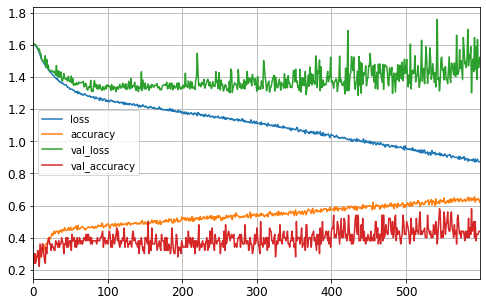

In [24]:
X_valid, X_train = X[:50], X[50:]
y_valid, y_train = y[:50], y[50:]

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_dim=12))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(25, activation='relu'))
model.add(keras.layers.Dense(5, activation="softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=600, batch_size=30, verbose=0)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

Evaluation on test data

In [25]:
y_test = keras.utils.to_categorical(test2['classenc'])
X_test = test2.iloc[:, 0:12].values

model.evaluate(X_test, y_test, verbose=0)

[1.5157114392206854, 0.52369076]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
Total params: 7,755
Trainable params: 7,755
Non-trainable params: 0
_________________________________________________________________


Neural Network model training time:

In [36]:
%%timeit
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_dim=12))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(25, activation='relu'))
model.add(keras.layers.Dense(5, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=600, batch_size=30, verbose=0)

41.4 s ± 3.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
